In [1]:
import h5py
import matplotlib.pyplot as plt
import numpy as np
import random
import scipy.io as sio
from scipy.spatial import distance_matrix

In [2]:
f = h5py.File('Data/10-9-18 A2D16F3 brain 50um.mat', 'r')
data = {}
for k, v in f.items():
    data[k] = np.array(v)
# f = open("Data/file.bin", 'rb')
# data = np.fromfile(f, '<f4')
# x, y, z = [int(n) for n in data[:3]]
# desi_image, z_axis = data[3:x*y*z + 3], data[-z:]
# desi_image.shape = (y, x, z)
# desi_image = desi_image.transpose((1, 0, 2))

In [3]:
xSize, ySize, zSize= data['img'].shape
spectra, current = np.zeros((ySize*zSize, xSize)), 0
for i in range(ySize):
    for j in range(zSize):
        spectra[current], current = data['img'][:,i,j], current + 1
        if current % 100 == 0:
            print('\r' + str(current), 'out of', ySize * zSize, end='')
spectra.shape

5200 out of 5203

(5203, 69088)

In [5]:
mu = np.mean(spectra, axis=0)

In [6]:
spectra -= mu

In [7]:
spectra = spectra.T

In [8]:
spectra.shape

(69088, 5203)

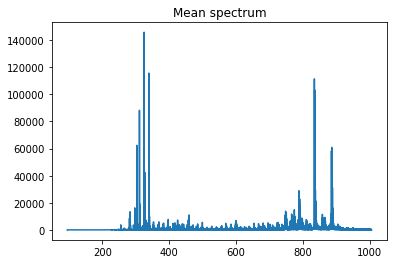

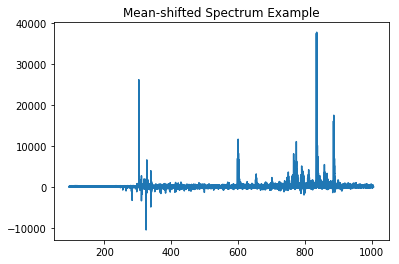

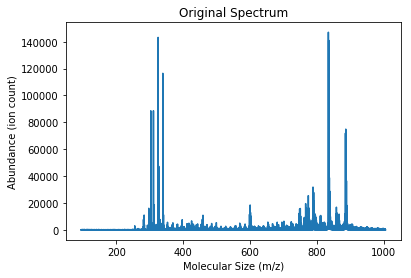

In [11]:
spectrum = random.randint(0, len(spectra.T))
plt.plot(data['imgZ'][0], mu)
plt.title('Mean spectrum')
plt.show()
plt.plot(data['imgZ'][0], spectra.T[spectrum])
plt.title('Mean-shifted Spectrum Example')
plt.show()
plt.plot(data['imgZ'][0], spectra.T[spectrum] + mu)
plt.title('Original Spectrum')
plt.xlabel('Molecular Size (m/z)')
plt.ylabel('Abundance (ion count)')
plt.show()

In [12]:
U, S, V = np.linalg.svd(spectra, False)

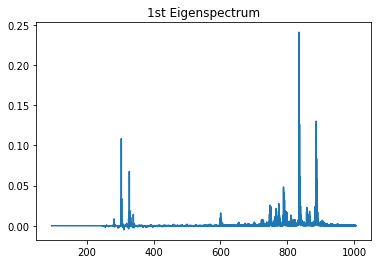

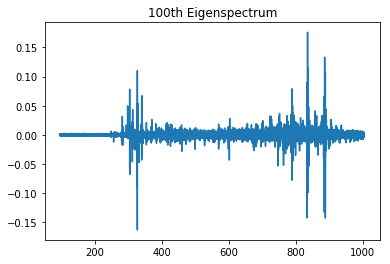

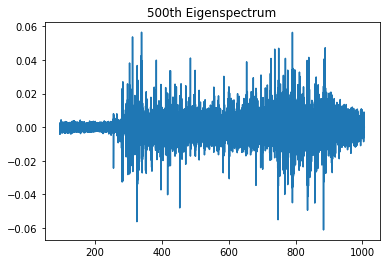

In [13]:
for i in [0, 99, 499]:
    plt.plot(data['imgZ'][0], U.T[i])
    plt.title(str(i+1)+('st' if i%10==0 else ('nd' if i%10==1 else ('rd' if i%10==2 else 'th')))+' Eigenspectrum')
    plt.show()

In [14]:
def project(A, s):
    return np.dot(U[:,:s].T, A)

In [15]:
# print (U[:,:10].T.shape)
spectrum = random.randint(0, len(spectra.T))
# plt.plot(data['imgZ'][0], spectra.T[spectrum] + mu)
# plt.title('Original Spectrum')
# plt.show()

In [18]:
z, x, y = data['img'].shape
adjacency = np.zeros((y*x, y*x))
index = 0
dist_array = []
r = 1
deltas = [[i,j] for i in range(-r, r+1) for j in range(-r, r+1) if ((i != 0) != (j != 0))]
for i in range(x):
    for j in range(y):
        spectrum = data['img'][:,i,j]
        for delta in deltas:
            i0, j0 = i + delta[0], j + delta[1]
            if i0 >= 0 and i0 < x and j0 >= 0 and j0 < y:
                dist = np.linalg.norm(data['img'][:,i+delta[0],j+delta[1]] - spectrum)
                adjacency[index + y*delta[0] + delta[1], index] = dist
                dist_array.append(dist)
        index += 1
    print('\r Processing row ' + str(i) + ' out of ' + str(x), end='')
adjacency = np.mean(dist_array)/adjacency

 Processing row 120 out of 121

/home/JCPriceLab/.local/lib/python3.6/site-packages/ipykernel_launcher.py:18: RuntimeWarning: divide by zero encountered in true_divide


In [87]:
x, y, z = desi_image.shape
adjacency = np.zeros((y*x, y*x))
index = 0
dist_array = []
r = 1
deltas = [[i,j] for i in range(-r, r+1) for j in range(-r, r+1) if ((i != 0) != (j != 0))]
for i in range(x):
    for j in range(y):
        spectrum = desi_image[i,j,:]
        for delta in deltas:
            i0, j0 = i + delta[0], j + delta[1]
            if i0 >= 0 and i0 < x and j0 >= 0 and j0 < y:
                dist = np.linalg.norm(desi_image[i0,j0,:] - spectrum)
                adjacency[index + y*delta[0] + delta[1], index] = dist
                dist_array.append(dist)
        index += 1
    print('\r Processing row ' + str(i) + ' out of ' + str(x), end='')
adjacency = np.mean(dist_array)/adjacency

 Processing row 39 out of 40

/home/JCPriceLab/.local/lib/python3.6/site-packages/ipykernel_launcher.py:18: RuntimeWarning: divide by zero encountered in true_divide


In [73]:
adjacency.shape

(800, 800)

In [82]:
np.ravel(adjacency).astype('float32').tofile('adj.dat')

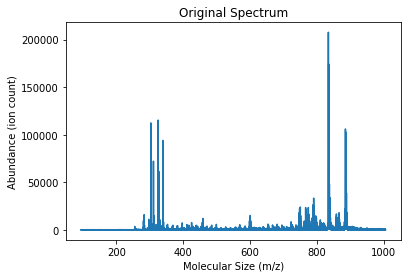

In [20]:
plt.plot(data['imgZ'][0], spectra.T[spectrum]+mu)
plt.title("Original Spectrum")
plt.xlabel("Molecular Size (m/z)")
plt.ylabel("Abundance (ion count)")
plt.show()

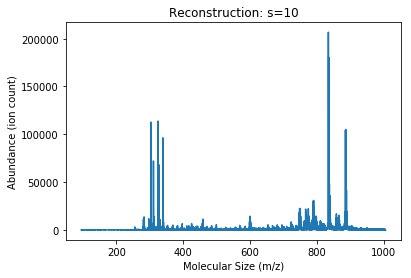

Normed difference: 56902.94423164941
Mean difference: 101.29175154743672
Maximum difference: 8561.814806527684


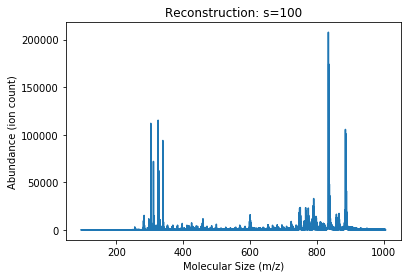

Normed difference: 42469.63813104603
Mean difference: 90.5400273780715
Maximum difference: 3321.655112481578


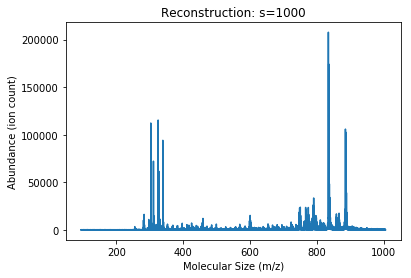

Normed difference: 22538.558494623336
Mean difference: 52.23584996149292
Maximum difference: 972.3622590163591


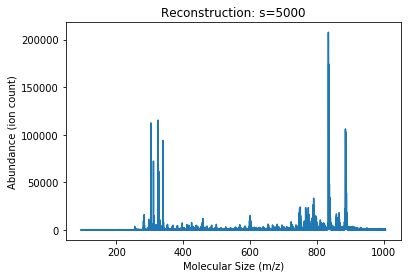

Normed difference: 425.86337892204267
Mean difference: 1.1578196601664317
Maximum difference: 10.775500112582279


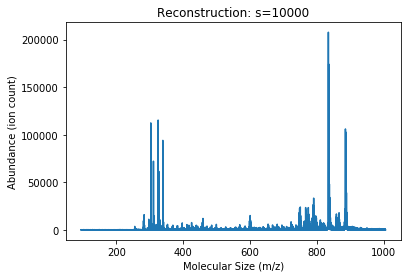

Normed difference: 1.034779287368703e-09
Mean difference: 1.2315954351247332e-12
Maximum difference: 3.055902197957039e-10


In [21]:
for s in [10, 100, 1000, 5000, 10000]:
    reconstruction = U[:,:s]@project(spectra.T[spectrum], s)
    plt.plot(data['imgZ'][0], reconstruction + mu)
    plt.title('Reconstruction: s='+str(s))
    plt.xlabel("Molecular Size (m/z)")
    plt.ylabel("Abundance (ion count)")
    plt.show()
    print('Normed difference:', np.linalg.norm(spectra.T[spectrum] - reconstruction))
    print('Mean difference:', np.mean(abs(spectra.T[spectrum] - reconstruction)))
    print('Maximum difference:', max(abs(spectra.T[spectrum] - reconstruction)))

In [39]:
projection = project(spectra, 100).T
dist = distance_matrix(projection, projection)

In [44]:
np.ravel(dist).astype('float32').tofile('weights.dat')

In [45]:
np.argmin(dist[dist > 0])

7419520

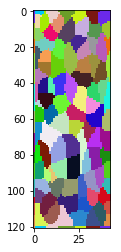

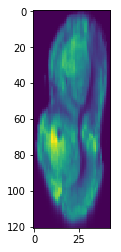

60214

In [59]:
communities=[[2672,2714,2715,2757,2758,2759,2800,2801,2802,2803,2843,2844,2845,2846,2847,2848,2886,2887,2888,2889,2890,2891,2892,2893,2929,2930,2931,2932,2933,2934,2935,2936,2937,2938,2971,2972,2973,2974,2975,2976,2977,2978,2979,2980,2981,2982,3014,3015,3016,3017,3018,3019,3020,3021,3022,3023,3024,3025,3057,3058,3059,3060,3061,3062,3063,3064,3065,3066,3100,3101,3102,3103,3104,3105,3106,3107,3108,3144,3145,3146,3147,3148,3149,3150,3151,3188,3189,3190,3191,3192,3232,3233,3234,3235,3276,3277,3278,3320,3363],[836,837,878,879,880,921,922,923,924,963,964,965,966,967,1006,1007,1008,1009,1010,1011,1049,1050,1051,1052,1053,1054,1092,1093,1094,1095,1096,1097,1098,1135,1136,1137,1138,1139,1140,1141,1178,1179,1180,1181,1182,1183,1184,1221,1222,1223,1224,1225,1226,1227,1228,1264,1265,1266,1267,1268,1269,1270,1271,1307,1308,1309,1310,1311,1312,1313,1350,1351,1352,1353,1354,1355,1356,1393,1394,1395,1396,1397,1398,1399,1437,1438,1439,1440,1441,1480,1481,1482,1483,1484,1524,1525,1526,1568],[3067,3068,3109,3110,3111,3112,3152,3153,3154,3155,3193,3194,3195,3196,3197,3198,3199,3236,3237,3238,3239,3240,3241,3242,3279,3280,3281,3282,3283,3284,3285,3321,3322,3323,3324,3325,3326,3327,3328,3364,3365,3366,3367,3368,3369,3370,3371,3406,3407,3408,3409,3410,3411,3412,3413,3414,3449,3450,3451,3452,3453,3454,3455,3456,3457,3493,3494,3495,3496,3497,3498,3499,3500,3536,3537,3538,3539,3540,3541,3542,3543,3579,3580,3581,3582,3583,3584,3585,3622,3623,3624,3625,3626,3665,3666,3667],[3026,3027,3028,3029,3030,3031,3069,3070,3071,3072,3073,3074,3075,3113,3114,3115,3116,3117,3118,3119,3156,3157,3158,3159,3160,3161,3162,3163,3200,3201,3202,3203,3204,3205,3206,3207,3243,3244,3245,3246,3247,3248,3249,3250,3286,3287,3288,3289,3290,3291,3292,3293,3329,3330,3331,3332,3333,3334,3335,3336,3372,3373,3374,3375,3376,3377,3378,3379,3415,3416,3417,3418,3419,3420,3421,3422,3458,3459,3460,3461,3462,3463,3464,3465,3501,3502,3503,3504,3505,3506,3544,3545,3546],[2468,2510,2511,2512,2551,2552,2553,2554,2555,2592,2593,2594,2595,2596,2597,2598,2599,2634,2635,2636,2637,2638,2639,2640,2641,2642,2677,2678,2679,2680,2681,2682,2683,2684,2685,2719,2720,2721,2722,2723,2724,2725,2726,2727,2728,2761,2762,2763,2764,2765,2766,2767,2768,2769,2770,2771,2804,2805,2806,2807,2808,2809,2810,2811,2812,2813,2814,2849,2850,2851,2852,2853,2854,2855,2856,2857,2894,2895,2896,2897,2898,2899,2900,2939,2940,2941,2942,2943,2983,2984,2985,2986],[4444,4451,4452,4453,4487,4488,4490,4491,4492,4493,4494,4495,4496,4529,4530,4531,4532,4533,4534,4535,4536,4537,4538,4539,4571,4572,4573,4574,4575,4576,4577,4578,4579,4580,4581,4582,4615,4616,4617,4618,4619,4620,4621,4622,4623,4624,4625,4658,4659,4660,4661,4662,4663,4664,4665,4666,4667,4668,4704,4705,4706,4707,4708,4709,4710,4711,4747,4748,4749,4750,4751,4752,4753,4754,4791,4792,4793,4794,4795,4796,4797,4834,4835,4836,4837,4838,4839,4878,4879],[3507,3508,3547,3548,3549,3550,3551,3588,3589,3590,3591,3592,3593,3594,3631,3632,3633,3634,3635,3636,3637,3674,3675,3676,3677,3678,3679,3680,3717,3718,3719,3720,3721,3722,3723,3760,3761,3762,3763,3764,3765,3766,3803,3804,3805,3806,3807,3808,3809,3846,3847,3848,3849,3850,3851,3852,3889,3890,3891,3892,3893,3894,3895,3932,3933,3934,3935,3936,3937,3938,3975,3976,3977,3978,3979,3980,3981,4018,4019,4020,4021,4022,4023,4061,4062,4063,4064,4065],[1873,1874,1875,1876,1916,1917,1918,1919,1920,1959,1960,1961,1962,1963,1964,2002,2003,2004,2005,2006,2007,2044,2045,2046,2047,2048,2049,2050,2087,2088,2089,2090,2091,2092,2093,2130,2131,2132,2133,2134,2135,2136,2172,2173,2174,2175,2176,2177,2178,2215,2216,2217,2218,2219,2220,2221,2258,2259,2260,2261,2262,2263,2264,2301,2302,2303,2304,2305,2306,2307,2345,2346,2347,2348,2349,2350,2389,2390,2391,2392,2393,2434,2435,2436,2479],[236,278,279,320,321,322,323,362,363,364,365,366,404,405,406,407,408,409,446,447,448,449,450,451,452,489,490,491,492,493,494,495,531,532,533,534,535,536,537,538,574,575,576,577,578,579,580,581,616,617,618,619,620,621,622,623,624,659,660,661,662,663,664,665,666,667,702,703,704,705,706,707,708,709,747,748,749,750,751,791,792,793,834,835],[1523,1566,1567,1609,1610,1611,1652,1653,1654,1655,1695,1696,1697,1698,1699,1738,1739,1740,1741,1742,1781,1782,1783,1784,1785,1786,1823,1824,1825,1826,1827,1828,1829,1830,1866,1867,1868,1869,1870,1871,1872,1909,1910,1911,1912,1913,1914,1915,1952,1953,1954,1955,1956,1957,1958,1996,1997,1998,1999,2000,2001,2039,2040,2041,2042,2043,2082,2083,2084,2085,2086,2126,2127,2128,2129,2169,2170,2171,2213,2214,2257],[2316,2317,2359,2360,2401,2402,2403,2443,2444,2445,2446,2485,2486,2487,2488,2489,2526,2527,2528,2529,2530,2531,2532,2566,2567,2568,2569,2570,2571,2572,2573,2574,2575,2609,2610,2611,2612,2613,2614,2615,2616,2617,2652,2653,2654,2655,2656,2657,2658,2659,2660,2696,2697,2698,2699,2700,2701,2702,2703,2740,2741,2742,2743,2744,2745,2746,2783,2784,2785,2786,2787,2788,2789,2827,2828,2829,2830,2831,2832],[1042,1085,1128,1129,1171,1172,1173,1174,1214,1215,1216,1217,1218,1219,1220,1257,1258,1259,1260,1261,1262,1263,1300,1301,1302,1303,1304,1305,1306,1343,1344,1345,1346,1347,1348,1349,1386,1387,1388,1389,1390,1391,1392,1429,1430,1431,1432,1433,1434,1435,1436,1472,1473,1474,1475,1476,1477,1478,1479,1515,1516,1517,1518,1519,1520,1521,1522,1558,1559,1560,1561,1562,1600,1601,1602,1603,1644,1645],[3586,3587,3627,3628,3629,3630,3668,3669,3670,3671,3672,3673,3708,3709,3710,3711,3712,3713,3714,3715,3716,3751,3752,3753,3754,3755,3756,3757,3758,3759,3794,3795,3796,3797,3798,3799,3800,3801,3802,3838,3839,3840,3841,3842,3843,3844,3845,3881,3882,3883,3884,3885,3886,3887,3888,3925,3926,3927,3928,3929,3930,3931,3968,3969,3970,3971,3972,3973,3974,4012,4013,4014,4015,4016,4017,4059,4060],[1527,1528,1529,1530,1569,1570,1571,1572,1573,1574,1575,1576,1577,1578,1579,1612,1613,1614,1615,1616,1617,1618,1619,1620,1621,1622,1656,1657,1658,1659,1660,1661,1662,1663,1664,1665,1666,1700,1701,1702,1703,1704,1705,1706,1707,1708,1709,1743,1744,1745,1746,1747,1748,1749,1750,1751,1752,1787,1788,1789,1790,1791,1792,1793,1794,1831,1832,1833,1834,1835,1836,1837,1877,1878,1879,1921],[2038,2077,2078,2079,2080,2081,2119,2120,2121,2122,2123,2124,2125,2161,2162,2163,2164,2165,2166,2167,2168,2204,2205,2206,2207,2208,2209,2210,2211,2212,2247,2248,2249,2250,2251,2252,2253,2254,2255,2256,2290,2291,2292,2293,2294,2295,2296,2297,2298,2299,2334,2335,2336,2337,2338,2339,2340,2341,2377,2378,2379,2380,2381,2382,2383,2421,2422,2423,2424,2425,2426,2465,2466,2467,2508,2509],[4702,4703,4745,4746,4788,4789,4790,4831,4832,4833,4874,4875,4876,4877,4917,4918,4919,4920,4921,4959,4960,4961,4962,4963,4964,5002,5003,5004,5005,5006,5007,5008,5044,5045,5046,5047,5048,5049,5050,5051,5052,5086,5087,5088,5089,5090,5091,5092,5093,5094,5095,5128,5129,5130,5131,5132,5133,5134,5135,5136,5137,5138,5168,5169,5170,5171,5172,5173,5174,5175,5176,5177,5178,5179,5180,5181],[4066,4102,4103,4104,4105,4106,4107,4108,4109,4145,4146,4147,4148,4149,4150,4151,4152,4188,4189,4190,4191,4192,4193,4194,4195,4231,4232,4233,4234,4235,4236,4237,4238,4274,4275,4276,4277,4278,4279,4280,4281,4316,4317,4318,4319,4320,4321,4322,4323,4324,4359,4360,4361,4362,4363,4364,4365,4366,4367,4402,4403,4404,4405,4406,4407,4408,4409,4410,4445,4446,4447,4448,4449,4450,4489],[2875,2918,2919,2961,2962,2963,2964,2965,2966,2967,3004,3005,3006,3007,3008,3009,3010,3047,3048,3049,3050,3051,3052,3053,3090,3091,3092,3093,3094,3095,3096,3133,3134,3135,3136,3137,3138,3139,3176,3177,3178,3179,3180,3181,3182,3220,3221,3222,3223,3224,3225,3263,3264,3265,3266,3267,3268,3306,3307,3308,3309,3310,3311,3350,3351,3352,3353,3354,3393,3394,3395,3396,3397],[3341,3342,3343,3344,3345,3346,3347,3385,3386,3387,3388,3389,3390,3428,3429,3430,3431,3432,3433,3471,3472,3473,3474,3475,3476,3514,3515,3516,3517,3518,3519,3557,3558,3559,3560,3561,3562,3601,3602,3603,3604,3605,3606,3644,3645,3646,3647,3648,3649,3687,3688,3689,3690,3691,3692,3730,3731,3732,3733,3734,3735,3773,3774,3775,3776,3777,3778,3816,3817,3818,3819,3859,3860],[4394,4395,4436,4437,4438,4439,4478,4479,4480,4481,4482,4483,4520,4521,4522,4523,4524,4525,4526,4527,4563,4564,4565,4566,4567,4568,4569,4570,4606,4607,4608,4609,4610,4611,4612,4648,4649,4650,4651,4652,4653,4654,4655,4691,4692,4693,4694,4695,4696,4697,4734,4735,4736,4737,4738,4739,4777,4778,4779,4780,4781,4820,4821,4822,4823,4863,4864,4865,4866,4907,4908,4950],[4613,4614,4656,4657,4698,4699,4700,4701,4740,4741,4742,4743,4744,4782,4783,4784,4785,4786,4787,4824,4825,4826,4827,4828,4829,4830,4867,4868,4869,4870,4871,4872,4873,4909,4910,4911,4912,4913,4914,4915,4916,4951,4952,4953,4954,4955,4956,4957,4958,4994,4995,4996,4997,4998,4999,5000,5001,5037,5038,5039,5040,5041,5042,5043,5081,5082,5083,5084,5085,5125,5126,5127],[4840,4841,4842,4843,4880,4881,4882,4883,4884,4885,4886,4887,4888,4889,4922,4923,4924,4925,4926,4927,4928,4929,4930,4931,4965,4966,4967,4968,4969,4970,4971,4972,4973,4974,5009,5010,5011,5012,5013,5014,5015,5016,5017,5053,5054,5055,5056,5057,5058,5059,5096,5097,5098,5099,5100,5101,5102,5139,5140,5141,5142,5143,5144,5145,5182,5183,5184,5185,5186,5187,5188],[243,244,245,285,286,287,288,326,327,328,329,330,331,368,369,370,371,372,373,374,410,411,412,413,414,415,416,417,453,454,455,456,457,458,459,460,496,497,498,499,500,501,502,503,539,540,541,542,543,544,545,546,582,583,584,585,586,587,588,625,626,627,628,629,630,631,672,673,674],[639,640,682,683,684,724,725,726,767,768,769,810,811,812,813,853,854,855,856,895,896,897,898,899,938,939,940,941,942,981,982,983,984,985,986,1024,1025,1026,1027,1028,1029,1067,1068,1069,1070,1071,1072,1110,1111,1112,1113,1114,1115,1154,1155,1156,1157,1158,1197,1198,1199,1200,1201,1241,1242,1243,1244,1285,1286],[1563,1564,1565,1604,1605,1606,1607,1608,1646,1647,1648,1649,1650,1651,1688,1689,1690,1691,1692,1693,1694,1731,1732,1733,1734,1735,1736,1737,1774,1775,1776,1777,1778,1779,1780,1818,1819,1820,1821,1822,1861,1862,1863,1864,1865,1904,1905,1906,1907,1908,1947,1948,1949,1950,1951,1990,1991,1992,1993,1994,1995,2033,2034,2035,2036,2037,2076],[2300,2342,2343,2344,2384,2385,2386,2387,2388,2427,2428,2429,2430,2431,2432,2433,2469,2470,2471,2472,2473,2474,2475,2476,2477,2478,2513,2514,2515,2516,2517,2518,2519,2520,2521,2522,2556,2557,2558,2559,2560,2561,2562,2563,2564,2565,2600,2601,2602,2603,2604,2605,2606,2607,2608,2643,2644,2645,2646,2647,2648,2649,2650,2651,2692,2693,2694],[4055,4056,4057,4058,4097,4098,4099,4100,4101,4137,4139,4140,4141,4142,4143,4144,4179,4180,4181,4182,4183,4184,4185,4186,4187,4223,4224,4225,4226,4227,4228,4229,4230,4266,4267,4268,4269,4270,4271,4272,4273,4310,4311,4312,4313,4314,4315,4353,4354,4355,4356,4357,4358,4396,4397,4398,4399,4400,4401,4440,4441,4442,4443,4484,4485,4486,4528],[3142,3143,3185,3186,3187,3228,3229,3230,3231,3272,3273,3274,3275,3315,3316,3317,3318,3319,3358,3359,3360,3361,3362,3401,3402,3403,3404,3405,3444,3445,3446,3447,3448,3487,3488,3489,3490,3491,3492,3531,3532,3533,3534,3535,3574,3575,3576,3577,3578,3617,3618,3619,3620,3621,3661,3662,3663,3664,3704,3705,3706,3707,3747,3748,3749,3791],[3901,3902,3903,3942,3943,3944,3945,3946,3984,3985,3986,3987,3988,3989,4027,4028,4029,4030,4031,4032,4070,4071,4072,4073,4074,4075,4076,4113,4114,4115,4116,4117,4118,4119,4157,4158,4159,4160,4161,4162,4200,4201,4202,4203,4204,4205,4244,4245,4246,4247,4248,4249,4287,4288,4289,4290,4291,4292,4332,4333,4334,4335,4336,4377,4378,4379],[1804,1805,1806,1847,1848,1849,1890,1891,1892,1933,1934,1935,1975,1976,1977,1978,2018,2019,2020,2021,2061,2062,2063,2064,2104,2105,2106,2107,2146,2147,2148,2149,2150,2189,2190,2191,2192,2193,2232,2233,2234,2235,2236,2275,2276,2277,2278,2279,2318,2319,2320,2321,2322,2361,2362,2363,2364,2365,2404,2405,2406,2407,2408,2447,2490],[2448,2449,2450,2451,2491,2492,2493,2494,2533,2534,2535,2536,2537,2576,2577,2578,2579,2580,2618,2619,2620,2621,2622,2623,2661,2662,2663,2664,2665,2666,2704,2705,2706,2707,2708,2709,2747,2748,2749,2750,2751,2752,2790,2791,2792,2793,2794,2795,2833,2834,2835,2836,2837,2838,2876,2877,2878,2879,2880,2881,2920,2921,2922,2923,2924],[37,38,39,40,41,42,43,80,81,82,83,84,85,86,122,123,124,125,126,127,128,129,165,166,167,168,169,170,171,172,208,209,210,211,212,213,214,215,251,252,253,254,255,256,257,258,294,295,296,297,298,299,300,301,337,338,339,340,341,381,382,424],[1148,1189,1190,1191,1230,1231,1232,1233,1234,1272,1273,1274,1275,1276,1277,1314,1315,1316,1317,1318,1319,1320,1357,1358,1359,1360,1361,1362,1363,1364,1400,1401,1402,1403,1404,1405,1406,1407,1442,1443,1444,1445,1446,1447,1448,1449,1450,1485,1486,1487,1488,1489,1490,1491,1492,1493,1531,1532,1533,1534,1535,1536],[1284,1327,1328,1329,1369,1370,1371,1372,1412,1413,1414,1415,1454,1455,1456,1457,1458,1497,1498,1499,1500,1501,1540,1541,1542,1543,1544,1545,1582,1583,1584,1585,1586,1587,1588,1625,1626,1627,1628,1629,1630,1631,1668,1669,1670,1671,1672,1673,1674,1710,1711,1712,1713,1714,1715,1716,1753,1754,1755,1756,1797,1798],[2907,2908,2950,2951,2992,2993,2994,3034,3035,3036,3037,3077,3078,3079,3080,3120,3121,3122,3123,3124,3164,3165,3166,3167,3208,3209,3210,3211,3251,3252,3253,3254,3294,3295,3296,3297,3337,3338,3339,3340,3380,3381,3382,3423,3424,3425,3466,3467,3509,3510,3552,3553,3595,3596,3638,3681,3724,3767,3810,3853,3896,3939],[701,743,744,745,746,786,787,788,789,790,829,830,831,832,833,872,873,874,875,876,877,915,916,917,918,919,920,957,958,959,960,961,962,1000,1001,1002,1003,1004,1005,1043,1044,1045,1046,1047,1048,1086,1087,1088,1089,1090,1091,1130,1131,1132,1133,1134,1175,1176,1177],[2024,2025,2026,2027,2028,2029,2030,2031,2067,2068,2069,2070,2071,2072,2073,2074,2075,2110,2111,2112,2113,2114,2115,2116,2117,2118,2153,2154,2155,2156,2157,2158,2159,2160,2197,2198,2199,2200,2201,2202,2203,2240,2241,2242,2243,2244,2245,2246,2284,2285,2286,2287,2288,2327,2328,2329,2330,2371,2372],[2873,2874,2915,2916,2917,2958,2959,2960,3000,3001,3002,3003,3042,3043,3044,3045,3046,3085,3086,3087,3088,3089,3127,3128,3129,3130,3131,3132,3170,3171,3172,3173,3174,3175,3212,3213,3214,3215,3216,3217,3218,3219,3255,3256,3257,3258,3259,3260,3261,3262,3298,3299,3300,3301,3302,3303,3304,3305,3348],[694,735,736,737,738,739,775,776,777,778,779,780,781,782,783,784,785,818,819,820,821,822,823,824,825,826,827,828,861,862,863,864,865,866,867,868,869,870,871,906,907,908,909,910,911,912,913,914,950,951,952,953,955,956,993,994,998,999],[2289,2331,2332,2333,2373,2374,2375,2376,2414,2415,2416,2417,2418,2419,2420,2457,2458,2459,2460,2461,2462,2463,2464,2500,2501,2502,2503,2504,2505,2506,2507,2543,2544,2545,2546,2547,2548,2549,2550,2586,2587,2588,2589,2590,2591,2629,2630,2631,2632,2633,2673,2674,2675,2676,2716,2717,2718,2760],[2686,2687,2688,2689,2690,2691,2729,2730,2731,2732,2733,2734,2735,2736,2772,2773,2774,2775,2776,2777,2778,2779,2815,2816,2817,2818,2819,2820,2821,2822,2858,2859,2860,2861,2862,2863,2864,2901,2902,2903,2904,2905,2906,2944,2945,2946,2947,2948,2949,2987,2988,2989,2990,2991,3032,3033,3076],[4637,4679,4680,4681,4721,4722,4723,4724,4725,4763,4764,4765,4766,4767,4768,4806,4807,4808,4809,4810,4811,4850,4851,4852,4853,4854,4855,4893,4894,4895,4896,4897,4898,4937,4938,4939,4940,4941,4980,4981,4982,4983,4984,5024,5025,5026,5027,5067,5068,5069,5070,5111,5112,5154,5155,5197,5198],[760,803,804,845,846,847,887,888,889,890,929,930,931,932,933,971,972,973,974,975,976,1013,1014,1015,1016,1017,1018,1019,1020,1056,1057,1058,1059,1060,1061,1062,1063,1099,1100,1101,1102,1103,1104,1105,1106,1142,1143,1144,1145,1146,1147,1185,1186,1187,1188,1229],[2137,2179,2180,2181,2182,2222,2223,2224,2225,2226,2227,2265,2266,2267,2268,2269,2270,2271,2272,2308,2309,2310,2311,2312,2313,2314,2315,2351,2352,2353,2354,2355,2356,2357,2358,2394,2395,2396,2397,2398,2399,2400,2437,2438,2439,2440,2441,2442,2480,2481,2482,2483,2484,2523,2524,2525],[4645,4646,4647,4688,4689,4690,4731,4732,4733,4774,4775,4776,4817,4818,4819,4860,4861,4862,4903,4904,4905,4906,4946,4947,4948,4949,4989,4990,4991,4992,4993,5032,5033,5034,5035,5036,5075,5076,5077,5078,5079,5080,5118,5119,5120,5121,5122,5123,5124,5161,5162,5163,5164,5165,5166,5167],[1795,1796,1838,1839,1840,1841,1880,1881,1882,1883,1884,1922,1923,1924,1925,1926,1927,1965,1966,1967,1968,1969,1970,2008,2009,2010,2011,2012,2013,2051,2052,2053,2054,2055,2056,2057,2094,2095,2096,2097,2098,2099,2100,2138,2139,2140,2141,2142,2143,2183,2184,2185,2186,2228,2229],[29,30,31,32,33,34,35,36,72,73,74,75,76,77,78,79,115,116,117,118,119,120,121,158,159,160,161,162,163,164,202,203,204,205,206,207,246,247,248,249,250,289,290,291,292,293,333,334,335,336,376,377,378,379],[332,375,380,418,419,420,421,422,423,461,462,463,464,465,466,467,504,505,506,507,508,509,510,547,548,549,550,551,552,553,589,590,591,592,593,594,595,596,597,632,633,634,635,636,637,638,676,677,678,679,680,681,722,723],[3982,3983,4024,4025,4026,4067,4068,4069,4110,4111,4112,4153,4154,4155,4156,4196,4197,4198,4199,4239,4240,4241,4242,4243,4282,4283,4284,4285,4286,4325,4326,4327,4328,4329,4368,4369,4370,4371,4372,4411,4412,4413,4414,4415,4454,4455,4456,4457,4458,4497,4498,4499,4500,4540],[4805,4847,4848,4849,4890,4891,4892,4932,4933,4934,4935,4936,4975,4976,4977,4978,4979,5018,5019,5020,5021,5022,5023,5060,5061,5062,5063,5064,5065,5066,5103,5104,5105,5106,5107,5108,5109,5110,5146,5147,5148,5149,5150,5151,5152,5153,5189,5190,5191,5192,5193,5194,5195,5196],[3383,3384,3426,3427,3468,3469,3470,3511,3512,3513,3554,3555,3556,3597,3598,3599,3600,3639,3640,3641,3642,3643,3682,3683,3684,3685,3686,3725,3726,3727,3728,3729,3768,3769,3770,3771,3772,3811,3812,3813,3814,3815,3854,3855,3856,3857,3858,3897,3898,3899,3900,3940,3941],[1074,1075,1117,1118,1159,1160,1161,1202,1203,1204,1245,1246,1247,1287,1288,1289,1290,1330,1331,1332,1333,1373,1374,1375,1376,1416,1417,1418,1419,1459,1460,1461,1462,1502,1503,1504,1505,1546,1547,1548,1589,1590,1591,1632,1633,1634,1676,1677,1719,1720,1762,1763],[668,669,670,671,710,711,712,713,714,715,716,717,752,753,754,755,756,757,758,759,794,795,796,797,798,799,800,801,802,838,839,840,841,842,843,844,881,882,883,884,885,886,925,926,927,928,968,969,970,1012,1055],[1107,1149,1150,1151,1152,1153,1192,1193,1194,1195,1196,1235,1236,1237,1238,1239,1240,1278,1279,1280,1281,1282,1283,1321,1322,1323,1324,1325,1326,1365,1366,1367,1368,1408,1409,1410,1411,1451,1452,1453,1494,1495,1496,1537,1538,1539,1580,1581,1623,1624,1667],[1675,1717,1718,1757,1758,1759,1760,1761,1799,1800,1801,1802,1803,1842,1843,1844,1845,1846,1885,1886,1887,1888,1889,1928,1929,1930,1931,1932,1971,1972,1973,1974,2014,2015,2016,2017,2058,2059,2060,2101,2102,2103,2144,2145,2187,2188,2230,2231,2273,2274],[4086,4087,4088,4089,4090,4091,4129,4130,4131,4132,4133,4134,4135,4172,4173,4174,4175,4176,4177,4178,4215,4216,4217,4218,4219,4220,4221,4222,4258,4259,4260,4261,4262,4263,4264,4265,4303,4304,4305,4306,4307,4308,4309,4348,4349,4350,4351,4352,4392,4393],[3779,3820,3821,3822,3861,3862,3863,3864,3865,3904,3905,3906,3907,3908,3947,3948,3949,3950,3951,3990,3991,3992,3993,3994,4033,4034,4035,4036,4037,4077,4078,4079,4080,4081,4120,4121,4122,4123,4163,4164,4165,4166,4206,4207,4208,4250,4251,4293,4294],[14,15,16,17,18,19,20,21,22,57,58,59,60,61,62,63,64,65,101,102,103,104,105,106,107,108,144,145,146,147,148,149,150,188,189,190,191,192,232,233,234,235,275,276,277,318,319,361],[23,24,25,26,27,28,66,67,68,69,70,71,109,110,111,112,113,114,151,152,153,154,155,156,157,193,194,195,196,197,198,199,200,201,237,238,239,240,241,242,280,281,282,283,284,324,325,367],[143,186,187,228,229,230,231,269,270,271,272,273,274,312,313,314,315,316,317,354,355,356,357,358,359,360,397,398,399,400,401,402,403,441,442,443,444,445,484,485,486,487,488,528,529,530,572,573],[2695,2737,2738,2739,2780,2781,2782,2823,2824,2825,2826,2865,2866,2867,2868,2869,2870,2871,2872,2909,2910,2911,2912,2913,2914,2952,2953,2954,2955,2956,2957,2995,2996,2997,2998,2999,3038,3039,3040,3041,3081,3082,3083,3084,3125,3126,3168,3169],[4330,4331,4373,4374,4375,4376,4416,4417,4418,4419,4420,4421,4422,4459,4460,4461,4462,4463,4464,4502,4503,4504,4505,4506,4507,4545,4546,4547,4548,4549,4550,4588,4589,4590,4591,4592,4593,4632,4633,4634,4635,4636,4675,4676,4677,4678,4719,4720],[342,343,344,383,384,385,386,387,425,426,427,428,429,430,468,469,470,471,472,473,511,512,513,514,515,516,554,555,556,557,558,559,598,599,600,601,602,641,642,643,644,645,685,686,687,688,729],[396,438,439,440,480,481,482,483,522,523,524,525,526,527,564,565,566,567,568,569,570,571,608,609,610,611,612,613,614,615,651,652,653,654,655,656,657,658,695,696,697,698,699,700,740,741,742],[3658,3659,3660,3699,3700,3701,3702,3703,3742,3743,3744,3745,3746,3785,3786,3787,3788,3789,3828,3829,3830,3831,3832,3871,3872,3873,3874,3875,3914,3915,3916,3917,3918,3957,3958,3959,3960,3961,4000,4001,4002,4003,4004,4043,4044,4045,4046],[4501,4541,4542,4543,4544,4583,4584,4585,4586,4587,4626,4627,4628,4629,4630,4631,4669,4670,4671,4672,4673,4674,4712,4713,4714,4715,4716,4717,4718,4755,4756,4757,4758,4759,4760,4761,4762,4798,4799,4800,4801,4802,4803,4804,4844,4845,4846],[3349,3391,3392,3434,3435,3436,3437,3438,3439,3440,3477,3478,3479,3480,3481,3482,3483,3520,3521,3522,3523,3524,3525,3526,3563,3564,3565,3566,3567,3568,3569,3607,3608,3609,3610,3611,3612,3650,3651,3652,3653,3654,3655,3693,3694,3736],[4295,4337,4338,4380,4381,4382,4423,4424,4425,4426,4465,4466,4467,4468,4469,4470,4471,4508,4509,4510,4511,4512,4513,4514,4515,4551,4552,4553,4554,4555,4556,4557,4558,4594,4595,4596,4597,4598,4599,4600,4601,4638,4639,4640,4682],[3695,3696,3697,3698,3737,3738,3739,3740,3741,3780,3781,3782,3783,3784,3823,3824,3825,3826,3827,3866,3867,3868,3869,3870,3909,3910,3911,3912,3913,3952,3953,3954,3955,3956,3995,3996,3997,3998,3999,4038,4039,4040,4041,4042],[4082,4083,4084,4085,4124,4125,4126,4127,4128,4167,4168,4169,4170,4171,4209,4210,4211,4212,4213,4214,4252,4253,4254,4255,4256,4257,4296,4297,4298,4299,4300,4339,4340,4341,4342,4343,4383,4384,4385,4386,4427,4428,4429,4472],[49,92,134,135,136,177,178,179,219,220,221,222,223,262,263,264,265,266,305,306,307,308,309,348,349,350,351,352,353,391,392,393,394,395,434,435,436,437,477,478,479,520,521],[1293,1294,1295,1296,1297,1298,1299,1336,1337,1338,1339,1340,1341,1342,1379,1380,1381,1382,1383,1384,1385,1423,1424,1425,1426,1427,1428,1466,1467,1468,1469,1470,1471,1510,1511,1512,1513,1514,1555,1556,1557,1599,1642],[7,8,9,10,11,12,13,50,51,52,53,54,55,56,93,94,95,96,97,98,99,100,137,138,139,140,141,142,180,181,182,183,184,185,224,225,226,227,267,268,310,311],[675,718,719,720,721,761,762,763,764,765,766,805,806,807,808,809,848,849,850,851,852,891,892,893,894,934,935,936,937,977,978,979,980,1021,1022,1023,1064,1065,1066,1108,1109],[954,995,996,997,1037,1038,1039,1040,1041,1079,1080,1081,1082,1083,1084,1122,1123,1124,1125,1126,1127,1165,1166,1167,1168,1169,1170,1207,1208,1209,1210,1211,1212,1213,1250,1251,1252,1253,1254,1255,1256],[2323,2324,2366,2367,2368,2369,2409,2410,2411,2412,2413,2452,2453,2454,2455,2456,2495,2496,2497,2498,2499,2538,2539,2540,2541,2542,2581,2582,2583,2584,2585,2624,2625,2626,2627,2628,2667,2668,2669,2670,2671],[2710,2711,2712,2713,2753,2754,2755,2756,2796,2797,2798,2799,2839,2840,2841,2842,2882,2883,2884,2885,2925,2926,2927,2928,2968,2969,2970,3011,3012,3013,3054,3055,3056,3097,3098,3099,3140,3141,3183,3226],[1641,1682,1683,1684,1724,1725,1726,1727,1767,1768,1769,1770,1809,1810,1811,1812,1813,1852,1853,1854,1855,1856,1895,1896,1897,1898,1899,1938,1939,1940,1941,1942,1981,1982,1983,1984,1985],[1422,1463,1464,1465,1506,1507,1508,1509,1549,1550,1551,1552,1553,1554,1592,1593,1594,1595,1596,1597,1598,1635,1636,1637,1638,1639,1640,1678,1679,1680,1681,1721,1722,1723,1766],[3184,3227,3269,3270,3271,3312,3313,3314,3355,3356,3357,3398,3399,3400,3441,3442,3443,3484,3485,3486,3527,3528,3529,3530,3570,3571,3572,3573,3613,3614,3615,3616,3656,3657],[4301,4302,4344,4345,4346,4347,4387,4388,4389,4390,4391,4430,4431,4432,4433,4434,4435,4473,4474,4475,4476,4477,4516,4517,4518,4519,4559,4560,4561,4562,4602,4603,4604,4605],[727,728,730,731,770,771,772,773,774,814,815,816,817,857,858,859,860,900,901,902,903,943,944,945,946,987,988,989,1030,1031,1032,1073,1116],[904,905,947,948,949,990,991,992,1033,1034,1035,1036,1076,1077,1078,1119,1120,1121,1162,1163,1164,1205,1206,1248,1249,1291,1292,1334,1335,1377,1378,1420,1421],[4641,4642,4643,4644,4683,4684,4685,4686,4687,4726,4727,4728,4729,4730,4769,4770,4771,4772,4773,4812,4813,4814,4815,4816,4856,4857,4858,4859,4899,4900,4901,4902],[1643,1685,1686,1687,1728,1729,1730,1771,1772,1773,1814,1815,1816,1817,1857,1858,1859,1860,1900,1901,1902,1903,1943,1944,1945,1946,1986,1987,1988,1989,2032],[4942,4943,4944,4945,4985,4986,4987,4988,5028,5029,5030,5031,5071,5072,5073,5074,5113,5114,5115,5116,5117,5156,5157,5158,5159,5160,5199,5200,5201,5202,5203],[474,475,476,517,518,519,560,561,562,563,603,604,605,606,607,646,647,648,649,650,689,690,691,692,693,732,733,734],[3790,3833,3834,3835,3876,3877,3878,3919,3920,3921,3922,3962,3963,3964,3965,4005,4006,4007,4008,4047,4048,4049,4050,4051,4092,4093,4094,4136],[130,131,132,173,174,175,176,216,217,218,259,260,261,302,303,304,345,346,347,388,389,390,431,432,433],[1764,1765,1807,1808,1850,1851,1893,1894,1936,1937,1979,1980,2022,2023,2065,2066,2108,2109,2151,2152,2194],[3750,3792,3793,3836,3837,3879,3880,3923,3924,3966,3967,4009,4010,4011,4052,4053,4054,4095,4096,4138],[1,2,3,4,5,6,44,45,46,47,48,87,88,89,90,91,133],[2195,2196,2237,2238,2239,2280,2281,2282,2283,2325,2326],[2370]]
image = np.zeros((x,y,3))
for community in communities:
    color = np.random.randint(1, 255, 3)
    for pixel in community:
        image[pixel//y-1,pixel%y,:] = color
image = image.astype(int)
image
plt.imshow(image)
plt.show()
plt.imshow(data['img'][np.argmax(data['img'][:,30,20]),:,:])
plt.show()

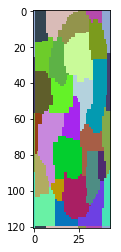

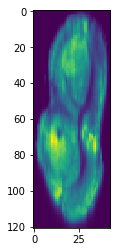

In [72]:
communities = [[588,589,625,626,627,628,629,630,631,632,668,669,670,671,672,673,674,675,709,710,711,712,713,714,715,716,717,718,751,752,753,754,755,756,757,758,759,760,761,794,795,796,797,798,799,800,801,802,803,804,836,837,838,839,840,841,842,843,844,845,846,847,877,878,879,880,881,882,883,884,885,886,887,888,889,890,920,921,922,923,924,925,926,927,928,929,930,931,932,933,963,964,965,966,967,968,969,970,971,972,973,974,975,976,1006,1007,1008,1009,1010,1011,1012,1013,1014,1015,1016,1017,1018,1019,1020,1049,1050,1051,1052,1053,1054,1055,1056,1057,1058,1059,1060,1061,1062,1063,1092,1093,1094,1095,1096,1097,1098,1099,1100,1101,1102,1103,1104,1105,1106,1135,1136,1137,1138,1139,1140,1141,1142,1143,1144,1145,1146,1147,1148,1149,1178,1179,1180,1181,1182,1183,1184,1185,1186,1187,1188,1189,1190,1191,1192,1221,1222,1223,1224,1225,1226,1227,1228,1229,1230,1231,1232,1233,1234,1235,1264,1265,1266,1267,1268,1269,1270,1271,1272,1273,1274,1275,1276,1277,1278,1279,1307,1308,1309,1310,1311,1312,1313,1314,1315,1316,1317,1318,1319,1320,1321,1322,1350,1351,1352,1353,1354,1355,1356,1357,1358,1359,1360,1361,1362,1363,1364,1365,1394,1395,1396,1397,1398,1399,1400,1401,1402,1403,1404,1405,1406,1407,1408,1437,1438,1439,1440,1441,1442,1443,1444,1445,1446,1447,1448,1449,1450,1451,1480,1481,1482,1483,1484,1485,1486,1487,1488,1489,1490,1491,1492,1493,1494,1523,1524,1525,1526,1527,1528,1529,1530,1531,1532,1533,1534,1535,1536,1537,1568,1569,1570,1571,1572,1573,1574,1575,1576,1577,1578,1579,1580,1615,1616,1617,1618,1619,1620,1621,1622,1623,1658,1659,1660,1661,1662,1663,1664,1665,1666,1701,1702,1703,1704,1708,1709,1744,1745,1746,1747],[2416,2457,2458,2459,2500,2501,2502,2503,2504,2505,2506,2507,2508,2509,2510,2542,2543,2544,2545,2546,2547,2548,2549,2550,2551,2552,2553,2585,2586,2587,2588,2589,2590,2591,2592,2593,2594,2595,2596,2628,2629,2630,2631,2632,2633,2634,2635,2636,2637,2638,2639,2671,2672,2673,2674,2675,2676,2677,2678,2679,2680,2681,2682,2714,2715,2716,2717,2718,2719,2720,2721,2722,2723,2724,2725,2755,2756,2757,2758,2759,2760,2761,2762,2763,2764,2765,2766,2767,2768,2798,2799,2800,2801,2802,2803,2804,2805,2806,2807,2808,2809,2810,2811,2841,2842,2843,2844,2845,2846,2847,2848,2849,2850,2851,2852,2853,2884,2885,2886,2887,2888,2889,2890,2891,2892,2893,2894,2895,2896,2927,2928,2929,2930,2931,2932,2933,2934,2935,2936,2937,2938,2939,2970,2971,2972,2973,2974,2975,2976,2977,2978,2979,2980,2981,2982,3013,3014,3015,3016,3017,3018,3019,3020,3021,3022,3023,3024,3025,3056,3057,3058,3059,3060,3061,3062,3063,3064,3065,3066,3099,3100,3101,3102,3103,3104,3105,3106,3107,3108,3109,3142,3143,3144,3145,3146,3147,3148,3149,3150,3151,3152,3185,3186,3187,3188,3189,3190,3191,3192,3228,3229,3230,3231,3232,3233,3234,3235,3271,3272,3273,3274,3275,3276,3277,3278,3314,3315,3316,3317,3318,3319,3320,3321,3357,3358,3359,3360,3361,3362,3363,3364,3400,3401,3402,3403,3404,3405,3406,3407,3443,3444,3445,3446,3447,3448,3449,3450,3486,3487,3488,3489,3490,3491,3492,3493,3530,3531,3532,3533,3534,3535,3536,3573,3574,3575,3576,3577,3578,3579,3617,3618,3619,3620,3621,3622,3660,3661,3662,3663,3664,3665,3704,3705,3706,3707,3708,3748,3749,3750,3751,3752,3791,3792,3793,3794,3795,3834,3835,3836,3837,3838,3877,3878,3879,3880,3881,3920,3921,3922,3923,3924,3963,3964,3965,3966,3967,4007,4008,4009,4010,4050,4051,4052,4053,4093,4094,4095,4096,4137,4138,4139,4180,4223],[3067,3068,3069,3070,3110,3111,3112,3113,3114,3115,3116,3117,3153,3154,3155,3156,3157,3158,3159,3160,3161,3162,3163,3164,3193,3194,3195,3196,3197,3198,3199,3200,3201,3202,3203,3204,3205,3206,3207,3236,3237,3238,3239,3240,3241,3242,3243,3244,3245,3246,3247,3248,3249,3250,3279,3280,3281,3282,3283,3284,3285,3286,3287,3288,3289,3290,3291,3292,3293,3322,3323,3324,3325,3326,3327,3328,3329,3330,3331,3332,3333,3334,3335,3336,3337,3365,3366,3367,3368,3369,3370,3371,3372,3373,3374,3375,3376,3377,3378,3379,3380,3408,3409,3410,3411,3412,3413,3414,3415,3416,3417,3418,3419,3420,3421,3422,3423,3451,3452,3453,3454,3455,3456,3457,3458,3459,3460,3461,3462,3463,3464,3465,3466,3494,3495,3496,3497,3498,3499,3500,3501,3502,3503,3504,3505,3506,3507,3508,3509,3537,3538,3539,3540,3541,3542,3543,3544,3545,3546,3547,3548,3549,3550,3551,3552,3580,3581,3582,3583,3584,3585,3586,3587,3588,3589,3590,3591,3592,3593,3594,3595,3623,3624,3625,3626,3627,3628,3629,3630,3631,3632,3633,3634,3635,3636,3637,3638,3666,3667,3668,3669,3670,3671,3672,3673,3674,3675,3676,3677,3678,3679,3680,3681,3709,3710,3711,3712,3713,3714,3715,3716,3717,3718,3719,3720,3721,3722,3723,3724,3753,3754,3755,3756,3757,3758,3759,3760,3761,3762,3763,3764,3765,3766,3767,3796,3797,3798,3799,3800,3801,3802,3803,3804,3805,3806,3807,3808,3809,3810,3839,3840,3841,3842,3843,3844,3845,3846,3847,3848,3849,3850,3851,3852,3853,3882,3883,3884,3885,3886,3887,3888,3889,3890,3891,3892,3893,3894,3895,3896,3925,3926,3927,3928,3929,3932,3933,3934,3935,3936,3937,3938,3939,3968,3969,3970,3971,3972,3975,3976,3977,3978,3979,3980,3981,4011,4012,4013,4014,4015,4018,4019,4020,4021,4022,4023,4054,4055,4056,4057,4058,4063,4064,4065,4066],[1237,1238,1239,1240,1241,1242,1243,1244,1280,1281,1282,1283,1284,1285,1286,1287,1323,1324,1325,1326,1327,1328,1329,1330,1366,1367,1368,1369,1370,1371,1372,1373,1409,1410,1411,1412,1413,1414,1415,1416,1452,1453,1454,1455,1456,1457,1458,1459,1495,1496,1497,1498,1499,1500,1501,1502,1538,1539,1540,1541,1542,1543,1544,1545,1581,1582,1583,1584,1585,1586,1587,1588,1624,1625,1626,1627,1628,1629,1630,1631,1667,1668,1669,1670,1671,1672,1673,1674,1710,1711,1712,1713,1714,1715,1716,1717,1753,1754,1755,1756,1757,1758,1759,1760,1796,1797,1798,1799,1800,1801,1802,1803,1839,1840,1841,1842,1843,1844,1845,1846,1882,1883,1884,1885,1886,1887,1888,1889,1925,1926,1927,1928,1929,1930,1931,1932,1968,1969,1970,1971,1972,1973,1974,1975,2011,2012,2013,2014,2015,2016,2017,2018,2054,2055,2056,2057,2058,2059,2060,2061,2097,2098,2099,2100,2101,2102,2103,2140,2141,2142,2143,2144,2145,2146,2183,2184,2185,2186,2187,2188,2189,2226,2227,2228,2229,2230,2231,2232,2269,2270,2271,2272,2273,2274,2275,2311,2312,2313,2314,2315,2316,2317,2318,2354,2355,2356,2357,2358,2359,2360,2361,2397,2398,2399,2400,2401,2402,2403,2438,2439,2440,2441,2442,2443,2444,2445,2446,2481,2482,2483,2484,2485,2486,2487,2488,2489,2523,2524,2525,2526,2527,2528,2529,2530,2531,2532,2566,2567,2568,2569,2570,2571,2572,2573,2574,2575,2609,2610,2611,2612,2613,2614,2615,2616,2617,2652,2653,2654,2655,2656,2657,2658,2659,2660,2695,2696,2697,2698,2699,2700,2701,2702,2703,2738,2739,2740,2741,2742,2743,2744,2745,2746,2783,2784,2785,2786,2787,2788,2789,2826,2827,2828,2829,2830,2831,2832,2870,2871,2872,2873,2874,2875,2914,2915,2916,2917,2918,2957,2958,2959,2960],[3930,3931,3973,3974,3982,4016,4017,4024,4025,4026,4027,4059,4060,4061,4062,4067,4068,4069,4070,4102,4103,4104,4105,4106,4107,4108,4109,4110,4111,4112,4113,4145,4146,4147,4148,4149,4150,4151,4152,4153,4154,4155,4156,4188,4189,4190,4191,4192,4193,4194,4195,4196,4197,4198,4199,4231,4232,4233,4234,4235,4236,4237,4238,4239,4240,4241,4242,4274,4275,4276,4277,4278,4279,4280,4281,4282,4283,4284,4285,4317,4318,4319,4320,4321,4322,4323,4324,4325,4326,4327,4328,4329,4360,4361,4362,4363,4364,4365,4366,4367,4368,4369,4370,4371,4372,4402,4403,4404,4405,4406,4407,4408,4409,4410,4411,4412,4413,4414,4415,4445,4446,4447,4448,4449,4450,4451,4452,4453,4454,4455,4456,4457,4458,4488,4489,4490,4491,4492,4493,4494,4495,4496,4497,4498,4499,4500,4531,4532,4533,4534,4535,4536,4537,4538,4539,4540,4541,4542,4543,4574,4575,4576,4577,4578,4579,4580,4581,4582,4583,4584,4585,4586,4618,4619,4620,4621,4622,4623,4624,4625,4626,4627,4628,4629,4661,4662,4663,4664,4665,4666,4667,4668,4669,4670,4671,4672,4673,4674,4704,4705,4706,4707,4708,4709,4710,4711,4712,4713,4714,4715,4716,4717,4718,4747,4748,4749,4750,4751,4752,4753,4754,4755,4756,4757,4758,4759,4760,4790,4791,4792,4793,4794,4795,4796,4797,4798,4799,4800,4801,4802,4803,4833,4834,4835,4836,4837,4838,4839,4840,4841,4842,4843,4844,4845,4846,4877,4878,4879,4880,4881,4882,4883,4884,4885,4886,4887,4888,4920,4921,4922,4923,4924,4925,4926,4927,4928,4929,4930,4965,4966,4967,4968,4969,4970,4971,4972,4973,5009,5010,5011,5012],[1610,1611,1612,1653,1654,1655,1687,1688,1696,1697,1698,1730,1731,1738,1739,1740,1741,1773,1774,1775,1776,1781,1782,1783,1784,1816,1817,1818,1819,1820,1823,1824,1825,1826,1827,1859,1860,1861,1862,1863,1864,1865,1866,1867,1868,1869,1870,1902,1903,1904,1905,1906,1907,1908,1909,1910,1911,1912,1913,1945,1946,1947,1948,1949,1950,1951,1952,1953,1954,1955,1956,1988,1989,1990,1991,1992,1993,1994,1995,1996,1997,1998,1999,2031,2032,2033,2034,2035,2036,2037,2038,2039,2040,2041,2042,2075,2076,2077,2078,2079,2080,2081,2082,2083,2084,2085,2118,2119,2120,2121,2122,2123,2124,2125,2126,2127,2128,2161,2162,2163,2164,2165,2166,2167,2168,2169,2170,2171,2204,2205,2206,2207,2208,2209,2210,2211,2212,2213,2214,2247,2248,2249,2250,2251,2252,2253,2254,2255,2256,2257,2290,2291,2292,2293,2294,2295,2296,2297,2298,2299,2300,2331,2332,2333,2334,2335,2336,2337,2338,2339,2340,2341,2342,2343,2374,2375,2376,2377,2378,2379,2380,2381,2382,2383,2384,2417,2418,2419,2420,2421,2422,2423,2424,2425,2426,2427,2460,2461,2462,2463,2464,2465,2466,2467,2468,2469,2470],[1506,1507,1508,1509,1510,1511,1549,1550,1551,1552,1553,1554,1555,1592,1593,1594,1595,1596,1597,1598,1635,1636,1637,1638,1639,1640,1641,1678,1679,1680,1681,1682,1683,1684,1685,1686,1721,1722,1723,1724,1725,1726,1727,1728,1729,1764,1765,1766,1767,1768,1769,1770,1771,1772,1807,1808,1809,1810,1811,1812,1813,1814,1815,1850,1851,1852,1853,1854,1855,1856,1857,1858,1893,1894,1895,1896,1897,1898,1899,1900,1901,1936,1937,1938,1939,1940,1941,1942,1943,1944,1979,1980,1981,1982,1983,1984,1985,1986,1987,2022,2023,2024,2025,2026,2027,2028,2029,2030,2065,2066,2067,2068,2069,2070,2071,2072,2073,2074,2108,2109,2110,2111,2112,2113,2114,2115,2116,2117,2151,2152,2153,2154,2155,2156,2157,2158,2159,2160,2194,2195,2196,2197,2198,2199,2200,2201,2202,2203,2237,2238,2239,2240,2241,2242,2243,2244,2245,2246,2280,2281,2282,2283,2284,2285,2286,2287,2288,2289,2323,2324,2325,2326,2327,2328,2329,2330,2366,2367,2368,2369,2370,2371,2372,2373,2409,2410,2411,2412,2413,2414,2415,2452,2453,2454,2455,2456,2498,2499],[4266,4309,4352,4353,4395,4396,4433,4434,4435,4436,4437,4438,4439,4440,4476,4477,4478,4479,4480,4481,4482,4483,4516,4517,4518,4519,4520,4521,4522,4523,4524,4525,4526,4559,4560,4561,4562,4563,4564,4565,4566,4567,4568,4569,4602,4603,4604,4605,4606,4607,4608,4609,4610,4611,4612,4645,4646,4647,4648,4649,4650,4651,4652,4653,4654,4655,4688,4689,4690,4691,4692,4693,4694,4695,4696,4697,4698,4731,4732,4733,4734,4735,4736,4737,4738,4739,4740,4741,4774,4775,4776,4777,4778,4779,4780,4781,4782,4783,4784,4817,4818,4819,4820,4821,4822,4823,4824,4825,4826,4827,4860,4861,4862,4863,4864,4865,4866,4867,4868,4869,4870,4903,4904,4905,4906,4907,4908,4909,4910,4911,4912,4913,4946,4947,4948,4949,4950,4951,4952,4953,4954,4955,4956,4989,4990,4991,4992,4993,4994,4995,4996,4997,4998,4999,5032,5033,5034,5035,5036,5037,5038,5039,5040,5041,5042,5075,5076,5077,5078,5079,5080,5081,5082,5083,5084,5085,5118,5119,5120,5121,5122,5123,5124,5125,5126,5127,5128,5161,5162,5163,5164,5165,5166,5167,5168,5169,5170,5171],[25,26,27,28,68,69,70,71,108,109,110,111,112,113,114,150,151,152,153,154,155,156,157,192,193,194,195,196,197,198,199,200,201,202,234,235,236,237,238,239,240,241,242,243,244,245,277,278,279,280,281,282,283,284,285,286,287,288,319,320,321,322,323,324,325,326,327,328,329,330,331,362,363,364,365,366,367,368,369,370,371,372,373,374,403,404,405,406,407,408,409,410,411,412,413,414,415,416,417,446,447,448,449,450,451,452,453,454,455,456,457,458,459,460,489,490,491,492,493,494,495,496,497,498,499,500,501,502,503,530,531,532,533,534,535,536,537,538,539,540,541,542,543,544,545,546,573,574,575,576,577,578,579,580,581,582,583,584,585,586,587,616,617,618,619,620,621,622,623,624,659,660,661,662,663,664,665,666,667,704,705,706,707,708,747,748,749,750,790,791,792,793,834,835],[701,702,703,744,745,746,785,786,787,788,789,828,829,830,831,832,833,871,872,873,874,875,876,914,915,916,917,918,919,956,957,958,959,960,961,962,999,1000,1001,1002,1003,1004,1005,1042,1043,1044,1045,1046,1047,1048,1085,1086,1087,1088,1089,1090,1091,1128,1129,1130,1131,1132,1133,1134,1170,1171,1172,1173,1174,1175,1176,1177,1213,1214,1215,1216,1217,1218,1219,1220,1256,1257,1258,1259,1260,1261,1262,1263,1299,1300,1301,1302,1303,1304,1305,1306,1342,1343,1344,1345,1346,1347,1348,1349,1385,1386,1387,1388,1389,1390,1391,1392,1393,1428,1429,1430,1431,1432,1433,1434,1435,1436,1471,1472,1473,1474,1475,1476,1477,1478,1479,1514,1515,1516,1517,1518,1519,1520,1521,1522,1557,1558,1559,1560,1561,1562,1563,1564,1565,1566,1567,1600,1601,1602,1603,1604,1605,1606,1607,1608,1609,1643,1644,1645,1646,1647,1648,1649,1650,1651,1652,1689,1690,1691,1692,1693,1694,1695,1732,1733,1734,1735,1736,1737,1777,1778,1779,1780,1821,1822],[1613,1614,1656,1657,1699,1700,1705,1706,1707,1742,1743,1748,1749,1750,1751,1752,1785,1786,1787,1788,1789,1790,1791,1792,1793,1794,1795,1828,1829,1830,1831,1832,1833,1834,1835,1836,1837,1838,1871,1872,1873,1874,1875,1876,1877,1878,1879,1880,1881,1914,1915,1916,1917,1918,1919,1920,1921,1922,1923,1924,1957,1958,1959,1960,1961,1962,1963,1964,1965,1966,1967,2000,2001,2002,2003,2004,2005,2006,2007,2008,2009,2010,2043,2044,2045,2046,2047,2048,2049,2050,2051,2052,2053,2086,2087,2088,2089,2090,2091,2092,2093,2094,2095,2096,2131,2132,2133,2134,2135,2136,2137,2138,2139,2175,2176,2177,2178,2179,2180,2181,2182,2218,2219,2220,2221,2222,2223,2224,2225,2262,2263,2264,2265,2266,2267,2268,2305,2306,2307,2308,2309,2310,2348,2349,2350,2351,2352,2353,2391,2392,2393,2394,2395,2396,2434,2435,2436,2437,2477,2478,2479,2480,2520,2521,2522,2563,2564,2565,2606,2607,2608,2649,2650,2651,2692,2693,2694,2735,2736,2737,2778,2779,2821,2822,2864,2865,2907],[3427,3428,3429,3430,3431,3432,3470,3471,3472,3473,3474,3475,3513,3514,3515,3516,3517,3518,3556,3557,3558,3559,3560,3561,3599,3600,3601,3602,3603,3604,3642,3643,3644,3645,3646,3647,3685,3686,3687,3688,3689,3690,3728,3729,3730,3731,3732,3733,3771,3772,3773,3774,3775,3776,3813,3814,3815,3816,3817,3818,3819,3856,3857,3858,3859,3860,3861,3862,3899,3900,3901,3902,3903,3904,3905,3942,3943,3944,3945,3946,3947,3948,3985,3986,3987,3988,3989,3990,3991,4028,4029,4030,4031,4032,4033,4034,4071,4072,4073,4074,4075,4076,4077,4114,4115,4116,4117,4118,4119,4120,4121,4157,4158,4159,4160,4161,4162,4163,4164,4200,4201,4202,4203,4204,4205,4206,4207,4243,4244,4245,4246,4247,4248,4249,4250,4286,4287,4288,4289,4290,4291,4292,4293,4330,4331,4332,4333,4334,4335,4336,4373,4374,4375,4376,4377,4378,4416,4417,4418,4419,4420,4421,4459,4460,4461,4462,4463,4501,4502,4503,4504,4505,4506,4544,4545,4546,4547,4548,4587,4588,4589,4590,4630,4631,4632,4633,4675],[2404,2447,2490,2491,2492,2493,2494,2533,2534,2535,2536,2537,2576,2577,2578,2579,2580,2618,2619,2620,2621,2622,2623,2661,2662,2663,2664,2665,2666,2704,2705,2706,2707,2708,2709,2747,2748,2749,2750,2751,2752,2790,2791,2792,2793,2794,2795,2833,2834,2835,2836,2837,2838,2876,2877,2878,2879,2880,2881,2919,2920,2921,2922,2923,2924,2962,2963,2964,2965,2966,2967,3005,3006,3007,3008,3009,3010,3048,3049,3050,3051,3052,3053,3091,3092,3093,3094,3095,3096,3134,3135,3136,3137,3138,3139,3177,3178,3179,3180,3181,3182,3220,3221,3222,3223,3224,3225,3263,3264,3265,3266,3267,3268,3306,3307,3308,3309,3310,3311,3350,3351,3352,3353,3354,3393,3394,3395,3396,3397,3436,3437,3438,3439,3440,3479,3480,3481,3482,3483,3522,3523,3524,3525,3526,3565,3566,3567,3568,3569,3608,3609,3610,3611,3612,3651,3652,3653,3654,3655,3695,3696,3697,3698,3738,3739,3740,3741,3781,3782,3783,3784,3824,3825,3826,3827,3867,3868,3869,3870,3910,3911,3953,3954,3996,4039],[7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,136,137,138,139,140,141,142,143,144,145,146,147,148,149,179,180,181,182,183,184,185,186,187,188,189,190,191,222,223,224,225,226,227,228,229,230,231,232,233,265,266,267,268,269,270,271,272,273,274,275,276,308,309,310,311,312,313,314,315,316,317,318,351,352,353,354,355,356,357,358,359,360,361,394,395,396,397,398,399,400,401,402,437,438,439,440,441,442,443,444,445,480,481,482,483,484,485,486,487,488,523,524,525,526,527,528,529,566,567,568,569,570,571,572,610,611,612,613,614,615,653,654,655,656,657,658,699,700,742,743],[2780,2781,2782,2823,2824,2825,2866,2867,2868,2869,2908,2909,2910,2911,2912,2913,2950,2951,2952,2953,2954,2955,2956,2961,2993,2994,2995,2996,2997,2998,2999,3000,3001,3002,3003,3004,3036,3037,3038,3039,3040,3041,3042,3043,3044,3045,3046,3047,3079,3080,3081,3082,3083,3084,3085,3086,3087,3088,3089,3090,3122,3123,3124,3125,3126,3127,3128,3129,3130,3131,3132,3133,3165,3166,3167,3168,3169,3170,3171,3172,3173,3174,3175,3176,3208,3209,3210,3211,3212,3213,3214,3215,3216,3217,3218,3219,3251,3252,3253,3254,3255,3256,3257,3258,3259,3260,3261,3262,3294,3295,3296,3297,3298,3299,3300,3301,3302,3303,3304,3305,3338,3339,3340,3341,3342,3343,3344,3345,3346,3347,3348,3349,3381,3382,3383,3384,3385,3386,3387,3388,3389,3390,3391,3392,3424,3425,3426,3467,3468,3469,3510,3511,3512,3553,3554,3555,3596,3597,3598,3639,3640,3641,3682,3683,3684,3725,3726,3727,3768,3769,3770,3811,3812,3854,3855,3897,3898,3940,3941,3983,3984],[289,291,292,293,332,334,335,336,375,376,377,378,379,380,381,418,419,420,421,422,423,424,461,462,463,464,465,466,467,504,505,506,507,508,509,510,547,548,549,550,551,552,553,554,590,591,592,593,594,595,596,597,633,634,635,636,637,638,639,640,676,677,678,679,680,681,682,683,719,720,721,722,723,724,725,726,762,763,764,765,766,767,768,769,770,805,806,807,808,809,810,811,812,813,848,849,850,851,852,853,854,855,856,891,892,893,894,895,896,897,898,899,900,934,935,936,937,938,939,940,941,942,943,977,978,979,980,981,982,983,984,985,986,1021,1022,1023,1024,1025,1026,1027,1028,1029,1064,1065,1066,1067,1068,1069,1070,1071,1072,1107,1108,1109,1110,1111,1112,1113,1114,1115,1150,1151,1152,1153,1154,1155,1156,1157,1158,1193,1194,1195,1196,1197,1198,1199,1200,1201,1236],[2129,2130,2172,2173,2174,2215,2216,2217,2258,2259,2260,2261,2301,2302,2303,2304,2344,2345,2346,2347,2385,2386,2387,2388,2389,2390,2428,2429,2430,2431,2432,2433,2471,2472,2473,2474,2475,2476,2511,2512,2513,2514,2515,2516,2517,2518,2519,2554,2555,2556,2557,2558,2559,2560,2561,2562,2597,2598,2599,2600,2601,2602,2603,2604,2605,2640,2641,2642,2643,2644,2645,2646,2647,2648,2683,2684,2685,2686,2687,2688,2689,2690,2691,2726,2727,2728,2729,2730,2731,2732,2733,2734,2769,2770,2771,2772,2773,2774,2775,2776,2777,2812,2813,2814,2815,2816,2817,2818,2819,2820,2854,2855,2856,2857,2858,2859,2860,2861,2862,2863,2897,2898,2899,2900,2901,2902,2903,2904,2905,2906,2940,2941,2942,2943,2944,2945,2946,2947,2948,2949,2983,2984,2985,2986,2987,2988,2989,2990,2991,2992,3026,3027,3028,3029,3030,3031,3032,3033,3034,3035,3071,3072,3073,3074,3075,3076,3077,3078,3118,3119,3120,3121],[4165,4166,4208,4209,4251,4252,4294,4295,4337,4338,4379,4380,4381,4422,4423,4424,4464,4465,4466,4467,4507,4508,4509,4510,4549,4550,4551,4552,4553,4591,4592,4593,4594,4595,4596,4634,4635,4636,4637,4638,4639,4676,4677,4678,4679,4680,4681,4682,4719,4720,4721,4722,4723,4724,4725,4761,4762,4763,4764,4765,4766,4767,4768,4804,4805,4806,4807,4808,4809,4810,4847,4848,4849,4850,4851,4852,4853,4889,4890,4891,4892,4893,4894,4895,4896,4931,4932,4933,4934,4935,4936,4937,4938,4939,4974,4975,4976,4977,4978,4979,4980,4981,4982,5013,5014,5015,5016,5017,5018,5019,5020,5021,5022,5023,5024,5025,5056,5057,5058,5059,5060,5061,5062,5063,5064,5065,5066,5067,5068,5099,5100,5101,5102,5103,5104,5105,5106,5107,5108,5109,5110,5111,5142,5143,5144,5145,5146,5147,5148,5149,5150,5151,5152,5153,5154,5185,5186,5187,5188,5189,5190,5191,5192,5193,5194,5195,5196,5197],[696,697,698,739,740,741,779,780,781,782,783,784,818,819,820,821,822,823,824,825,826,827,861,862,863,864,865,866,867,868,869,870,904,905,906,907,908,909,910,911,912,913,947,948,949,950,951,952,953,954,955,990,991,992,993,994,995,996,997,998,1033,1034,1035,1036,1037,1038,1039,1040,1041,1076,1077,1078,1079,1080,1081,1082,1083,1084,1119,1120,1121,1122,1123,1124,1125,1126,1127,1162,1163,1164,1165,1166,1167,1168,1169,1205,1206,1207,1208,1209,1210,1211,1212,1248,1249,1250,1251,1252,1253,1254,1255,1291,1292,1293,1294,1295,1296,1297,1298,1334,1335,1336,1337,1338,1339,1340,1341,1377,1378,1379,1380,1381,1382,1383,1384,1420,1421,1422,1423,1424,1425,1426,1427,1463,1464,1465,1466,1467,1468,1469,1470,1512,1513,1556,1599,1642],[3912,3913,3955,3956,3997,3998,3999,4040,4041,4042,4081,4082,4083,4084,4085,4124,4125,4126,4127,4128,4167,4168,4169,4170,4171,4210,4211,4212,4213,4214,4253,4254,4255,4256,4257,4296,4297,4298,4299,4300,4339,4340,4341,4342,4343,4382,4383,4384,4385,4386,4425,4426,4427,4428,4429,4468,4469,4470,4471,4472,4511,4512,4513,4514,4515,4554,4555,4556,4557,4558,4597,4598,4599,4600,4601,4640,4641,4642,4643,4644,4683,4684,4685,4686,4687,4726,4727,4728,4729,4730,4769,4770,4771,4772,4773,4811,4812,4813,4814,4815,4816,4854,4855,4856,4857,4858,4859,4897,4898,4899,4900,4901,4902,4940,4941,4942,4943,4944,4945,4983,4984,4985,4986,4987,4988,5026,5027,5028,5029,5030,5031,5069,5070,5071,5072,5073,5074,5112,5113,5114,5115,5116,5117,5155,5156,5157,5158,5159,5160,5198,5199,5200,5201,5202,5203],[3399,3442,3484,3485,3527,3528,3529,3570,3571,3572,3613,3614,3615,3616,3656,3657,3658,3659,3699,3700,3701,3702,3703,3742,3743,3744,3745,3746,3747,3785,3786,3787,3788,3789,3790,3828,3829,3830,3831,3832,3833,3871,3872,3873,3874,3875,3876,3914,3915,3916,3917,3918,3919,3957,3958,3959,3960,3961,3962,4000,4001,4002,4003,4004,4005,4006,4043,4044,4045,4046,4047,4048,4049,4086,4087,4088,4089,4090,4091,4092,4129,4130,4131,4132,4133,4134,4135,4136,4172,4173,4174,4175,4176,4177,4178,4179,4215,4216,4217,4218,4219,4220,4221,4222,4258,4259,4260,4261,4262,4263,4264,4265,4301,4302,4303,4304,4305,4306,4307,4308,4344,4345,4346,4347,4348,4349,4350,4351,4387,4388,4389,4390,4391,4392,4393,4394,4430,4431,4432,4473,4474,4475],[38,39,40,41,42,43,81,82,83,84,85,86,124,125,126,127,128,129,167,168,169,170,171,172,210,211,212,213,214,215,253,254,255,256,257,258,296,297,298,299,300,301,339,340,341,342,343,344,382,383,384,385,386,387,425,426,427,428,429,430,468,469,470,471,472,473,511,512,513,514,515,516,555,556,557,558,559,598,599,600,601,602,641,642,643,644,645,684,685,686,687,688,727,728,729,730,731,771,772,773,774,814,815,816,817,857,858,859,860,901,902,903,944,945,946,987,988,989,1030,1031,1032,1073,1074,1075,1118],[1,2,3,4,5,6,44,45,46,47,48,49,87,88,89,90,91,92,130,131,132,133,134,135,173,174,175,176,177,178,216,217,218,219,220,221,259,260,261,262,263,264,302,303,304,305,306,307,345,346,347,348,349,350,388,389,390,391,392,393,431,432,433,434,435,436,474,475,476,477,478,479,517,518,519,520,521,522,560,561,562,563,564,565,603,604,605,606,607,608,609,646,647,648,649,650,651,652,689,690,691,692,693,694,695,732,733,734,735,736,737,738,775,776,777,778],[4570,4613,4614,4615,4616,4617,4656,4657,4658,4659,4660,4699,4700,4701,4702,4703,4742,4743,4744,4745,4746,4785,4786,4787,4788,4789,4828,4829,4830,4831,4832,4871,4872,4873,4874,4875,4876,4914,4915,4916,4917,4918,4919,4957,4958,4959,4960,4961,4962,4963,4964,5000,5001,5002,5003,5004,5005,5006,5007,5008,5043,5044,5045,5046,5047,5048,5049,5050,5051,5052,5053,5054,5055,5086,5087,5088,5089,5090,5091,5092,5093,5094,5095,5096,5097,5098,5129,5130,5131,5132,5133,5134,5135,5136,5137,5138,5139,5140,5141,5172,5173,5174,5175,5176,5177,5178,5179,5180,5181,5182,5183,5184],[1116,1117,1159,1160,1161,1202,1203,1204,1245,1246,1247,1288,1289,1290,1331,1332,1333,1374,1375,1376,1417,1418,1419,1460,1461,1462,1503,1504,1505,1546,1547,1548,1589,1590,1591,1632,1633,1634,1675,1676,1677,1718,1719,1720,1761,1762,1763,1804,1805,1806,1847,1848,1849,1890,1891,1892,1933,1934,1935,1976,1977,1978,2019,2020,2021,2062,2063,2064,2104,2105,2106,2107,2147,2148,2149,2150,2190,2191,2192,2193,2233,2234,2235,2236,2276,2277,2278,2279,2319,2320,2321,2322,2362,2363,2364,2365,2405,2406,2407,2408,2448,2449,2450,2451],[4097,4098,4099,4100,4101,4140,4141,4142,4143,4144,4181,4182,4183,4184,4185,4186,4187,4224,4225,4226,4227,4228,4229,4230,4267,4268,4269,4270,4271,4272,4273,4310,4311,4312,4313,4314,4315,4316,4354,4355,4356,4357,4358,4359,4397,4398,4399,4400,4401,4441,4442,4443,4444,4484,4485,4486,4487,4527,4528,4529,4530,4571,4572,4573],[3433,3434,3435,3476,3477,3478,3519,3520,3521,3562,3563,3564,3605,3606,3607,3648,3649,3650,3691,3692,3693,3694,3734,3735,3736,3737,3777,3778,3779,3780,3820,3821,3822,3823,3863,3864,3865,3866,3906,3907,3908,3909,3949,3950,3951,3952,3992,3993,3994,3995,4035,4036,4037,4038,4078,4079,4080,4122,4123],[29,30,31,32,33,34,35,36,37,72,73,74,75,76,77,78,79,80,115,116,117,118,119,120,121,122,123,158,159,160,161,162,163,164,165,166,203,204,205,206,207,208,209,246,247,248,249,250,251,252,290,294,295,333,337,338],[2495,2496,2497,2538,2539,2540,2541,2581,2582,2583,2584,2624,2625,2626,2627,2667,2668,2669,2670,2710,2711,2712,2713,2753,2754,2796,2797,2839,2840,2882,2883,2925,2926,2968,2969,3011,3012,3054,3055,3097,3098,3140,3141,3183,3184,3226,3227,3269,3270,3312,3313,3355,3356,3398,3441]]
image = np.zeros((x,y,3))
for community in communities:
    color = np.random.randint(1, 255, 3)
    for pixel in community:
        image[pixel//y-1,pixel%y,:] = color
image = image.astype(int)
image
plt.imshow(image)
plt.show()
plt.imshow(data['img'][np.argmax(data['img'][:,20,20]),:,:])
plt.show()

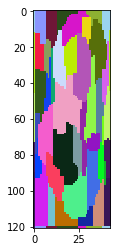

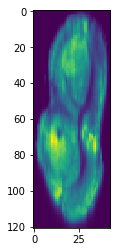

In [68]:
communities = [[1610,1611,1612,1653,1654,1655,1696,1697,1698,1738,1739,1740,1741,1775,1776,1781,1782,1783,1784,1818,1819,1820,1824,1825,1826,1827,1861,1862,1863,1864,1865,1867,1868,1869,1870,1904,1905,1906,1907,1908,1910,1911,1912,1913,1947,1948,1949,1950,1951,1952,1953,1954,1955,1956,1990,1991,1992,1993,1994,1995,1996,1997,1998,1999,2033,2034,2035,2036,2037,2038,2039,2040,2041,2042,2076,2077,2078,2079,2080,2081,2082,2083,2084,2085,2086,2119,2120,2121,2122,2123,2124,2125,2126,2127,2128,2129,2130,2162,2163,2164,2165,2166,2167,2168,2169,2170,2171,2172,2173,2174,2205,2206,2207,2208,2209,2210,2211,2212,2213,2214,2215,2216,2217,2218,2219,2247,2248,2249,2250,2251,2252,2253,2254,2255,2256,2257,2258,2259,2260,2261,2262,2290,2291,2292,2293,2294,2295,2296,2297,2298,2299,2300,2301,2302,2303,2304,2305,2333,2334,2335,2336,2337,2338,2339,2340,2341,2342,2343,2344,2345,2346,2347,2348,2376,2377,2378,2379,2380,2381,2382,2383,2384,2385,2386,2387,2388,2389,2390,2391,2419,2420,2421,2422,2423,2424,2425,2426,2427,2428,2429,2430,2431,2432,2433,2462,2463,2464,2465,2466,2467,2468,2469,2470,2471,2472,2473,2474,2475,2476,2505,2506,2507,2508,2509,2510,2511,2512,2513,2514,2515,2516,2517,2518,2519,2548,2549,2550,2551,2552,2553,2554,2555,2556,2557,2558,2559,2560,2561,2562,2591,2592,2593,2594,2595,2596,2597,2598,2599,2600,2601,2602,2603,2604,2605,2634,2635,2636,2637,2638,2639,2640,2641,2642,2643,2644,2645,2646,2647,2648,2677,2678,2679,2680,2681,2682,2683,2684,2685,2686,2687,2688,2689,2690,2691,2720,2721,2722,2723,2724,2725,2726,2729,2730,2731,2732,2733,2734,2763,2764,2765,2766,2767,2768,2769,2773,2774,2775,2776,2777,2806,2807,2808,2809,2810,2811,2812,2818,2819,2820,2849,2850,2851,2852,2853,2854,2855,2862,2863,2894,2895,2896,2897,2898,2905,2906,2937,2938,2939,2940,2941,2948,2949,2980,2981,2982,2983],[2727,2728,2770,2771,2772,2813,2814,2815,2816,2856,2857,2858,2859,2892,2893,2899,2900,2901,2902,2935,2936,2942,2943,2944,2945,2978,2979,2984,2985,2986,2987,2988,3021,3022,3023,3024,3025,3026,3027,3028,3029,3030,3031,3064,3065,3066,3067,3068,3069,3070,3071,3072,3073,3074,3107,3108,3109,3110,3111,3112,3113,3114,3115,3116,3117,3150,3151,3152,3153,3154,3155,3156,3157,3158,3159,3160,3193,3194,3195,3196,3197,3198,3199,3200,3201,3202,3203,3236,3237,3238,3239,3240,3241,3242,3243,3244,3245,3246,3279,3280,3281,3282,3283,3284,3285,3286,3287,3288,3289,3322,3323,3324,3325,3326,3327,3328,3329,3330,3331,3332,3365,3366,3367,3368,3369,3370,3371,3372,3373,3374,3375,3408,3409,3410,3411,3412,3413,3414,3415,3416,3417,3418,3451,3452,3453,3454,3455,3456,3457,3458,3459,3460,3461,3494,3495,3496,3497,3498,3499,3500,3501,3502,3503,3504,3537,3538,3539,3540,3541,3542,3543,3544,3545,3546,3547,3580,3581,3582,3583,3584,3585,3586,3587,3588,3589,3590,3623,3624,3625,3626,3627,3628,3629,3630,3631,3632,3633,3666,3667,3668,3669,3670,3671,3672,3673,3674,3675,3676,3709,3710,3711,3712,3713,3714,3715,3716,3717,3718,3719,3720,3753,3754,3755,3756,3757,3758,3759,3760,3761,3762,3763,3764,3797,3798,3799,3800,3801,3802,3803,3804,3805,3806,3807,3808,3842,3843,3844,3845,3846,3847,3848,3849,3850,3851,3885,3886,3887,3888,3889,3890,3891,3892,3893,3894,3928,3929,3930,3931,3932,3933,3934,3935,3936,3937,3971,3972,3973,3974,3975,3976,3977,3978,3979,3980,4016,4017,4018,4019,4020,4021,4022,4023,4059,4060,4061,4062,4063,4064,4065,4066,4102,4103,4104,4105,4106,4107,4108,4145,4146,4147,4148,4149,4150,4188,4189,4190,4191,4192],[626,627,628,669,670,671,712,713,714,715,716,755,756,757,758,759,760,798,799,800,801,802,803,841,842,843,844,845,846,884,885,886,887,888,889,890,927,928,929,930,931,932,933,970,971,972,973,974,975,976,1013,1014,1015,1016,1017,1018,1019,1020,1056,1057,1058,1059,1060,1061,1062,1063,1099,1100,1101,1102,1103,1104,1105,1106,1142,1143,1144,1145,1146,1147,1148,1149,1185,1186,1187,1188,1189,1190,1191,1192,1228,1229,1230,1231,1232,1233,1234,1235,1271,1272,1273,1274,1275,1276,1277,1278,1314,1315,1316,1317,1318,1319,1320,1321,1357,1358,1359,1360,1361,1362,1363,1364,1400,1401,1402,1403,1404,1405,1406,1407,1443,1444,1445,1446,1447,1448,1449,1450,1486,1487,1488,1489,1490,1491,1492,1493,1529,1530,1531,1532,1533,1534,1535,1536,1570,1571,1572,1573,1574,1575,1576,1577,1578,1579,1613,1614,1615,1616,1617,1618,1619,1620,1621,1622,1656,1657,1658,1659,1660,1661,1662,1663,1664,1665,1699,1700,1701,1702,1703,1704,1705,1706,1707,1708,1742,1743,1744,1745,1746,1747,1748,1749,1750,1751,1785,1786,1787,1788,1789,1790,1791,1792,1793,1794,1828,1829,1830,1831,1832,1833,1834,1835,1836,1837,1871,1872,1873,1874,1875,1876,1877,1878,1879,1880,1914,1915,1916,1917,1918,1919,1920,1921,1922,1957,1958,1959,1960,1961,1962,1963,1964,1965,2000,2001,2002,2003,2004,2005,2006,2007,2008,2043,2044,2045,2046,2047,2048,2049,2050,2087,2088,2089,2090,2091,2092,2093,2131,2132,2133,2134,2135,2136,2175,2176,2177,2178,2179,2220,2221],[3813,3856,3899,3939,3942,3982,3985,4024,4025,4026,4027,4028,4067,4068,4069,4070,4071,4109,4110,4111,4112,4113,4114,4151,4152,4153,4154,4155,4156,4157,4193,4194,4195,4196,4197,4198,4199,4200,4231,4232,4233,4234,4235,4236,4237,4238,4239,4240,4241,4242,4243,4274,4275,4276,4277,4278,4279,4280,4281,4282,4283,4284,4285,4286,4317,4318,4319,4320,4321,4322,4323,4324,4325,4326,4327,4328,4329,4360,4361,4362,4363,4364,4365,4366,4367,4368,4369,4370,4371,4372,4402,4403,4404,4405,4406,4407,4408,4409,4410,4411,4412,4413,4414,4415,4445,4446,4447,4448,4449,4450,4451,4452,4453,4454,4455,4456,4457,4458,4488,4489,4490,4491,4492,4493,4494,4495,4496,4497,4498,4499,4500,4501,4531,4532,4533,4534,4535,4536,4537,4538,4539,4540,4541,4542,4543,4544,4574,4575,4576,4577,4578,4579,4580,4581,4582,4583,4584,4585,4586,4587,4618,4619,4620,4621,4622,4623,4624,4625,4626,4627,4628,4629,4630,4661,4662,4663,4664,4665,4666,4667,4668,4669,4670,4671,4672,4673,4704,4705,4706,4707,4708,4709,4710,4711,4712,4713,4714,4715,4716,4747,4748,4749,4750,4751,4752,4753,4754,4755,4756,4757,4758,4759,4790,4791,4792,4793,4794,4795,4796,4797,4798,4799,4800,4801,4802,4833,4834,4835,4836,4837,4838,4839,4840,4841,4842,4843,4844,4845,4877,4878,4879,4880,4881,4882,4883,4884,4885,4886,4887,4888,4922,4923,4924,4925,4926,4927,4928,4929,4930,4965,4966,4967,4968,4969,4970,4971,4972,4973,5009,5010,5011,5012],[291,292,293,334,335,336,377,378,379,380,420,421,422,423,424,462,463,464,465,466,467,505,506,507,508,509,510,548,549,550,551,552,553,554,591,592,593,594,595,596,597,634,635,636,637,638,639,640,677,678,679,680,681,682,683,720,721,722,723,724,725,726,762,763,764,765,766,767,768,769,770,805,806,807,808,809,810,811,812,813,848,849,850,851,852,853,854,855,856,891,892,893,894,895,896,897,898,899,900,934,935,936,937,938,939,940,941,942,943,977,978,979,980,981,982,983,984,985,986,1021,1022,1023,1024,1025,1026,1027,1028,1029,1064,1065,1066,1067,1068,1069,1070,1071,1072,1107,1108,1109,1110,1111,1112,1113,1114,1115,1150,1152,1153,1154,1155,1156,1157,1158,1195,1196,1197,1198,1199,1200,1201,1238,1239,1240,1241,1242,1243,1244,1281,1282,1283,1284,1285,1286,1324,1325,1326,1327,1328,1329,1367,1368,1369,1370,1371,1372,1410,1411,1412,1413,1414,1415,1453,1454,1455,1456,1457,1458,1496,1497,1498,1499,1539,1540,1541,1542,1582,1583,1584,1585,1625,1626,1627,1628,1668,1669,1670,1671,1711,1712,1754,1797],[3703,3746,3747,3789,3790,3832,3833,3875,3876,3918,3919,3960,3961,3962,4003,4004,4005,4006,4043,4044,4045,4046,4047,4048,4049,4086,4087,4088,4089,4090,4091,4092,4129,4130,4131,4132,4133,4134,4135,4172,4173,4174,4175,4176,4177,4178,4215,4216,4217,4218,4219,4220,4221,4258,4259,4260,4261,4262,4263,4264,4301,4302,4303,4304,4305,4306,4307,4344,4345,4346,4347,4348,4349,4350,4387,4388,4389,4390,4391,4392,4393,4430,4431,4432,4433,4434,4435,4436,4473,4474,4475,4476,4477,4478,4479,4516,4517,4518,4519,4520,4521,4522,4559,4560,4561,4562,4563,4564,4565,4602,4603,4604,4605,4606,4607,4608,4645,4646,4647,4648,4649,4650,4651,4688,4689,4690,4691,4692,4693,4694,4731,4732,4733,4734,4735,4736,4737,4774,4775,4776,4777,4778,4779,4780,4817,4818,4819,4820,4821,4822,4823,4860,4861,4862,4863,4864,4865,4866,4903,4904,4905,4906,4907,4908,4909,4946,4947,4948,4949,4950,4951,4952,4989,4990,4991,4992,4993,4994,4995,5032,5033,5034,5035,5036,5037,5038,5075,5076,5077,5078,5079,5080,5081,5118,5119,5120,5121,5122,5123,5124,5161,5162,5163,5164,5165,5166,5167],[2289,2331,2332,2373,2374,2375,2416,2417,2418,2457,2458,2459,2460,2461,2500,2501,2502,2503,2504,2542,2543,2544,2545,2546,2547,2585,2586,2587,2588,2589,2590,2628,2629,2630,2631,2632,2633,2671,2672,2673,2674,2675,2676,2713,2714,2715,2716,2717,2718,2719,2755,2756,2757,2758,2759,2760,2761,2762,2798,2799,2800,2801,2802,2803,2804,2805,2841,2842,2843,2844,2845,2846,2847,2848,2884,2885,2886,2887,2888,2889,2890,2891,2927,2928,2929,2930,2931,2932,2933,2934,2970,2971,2972,2973,2974,2975,2976,2977,3013,3014,3015,3016,3017,3018,3019,3020,3056,3057,3058,3059,3060,3061,3062,3063,3099,3100,3101,3102,3103,3104,3105,3106,3142,3143,3144,3145,3146,3147,3148,3149,3185,3186,3187,3188,3189,3190,3191,3192,3228,3229,3230,3231,3232,3233,3234,3235,3271,3272,3273,3274,3275,3276,3277,3278,3314,3315,3316,3317,3318,3319,3320,3321,3357,3358,3359,3360,3361,3362,3363,3364,3400,3401,3402,3403,3404,3405,3406,3407,3443,3444,3445,3446,3449,3450,3486,3487,3488,3489,3493,3530,3531,3532,3573,3574,3575,3617,3618,3660,3661,3704],[1151,1193,1194,1236,1237,1279,1280,1322,1323,1365,1366,1408,1409,1451,1452,1494,1495,1537,1538,1580,1581,1623,1624,1666,1667,1709,1710,1752,1753,1795,1796,1838,1839,1840,1881,1882,1883,1923,1924,1925,1926,1966,1967,1968,1969,2009,2010,2011,2012,2051,2052,2053,2054,2055,2094,2095,2096,2097,2098,2137,2138,2139,2140,2141,2180,2181,2182,2183,2184,2223,2224,2225,2226,2227,2266,2267,2268,2269,2270,2309,2310,2311,2312,2313,2352,2353,2354,2355,2356,2395,2396,2397,2398,2399,2438,2439,2440,2441,2442,2481,2482,2483,2484,2485,2523,2524,2525,2526,2527,2528,2566,2567,2568,2569,2570,2571,2609,2610,2611,2612,2613,2614,2652,2653,2654,2655,2656,2657,2695,2696,2697,2698,2699,2700,2738,2739,2740,2741,2742,2743,2781,2782,2783,2784,2785,2786,2824,2825,2826,2827,2828,2829,2866,2867,2868,2869,2870,2871,2872,2909,2910,2911,2912,2913,2914,2915,2952,2953,2954,2955,2956,2957,2958,2995,2996,2997,2998,3001,3038,3039,3040,3041,3081,3082,3083,3084,3124,3125,3168,3211],[3384,3427,3428,3429,3430,3431,3432,3470,3471,3472,3473,3474,3475,3513,3514,3515,3516,3517,3518,3556,3557,3558,3559,3560,3561,3599,3600,3601,3602,3603,3604,3642,3643,3644,3645,3646,3647,3685,3686,3687,3688,3689,3690,3728,3729,3730,3731,3732,3733,3771,3772,3773,3774,3775,3776,3814,3815,3816,3817,3818,3819,3857,3858,3859,3860,3861,3862,3900,3901,3902,3903,3904,3905,3943,3944,3945,3946,3947,3948,3986,3987,3988,3989,3990,3991,4029,4030,4031,4032,4033,4034,4072,4073,4074,4075,4076,4077,4115,4116,4117,4118,4119,4120,4121,4158,4159,4160,4161,4162,4163,4164,4201,4202,4203,4204,4205,4206,4207,4244,4245,4246,4247,4248,4249,4250,4287,4288,4289,4290,4291,4292,4293,4330,4331,4332,4333,4334,4335,4336,4373,4374,4375,4376,4377,4378,4416,4417,4418,4419,4420,4421,4459,4460,4461,4462,4463,4502,4503,4504,4505,4506,4545,4546,4547,4548,4588,4589,4590,4591,4631,4632,4633,4634,4674,4675,4676,4677,4717,4718,4719,4760,4803],[530,531,573,574,616,617,658,659,660,701,702,703,744,745,746,786,787,788,789,829,830,831,832,872,873,874,875,914,915,916,917,918,919,957,958,959,960,961,962,1000,1001,1002,1003,1004,1005,1043,1044,1045,1046,1047,1048,1086,1087,1088,1089,1090,1091,1129,1130,1131,1132,1133,1134,1172,1173,1174,1175,1176,1177,1215,1216,1217,1218,1219,1220,1258,1259,1260,1261,1262,1263,1301,1302,1303,1304,1305,1306,1344,1345,1346,1347,1348,1349,1387,1388,1389,1390,1391,1392,1393,1430,1431,1432,1433,1434,1435,1436,1473,1474,1475,1476,1477,1478,1479,1516,1517,1518,1519,1520,1521,1522,1559,1560,1561,1562,1563,1564,1565,1602,1603,1604,1605,1606,1607,1608,1645,1646,1647,1648,1649,1650,1651,1689,1690,1691,1692,1693,1694,1732,1733,1734,1735,1736,1737,1777,1778,1779,1780,1821,1822,1823,1866,1909],[3447,3448,3490,3491,3492,3533,3534,3535,3536,3576,3577,3578,3579,3619,3620,3621,3622,3662,3663,3664,3665,3705,3706,3707,3708,3748,3749,3750,3751,3752,3791,3792,3793,3794,3795,3796,3834,3835,3836,3837,3838,3839,3840,3841,3877,3878,3879,3880,3881,3882,3883,3884,3920,3921,3922,3923,3924,3925,3926,3927,3963,3964,3965,3966,3967,3968,3969,3970,4007,4008,4009,4010,4011,4012,4013,4014,4015,4050,4051,4052,4053,4054,4055,4056,4057,4058,4093,4094,4095,4096,4097,4098,4099,4100,4101,4136,4137,4138,4139,4140,4141,4142,4143,4144,4180,4181,4182,4183,4184,4185,4186,4187,4223,4224,4225,4226,4227,4228,4229,4230,4267,4268,4269,4270,4271,4272,4273,4311,4312,4313,4314,4315,4316,4354,4355,4356,4357,4358,4359,4397,4398,4399,4400,4401,4441,4442,4443,4444,4484,4485,4486,4487,4528,4529,4530,4571,4572,4573],[25,26,27,28,68,69,70,71,111,112,113,114,150,151,152,153,154,155,156,157,158,192,193,194,195,196,197,198,199,200,201,202,234,235,236,237,238,239,240,241,277,278,279,280,281,282,283,284,319,320,321,322,323,324,325,326,327,362,363,364,365,366,367,368,369,370,404,405,406,407,408,409,410,411,412,413,446,447,448,449,450,451,452,453,454,455,456,489,490,491,492,493,494,495,496,497,498,499,532,533,534,535,536,537,538,539,540,541,542,575,576,577,578,579,580,581,582,583,584,585,618,619,620,621,622,623,624,625,661,662,663,664,665,666,667,704,705,706,707,708,747,748,749,750,790,791,792,793,833,834,835,876,877],[1463,1464,1465,1506,1507,1508,1509,1510,1511,1549,1550,1551,1552,1553,1554,1592,1593,1594,1595,1596,1597,1635,1636,1637,1638,1639,1640,1678,1679,1680,1681,1682,1683,1721,1722,1723,1724,1725,1726,1764,1765,1766,1767,1768,1769,1807,1808,1809,1810,1811,1812,1850,1851,1852,1853,1854,1855,1893,1894,1895,1896,1897,1898,1936,1937,1938,1939,1940,1941,1979,1980,1981,1982,1983,1984,2022,2023,2024,2025,2026,2027,2065,2066,2067,2068,2069,2070,2108,2109,2110,2111,2112,2113,2151,2152,2153,2154,2155,2194,2195,2196,2197,2198,2237,2238,2239,2240,2241,2280,2281,2282,2283,2284,2323,2324,2325,2326,2327,2366,2367,2368,2369,2370,2409,2410,2411,2412,2413,2452,2453,2454,2455,2456,2498,2499,2541,2584,2627,2670],[3913,3956,3999,4042,4082,4083,4084,4085,4125,4126,4127,4128,4168,4169,4170,4171,4211,4212,4213,4214,4253,4254,4255,4256,4257,4296,4297,4298,4299,4300,4339,4340,4341,4342,4343,4382,4383,4384,4385,4386,4425,4426,4427,4428,4429,4468,4469,4470,4471,4472,4511,4512,4513,4514,4515,4554,4555,4556,4557,4558,4597,4598,4599,4600,4601,4640,4641,4642,4643,4644,4683,4684,4685,4686,4687,4726,4727,4728,4729,4730,4769,4770,4771,4772,4773,4812,4813,4814,4815,4816,4855,4856,4857,4858,4859,4898,4899,4900,4901,4902,4941,4942,4943,4944,4945,4984,4985,4986,4987,4988,5027,5028,5029,5030,5031,5070,5071,5072,5073,5074,5113,5114,5115,5116,5117,5156,5157,5158,5159,5160,5199,5200,5201,5202,5203],[668,709,710,711,751,752,753,754,794,795,796,797,836,837,838,839,840,878,879,880,881,882,883,920,921,922,923,924,925,926,963,964,965,966,967,968,969,1006,1007,1008,1009,1010,1011,1012,1049,1050,1051,1052,1053,1054,1055,1092,1093,1094,1095,1096,1097,1098,1135,1136,1137,1138,1139,1140,1141,1178,1179,1180,1181,1182,1183,1184,1221,1222,1223,1224,1225,1226,1227,1264,1265,1266,1267,1268,1269,1270,1307,1308,1309,1310,1311,1312,1313,1350,1351,1352,1353,1354,1355,1356,1394,1395,1396,1397,1398,1399,1437,1438,1439,1440,1441,1442,1480,1481,1482,1483,1484,1485,1523,1524,1525,1526,1527,1528,1566,1567,1568,1569,1609,1652,1695],[1890,1933,1976,2019,2020,2021,2062,2063,2064,2104,2105,2106,2107,2147,2148,2149,2150,2190,2191,2192,2193,2233,2234,2235,2236,2276,2277,2278,2279,2319,2320,2321,2322,2361,2362,2363,2364,2365,2404,2405,2406,2407,2408,2447,2448,2449,2450,2451,2490,2491,2492,2493,2494,2533,2534,2535,2536,2537,2576,2577,2578,2579,2580,2619,2620,2621,2622,2623,2662,2663,2664,2665,2666,2705,2706,2707,2708,2709,2748,2749,2750,2751,2752,2791,2792,2793,2794,2795,2834,2835,2836,2837,2838,2877,2878,2879,2880,2881,2920,2921,2922,2923,2924,2963,2964,2965,2966,2967,3006,3007,3008,3009,3010,3049,3050,3051,3052,3053,3092,3093,3094,3095,3096,3135,3136,3138,3139],[4123,4166,4208,4209,4251,4252,4294,4295,4337,4338,4379,4380,4381,4422,4423,4424,4464,4465,4466,4467,4507,4508,4509,4510,4549,4550,4551,4552,4553,4592,4593,4594,4595,4596,4635,4636,4637,4638,4639,4678,4679,4680,4681,4682,4720,4721,4722,4723,4724,4725,4763,4764,4765,4766,4767,4768,4806,4807,4808,4809,4810,4811,4849,4850,4851,4852,4853,4854,4892,4893,4894,4895,4896,4897,4935,4936,4937,4938,4939,4940,4978,4979,4980,4981,4982,4983,5021,5022,5023,5024,5025,5026,5064,5065,5066,5067,5068,5069,5107,5108,5109,5110,5111,5112,5150,5151,5152,5153,5154,5155,5193,5194,5195,5196,5197,5198],[4527,4570,4613,4614,4615,4616,4617,4656,4657,4658,4659,4660,4699,4700,4701,4702,4703,4742,4743,4744,4745,4746,4785,4786,4787,4788,4789,4828,4829,4830,4831,4832,4871,4872,4873,4874,4875,4876,4914,4915,4916,4917,4918,4919,4920,4921,4957,4958,4959,4960,4961,4962,4963,4964,5000,5001,5002,5003,5004,5005,5006,5007,5008,5043,5044,5045,5046,5047,5048,5049,5050,5051,5052,5053,5054,5055,5086,5087,5088,5089,5090,5091,5092,5093,5094,5095,5096,5097,5098,5129,5130,5131,5132,5133,5134,5135,5136,5137,5138,5139,5140,5141,5172,5173,5174,5175,5176,5177,5178,5179,5180,5181,5182,5183,5184],[7,8,9,10,11,12,50,51,52,53,54,55,93,94,95,96,97,98,136,137,138,139,140,141,179,180,181,182,183,184,222,223,224,225,226,227,265,266,267,268,269,270,308,309,310,311,312,313,351,352,353,354,355,356,394,395,396,397,398,399,437,438,439,440,441,442,480,481,482,483,484,485,523,524,525,526,527,528,566,567,568,569,570,571,609,610,611,612,613,614,652,653,654,655,656,657,695,696,697,698,699,700,740,741,742,743,784,785,827,828,870,871,913],[2222,2263,2264,2265,2306,2307,2308,2349,2350,2351,2392,2393,2394,2434,2435,2436,2437,2477,2478,2479,2480,2520,2521,2522,2563,2564,2565,2606,2607,2608,2649,2650,2651,2692,2693,2694,2735,2736,2737,2778,2779,2780,2821,2822,2823,2864,2865,2907,2908,2950,2951,2993,2994,3036,3037,3079,3080,3122,3123,3166,3167,3209,3210,3252,3253,3254,3295,3296,3297,3338,3339,3340,3381,3382,3383,3424,3425,3426,3467,3468,3469,3510,3511,3512,3553,3554,3555,3596,3597,3598,3639,3640,3641,3682,3683,3684,3725,3726,3727,3768,3769,3770,3811,3812,3854,3855,3897,3898,3940,3941,3983,3984],[2817,2860,2861,2903,2904,2946,2947,2989,2990,2991,2992,3032,3033,3034,3035,3075,3076,3077,3078,3118,3119,3120,3121,3161,3162,3163,3164,3165,3204,3205,3206,3207,3208,3247,3248,3249,3250,3251,3290,3291,3292,3293,3294,3333,3334,3335,3336,3337,3376,3377,3378,3379,3380,3419,3420,3421,3422,3423,3462,3463,3464,3465,3466,3505,3506,3507,3508,3509,3548,3549,3550,3551,3552,3591,3592,3593,3594,3595,3634,3635,3636,3637,3638,3677,3678,3679,3680,3681,3721,3722,3723,3724,3765,3766,3767,3809,3810,3852,3853,3895,3896,3938,3981],[1,2,3,4,5,6,44,45,46,47,48,49,87,88,89,90,91,92,130,131,132,133,134,135,173,174,175,176,177,178,216,217,218,219,220,221,259,260,261,262,263,264,302,303,304,305,306,307,345,346,347,348,349,350,388,389,390,391,392,393,431,432,433,434,435,436,474,475,476,477,478,479,517,518,519,520,521,522,560,561,562,563,564,565,606,607,608,649,650,651,692,693,694,735,736,737,778,779,780,821,822,823],[1713,1714,1755,1756,1757,1798,1799,1800,1841,1842,1843,1884,1885,1886,1927,1928,1929,1970,1971,1972,2013,2014,2015,2056,2057,2058,2099,2100,2101,2142,2143,2144,2185,2186,2187,2228,2229,2230,2271,2272,2273,2274,2314,2315,2316,2317,2357,2358,2359,2360,2400,2401,2402,2403,2443,2444,2445,2446,2486,2487,2488,2489,2529,2530,2531,2532,2572,2573,2574,2575,2615,2616,2617,2658,2659,2660,2701,2702,2703,2744,2745,2746,2787,2788,2789,2830,2831,2832,2873,2874,2875,2916,2917,2918,2959,2960,2961,3004,3047,3090,3133,3176],[3137,3178,3179,3180,3181,3182,3221,3222,3223,3224,3225,3264,3265,3266,3267,3268,3307,3308,3309,3310,3311,3350,3351,3352,3353,3354,3393,3394,3395,3396,3397,3436,3437,3438,3439,3440,3479,3480,3481,3482,3483,3522,3523,3524,3525,3526,3565,3566,3567,3568,3569,3608,3609,3610,3611,3612,3651,3652,3653,3654,3655,3695,3696,3697,3698,3738,3739,3740,3741,3781,3782,3783,3784,3824,3825,3826,3827,3867,3868,3869,3870,3910,3911,3912,3953,3954,3955,3996,3997,3998,4039,4040,4041],[38,39,40,41,42,43,81,82,83,84,85,86,124,125,126,127,128,129,167,168,169,170,171,172,210,211,212,213,214,215,253,254,255,256,257,258,296,297,298,299,300,301,339,340,341,342,343,344,382,383,384,385,386,387,425,426,427,428,429,430,468,469,470,471,472,473,511,512,513,514,515,516,555,556,557,598,599,600,641,642,643,684,685,686,727,728,729,771,772,814,857],[603,604,605,646,647,648,689,690,691,732,733,734,775,776,777,818,819,820,861,862,863,864,865,904,905,906,907,908,947,948,949,950,951,990,991,992,993,994,1033,1034,1035,1036,1037,1076,1077,1078,1079,1080,1119,1120,1121,1122,1123,1162,1163,1164,1165,1166,1205,1206,1207,1208,1209,1248,1249,1250,1251,1252,1291,1292,1293,1294,1295,1334,1335,1336,1337,1338,1377,1378,1379,1380,1381,1420,1421,1422,1423,1424,1466,1467],[13,14,15,16,17,18,19,20,21,22,23,24,56,57,58,59,60,61,62,63,64,65,66,67,99,100,101,102,103,104,105,106,107,108,109,110,142,143,144,145,146,147,148,149,185,186,187,188,189,190,191,228,229,230,231,232,233,271,272,273,274,275,276,314,315,316,317,318,357,358,359,360,361,400,401,402,403,443,444,445,486,487,488,529,572,615],[4179,4222,4265,4266,4308,4309,4310,4351,4352,4353,4394,4395,4396,4437,4438,4439,4440,4480,4481,4482,4483,4523,4524,4525,4526,4566,4567,4568,4569,4609,4610,4611,4612,4652,4653,4654,4655,4695,4696,4697,4698,4738,4739,4740,4741,4781,4782,4783,4784,4824,4825,4826,4827,4867,4868,4869,4870,4910,4911,4912,4913,4953,4954,4955,4956,4996,4997,4998,4999,5039,5040,5041,5042,5082,5083,5084,5085,5125,5126,5127,5128,5168,5169,5170,5171],[815,858,901,944,987,1030,1073,1116,1159,1202,1245,1287,1288,1330,1331,1373,1374,1416,1417,1459,1460,1500,1501,1502,1503,1543,1544,1545,1546,1586,1587,1588,1589,1629,1630,1631,1632,1672,1673,1674,1675,1715,1716,1717,1718,1758,1759,1760,1761,1801,1802,1803,1804,1844,1845,1846,1847,1887,1888,1889,1930,1931,1932,1973,1974,1975,2016,2017,2018,2059,2060,2061,2102,2103,2145,2146,2188,2189,2231,2232,2275,2318],[1170,1213,1256,1299,1342,1385,1428,1471,1514,1555,1557,1598,1600,1641,1643,1684,1685,1686,1727,1728,1729,1770,1771,1772,1813,1814,1815,1856,1857,1858,1899,1900,1901,1942,1943,1944,1985,1986,1987,2028,2029,2030,2071,2072,2073,2114,2115,2116,2156,2157,2158,2159,2199,2200,2201,2202,2242,2243,2244,2245,2285,2286,2287,2288,2328,2329,2330,2371,2372,2414,2415],[558,559,601,602,644,645,687,688,730,731,773,774,816,817,859,860,902,903,945,946,988,989,1031,1032,1074,1075,1117,1118,1160,1161,1203,1204,1246,1247,1289,1290,1332,1333,1375,1376,1418,1419,1461,1462,1504,1505,1547,1548,1590,1591,1633,1634,1676,1677,1719,1720,1762,1763,1805,1806,1848,1849,1891,1892,1934,1935,1977,1978],[738,739,781,782,783,824,825,826,866,867,868,869,909,910,911,912,952,953,954,955,995,996,997,998,1038,1039,1040,1041,1081,1082,1083,1084,1124,1125,1126,1127,1167,1168,1169,1210,1211,1212,1253,1254,1255,1296,1297,1298,1339,1340,1341,1382,1383,1384,1425,1426,1427,1468,1469,1470,1512,1513,1556,1599,1642],[242,243,244,245,246,285,286,287,288,289,328,329,330,331,332,371,372,373,374,375,414,415,416,417,418,457,458,459,460,461,500,501,502,503,504,543,544,545,546,547,586,587,588,589,590,629,630,631,632,633,672,673,674,675,676,717,718,719,761,804,847],[2999,3000,3002,3003,3042,3043,3044,3045,3046,3085,3086,3087,3088,3089,3126,3127,3128,3129,3130,3131,3132,3169,3170,3171,3172,3173,3174,3175,3212,3213,3214,3215,3216,3217,3218,3255,3256,3257,3258,3259,3260,3261,3298,3299,3300,3301,3302,3303,3304,3341,3342,3343,3344,3345,3346,3347,3385,3386,3387,3388,3389],[3219,3262,3305,3306,3348,3349,3390,3391,3392,3433,3434,3435,3476,3477,3478,3519,3520,3521,3562,3563,3564,3605,3606,3607,3648,3649,3650,3691,3692,3693,3734,3735,3736,3777,3778,3779,3820,3821,3822,3863,3864,3865,3906,3907,3908,3949,3950,3951,3992,3993,3994,4035,4036,4037,4078,4079,4080,4122,4165],[4761,4762,4804,4805,4846,4847,4848,4889,4890,4891,4931,4932,4933,4934,4974,4975,4976,4977,5013,5014,5015,5016,5017,5018,5019,5020,5056,5057,5058,5059,5060,5061,5062,5063,5099,5100,5101,5102,5103,5104,5105,5106,5142,5143,5144,5145,5146,5147,5148,5149,5185,5186,5187,5188,5189,5190,5191,5192],[29,30,31,32,33,34,35,36,37,72,73,74,75,76,77,78,79,80,115,116,117,118,119,120,121,122,123,159,160,161,162,163,164,165,166,203,204,205,206,207,208,209,247,248,249,250,251,252,290,294,295,333,337,338,376,381,419],[3098,3141,3184,3227,3270,3313,3356,3399,3442,3484,3485,3527,3528,3529,3570,3571,3572,3613,3614,3615,3616,3656,3657,3658,3659,3699,3700,3701,3702,3742,3743,3744,3745,3785,3786,3787,3788,3828,3829,3830,3831,3871,3872,3873,3874,3914,3915,3916,3917,3957,3958,3959,4000,4001,4002],[956,999,1042,1085,1128,1171,1214,1257,1300,1343,1386,1429,1472,1515,1558,1601,1644,1687,1688,1730,1731,1773,1774,1816,1817,1859,1860,1902,1903,1945,1946,1988,1989,2031,2032,2074,2075,2117,2118,2160,2161,2203,2204,2246],[2495,2496,2497,2538,2539,2540,2581,2582,2583,2624,2625,2626,2667,2668,2669,2710,2711,2712,2753,2754,2796,2797,2839,2840,2882,2883,2925,2926,2968,2969,3011,3012,3054,3055,3097,3140,3183,3226,3269,3312,3355,3398,3441],[2618,2661,2704,2747,2790,2833,2876,2919,2962,3005,3048,3091,3134,3177,3220,3263],[3694,3737,3780,3823,3866,3909,3952,3995,4038,4081,4124,4167,4210]]
image = np.zeros((x,y,3))
for community in communities:
    color = np.random.randint(1, 255, 3)
    for pixel in community:
        image[pixel//y-1,pixel%y,:] = color
image = image.astype(int)
image
plt.imshow(image)
plt.show()
plt.imshow(data['img'][np.argmax(data['img'][:,20,20]),:,:])
plt.show()

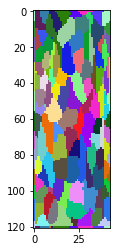

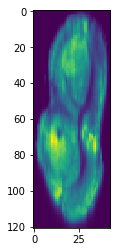

In [69]:
communities = [[4113,4155,4156,4157,4199,4200,4242,4243,4284,4285,4286,4289,4290,4327,4328,4329,4330,4331,4332,4333,4371,4372,4373,4374,4375,4376,4377,4378,4414,4415,4416,4417,4418,4419,4420,4421,4457,4458,4459,4460,4461,4462,4463,4464,4500,4501,4502,4503,4504,4505,4506,4543,4544,4545,4546,4547,4548,4549,4586,4587,4588,4589,4590,4591,4592,4629,4630,4631,4632,4633,4634,4635,4672,4673,4674,4675,4676,4677,4715,4716,4717,4718,4719,4720,4758,4759,4760,4761,4762,4763,4801,4802,4803,4805,4806,4845,4846,4849],[235,236,277,278,279,280,320,321,322,323,362,363,364,365,366,404,405,406,407,408,409,446,447,448,449,450,451,452,488,489,490,491,492,493,494,495,530,531,532,533,534,535,536,537,538,573,574,575,576,577,578,579,580,581,616,617,618,619,620,621,622,623,624,658,659,660,661,662,663,664,665,701,702,703,704,705,706,707,708,744,745,746,747,748,749,750,788,789,790,791,792,832,833,834,875,876,919],[835,836,877,878,879,920,921,922,923,962,963,964,965,966,1005,1006,1007,1008,1009,1048,1049,1050,1051,1052,1091,1092,1093,1094,1095,1134,1135,1136,1137,1138,1177,1178,1179,1180,1181,1182,1220,1221,1222,1223,1224,1225,1263,1264,1265,1266,1267,1268,1306,1307,1308,1309,1310,1311,1349,1350,1351,1352,1353,1354,1355,1392,1393,1394,1395,1396,1397,1398,1435,1436,1437,1438,1439,1440,1441,1478,1479,1480,1481,1482,1483,1484,1522,1523,1524,1525,1526,1527,1567,1568,1569],[3545,3546,3547,3548,3549,3550,3588,3589,3590,3591,3592,3593,3594,3631,3632,3633,3634,3635,3636,3674,3675,3676,3677,3678,3679,3717,3718,3719,3720,3721,3722,3760,3761,3762,3763,3764,3765,3803,3804,3805,3806,3807,3808,3809,3846,3847,3848,3849,3850,3851,3852,3889,3890,3891,3892,3893,3894,3895,3932,3933,3934,3935,3936,3937,3938,3975,3976,3977,3978,3979,3980,3981,4018,4019,4020,4021,4022,4023,4060,4061,4062,4063,4064,4065,4066,4103,4104,4105,4106,4107,4108,4147,4148,4149,4150],[2383,2384,2426,2427,2428,2429,2430,2431,2468,2469,2470,2471,2472,2473,2474,2475,2510,2511,2512,2513,2514,2515,2516,2517,2518,2553,2554,2555,2556,2557,2558,2559,2560,2561,2596,2597,2598,2599,2600,2601,2602,2603,2604,2638,2639,2640,2641,2642,2643,2644,2645,2646,2680,2681,2682,2683,2684,2685,2686,2687,2688,2689,2723,2724,2725,2726,2727,2728,2729,2730,2731,2732,2766,2767,2768,2769,2770,2771,2772,2773,2774,2810,2811,2812,2813,2814,2815,2816,2854,2855,2859,2898],[2482,2523,2524,2525,2565,2566,2567,2568,2569,2608,2609,2610,2611,2612,2651,2652,2653,2654,2655,2656,2694,2695,2696,2697,2698,2699,2737,2738,2739,2740,2741,2742,2780,2781,2782,2783,2784,2785,2823,2824,2825,2826,2827,2865,2866,2867,2868,2869,2870,2908,2909,2910,2911,2912,2913,2951,2952,2953,2954,2955,2956,2994,2995,2996,2997,2998,3037,3038,3039,3040,3041,3081,3082,3083,3084,3124,3125,3126,3167,3168,3169,3170,3210,3211,3212,3213,3254,3255,3256,3297,3298,3299],[3024,3025,3026,3067,3068,3069,3070,3109,3110,3111,3112,3113,3152,3153,3154,3155,3156,3193,3194,3195,3196,3197,3198,3199,3236,3237,3238,3239,3240,3241,3242,3279,3280,3281,3282,3283,3284,3285,3322,3323,3324,3325,3326,3327,3328,3365,3366,3367,3368,3369,3370,3371,3372,3408,3409,3410,3411,3412,3413,3414,3415,3451,3452,3453,3454,3455,3456,3457,3458,3493,3494,3495,3496,3497,3498,3499,3500,3501,3536,3537,3538,3539,3540,3541,3542,3543,3544,3580,3581,3582,3583,3623],[2500,2542,2543,2544,2585,2586,2587,2628,2629,2630,2671,2672,2673,2674,2714,2715,2716,2717,2718,2719,2757,2758,2759,2760,2761,2762,2800,2801,2802,2803,2804,2805,2844,2845,2846,2847,2848,2887,2888,2889,2890,2891,2930,2931,2932,2933,2934,2974,2975,2976,2977,3017,3018,3019,3020,3060,3061,3062,3063,3103,3104,3105,3106,3146,3147,3148,3149,3189,3190,3191,3192,3232,3233,3234,3235,3275,3276,3277,3278,3319,3320,3321,3362,3363,3364,3405,3406,3407,3449,3450],[1528,1570,1571,1572,1573,1611,1612,1613,1614,1615,1616,1655,1656,1657,1658,1659,1660,1698,1699,1700,1701,1702,1703,1741,1742,1743,1744,1745,1746,1785,1786,1787,1788,1789,1828,1829,1830,1831,1832,1833,1871,1872,1873,1874,1875,1876,1914,1915,1916,1917,1918,1919,1957,1958,1959,1960,1961,1962,2001,2002,2003,2004,2005,2044,2045,2046,2047,2048,2049,2087,2088,2089,2090,2091,2092,2131,2132,2133,2134,2135,2175,2176,2177,2178,2179,2219,2220,2221,2263],[4577,4620,4621,4622,4663,4664,4665,4666,4667,4668,4669,4670,4706,4707,4708,4709,4710,4711,4712,4713,4714,4749,4750,4751,4752,4753,4754,4755,4756,4757,4791,4792,4793,4794,4795,4796,4797,4798,4799,4800,4834,4835,4836,4837,4838,4839,4840,4841,4842,4843,4844,4877,4878,4879,4880,4881,4882,4883,4884,4885,4886,4887,4888,4920,4921,4922,4923,4924,4925,4926,4927,4928,4929,4930,4964,4965,4966,4967,4968,4969,4970,4971,4972,5008,5010,5011,5012,5013,5014],[3584,3585,3586,3587,3624,3625,3626,3627,3628,3629,3630,3666,3667,3668,3669,3670,3671,3672,3673,3709,3710,3711,3712,3713,3714,3715,3716,3752,3753,3754,3755,3756,3757,3758,3759,3795,3796,3797,3798,3799,3800,3801,3802,3838,3839,3840,3841,3842,3843,3844,3845,3881,3882,3883,3884,3885,3886,3887,3888,3925,3926,3927,3928,3929,3930,3931,3968,3969,3970,3971,3972,3973,3974,4011,4012,4013,4014,4015,4016,4017,4055,4056,4057,4058,4059,4102],[4109,4151,4152,4153,4192,4193,4194,4195,4196,4197,4198,4235,4236,4237,4238,4239,4240,4241,4278,4279,4280,4281,4282,4283,4320,4321,4322,4323,4324,4325,4326,4363,4364,4365,4366,4367,4368,4369,4370,4406,4407,4408,4409,4410,4411,4412,4413,4449,4450,4451,4452,4453,4454,4455,4456,4492,4493,4494,4495,4496,4497,4498,4499,4535,4536,4537,4538,4539,4540,4541,4542,4578,4579,4580,4581,4582,4583,4584,4585,4623,4624,4625,4626,4627,4628,4671],[2160,2161,2203,2204,2205,2246,2247,2248,2249,2288,2289,2290,2291,2292,2331,2332,2333,2334,2335,2336,2372,2373,2374,2375,2376,2377,2378,2379,2415,2416,2417,2418,2419,2420,2421,2422,2423,2457,2458,2459,2460,2461,2462,2463,2464,2465,2466,2501,2502,2503,2504,2505,2506,2507,2508,2509,2545,2546,2547,2548,2549,2550,2551,2552,2588,2589,2590,2591,2592,2593,2594,2595,2631,2632,2633,2634,2635,2636,2637,2675,2676,2677,2678,2679,2722],[3036,3079,3080,3122,3123,3165,3166,3208,3209,3251,3252,3253,3294,3295,3296,3337,3338,3339,3340,3380,3381,3382,3383,3423,3424,3425,3466,3467,3468,3509,3510,3511,3552,3553,3554,3595,3596,3597,3637,3638,3639,3640,3680,3681,3682,3683,3723,3724,3725,3726,3766,3767,3768,3769,3810,3811,3812,3853,3854,3855,3896,3897,3898,3939,3940,3941,3982,3983,3984,4024,4025,4026,4027,4067,4068,4069,4070,4110,4111,4112,4154],[3447,3448,3490,3491,3492,3532,3533,3534,3535,3575,3576,3577,3578,3579,3617,3618,3619,3620,3621,3622,3660,3661,3662,3663,3664,3665,3703,3704,3705,3706,3707,3708,3747,3748,3749,3750,3751,3790,3791,3792,3793,3794,3834,3835,3836,3837,3877,3878,3879,3880,3920,3921,3922,3923,3924,3964,3965,3966,3967,4007,4008,4009,4010,4050,4051,4052,4053,4093,4094,4095,4096,4137,4138,4139,4180,4181,4223,4224,4267],[541,542,582,583,584,585,625,626,627,628,629,666,667,668,669,670,671,672,709,710,711,712,713,714,715,751,752,753,754,755,756,757,758,793,794,795,796,797,798,799,800,801,837,838,839,840,841,842,843,844,880,881,882,883,884,885,886,887,924,925,926,927,928,929,930,967,968,969,970,971,1010,1011,1012,1053,1054,1096,1139],[291,292,334,335,336,377,378,379,419,420,421,422,423,462,463,464,465,466,467,468,505,506,507,508,509,510,511,548,549,550,551,552,553,554,591,592,593,594,595,596,597,634,635,636,637,638,639,640,677,678,679,680,681,682,721,722,723,724,725,764,765,766,767,807,808,809,810,850,851,852,893,894,895,936,937],[1653,1654,1696,1697,1740,1783,1784,1826,1827,1869,1870,1912,1913,1955,1956,1998,1999,2000,2041,2042,2043,2084,2085,2086,2127,2128,2129,2130,2169,2170,2171,2172,2173,2174,2212,2213,2214,2215,2216,2217,2218,2255,2256,2257,2258,2259,2260,2261,2262,2298,2299,2300,2301,2302,2303,2304,2305,2341,2342,2343,2344,2345,2346,2347,2348,2385,2386,2387,2388,2389,2390,2432,2433,2476],[1738,1739,1781,1782,1824,1825,1864,1865,1866,1867,1868,1907,1908,1909,1910,1911,1950,1951,1952,1953,1954,1993,1994,1995,1996,1997,2036,2037,2038,2039,2040,2078,2079,2080,2081,2082,2083,2121,2122,2123,2124,2125,2126,2164,2165,2166,2167,2168,2206,2207,2208,2209,2210,2211,2250,2251,2252,2253,2254,2293,2294,2295,2296,2297,2337,2338,2339,2340,2380,2381,2382,2424,2425,2467],[3732,3775,3776,3817,3818,3819,3822,3860,3861,3862,3864,3865,3903,3904,3905,3906,3907,3908,3946,3947,3948,3949,3950,3951,3988,3989,3990,3991,3992,3993,3994,4032,4033,4034,4035,4036,4037,4075,4076,4077,4078,4079,4080,4118,4119,4120,4121,4122,4123,4161,4162,4163,4164,4165,4166,4204,4205,4206,4207,4208,4209,4247,4248,4249,4250,4251,4252,4291,4292,4293,4294,4334,4335,4336],[4701,4702,4744,4745,4746,4787,4788,4789,4830,4831,4832,4833,4873,4874,4875,4876,4916,4917,4918,4919,4959,4960,4961,4962,4963,5001,5002,5003,5004,5005,5006,5007,5044,5045,5046,5047,5048,5049,5050,5051,5086,5087,5088,5089,5090,5091,5092,5093,5094,5128,5129,5130,5131,5132,5133,5134,5135,5136,5137,5138,5169,5170,5171,5172,5173,5174,5175,5176,5177,5178,5179,5180,5181],[2713,2756,2799,2842,2843,2885,2886,2927,2928,2929,2970,2971,2972,2973,3013,3014,3015,3016,3056,3057,3058,3059,3099,3100,3101,3102,3142,3143,3144,3145,3185,3186,3187,3188,3228,3229,3230,3231,3271,3272,3273,3274,3314,3315,3316,3317,3318,3357,3358,3359,3360,3361,3400,3401,3402,3403,3404,3443,3444,3445,3446,3486,3487,3488,3489,3530,3531,3573,3574,3616],[972,973,1013,1014,1015,1016,1055,1056,1057,1058,1059,1097,1098,1099,1100,1101,1102,1140,1141,1142,1143,1144,1145,1183,1184,1185,1186,1187,1188,1226,1227,1228,1229,1230,1231,1269,1270,1271,1272,1273,1274,1312,1313,1314,1315,1316,1317,1356,1357,1358,1359,1399,1400,1401,1402,1442,1443,1444,1445,1485,1486,1487,1488,1529,1530,1531],[2856,2857,2858,2899,2900,2901,2902,2903,2941,2942,2943,2944,2945,2946,2947,2984,2985,2986,2987,2988,2989,2990,3027,3028,3029,3030,3031,3032,3033,3071,3072,3073,3074,3075,3076,3114,3115,3116,3117,3118,3119,3157,3158,3159,3160,3161,3200,3201,3202,3203,3243,3244,3245,3246,3286,3287,3288,3289,3329,3330,3331,3373,3374,3416,3459,3502],[199,200,238,239,240,241,242,243,244,281,282,283,284,285,286,287,288,324,325,326,327,328,329,330,331,367,368,369,370,371,372,373,374,410,411,412,413,414,415,416,417,453,454,455,456,457,458,459,460,496,497,498,499,500,501,502,503,539,540,543,544,545,586,587],[1968,2011,2054,2056,2097,2098,2099,2140,2141,2142,2183,2184,2185,2225,2226,2227,2228,2268,2269,2270,2271,2272,2311,2312,2313,2314,2315,2354,2355,2356,2357,2358,2396,2397,2398,2399,2400,2401,2439,2440,2441,2442,2443,2444,2483,2484,2485,2486,2487,2526,2527,2528,2529,2530,2570,2571,2572,2573,2613,2614,2615,2616,2657],[3257,3258,3300,3301,3341,3342,3343,3344,3345,3384,3385,3386,3387,3388,3389,3427,3428,3429,3430,3431,3470,3471,3472,3473,3474,3513,3514,3515,3516,3517,3556,3557,3558,3559,3560,3599,3600,3601,3602,3603,3642,3643,3644,3645,3646,3685,3686,3687,3688,3689,3729,3730,3731,3772,3773,3774,3815,3816,3859,3902,3945],[4054,4097,4098,4099,4100,4101,4140,4141,4142,4143,4144,4182,4183,4184,4185,4186,4187,4225,4226,4227,4228,4229,4230,4268,4269,4270,4271,4272,4273,4311,4312,4313,4314,4315,4316,4354,4355,4356,4357,4358,4359,4397,4398,4399,4400,4401,4440,4441,4442,4443,4444,4484,4485,4486,4487,4527,4528,4529,4571,4572],[4555,4556,4557,4558,4597,4598,4599,4600,4601,4640,4641,4642,4643,4644,4683,4684,4685,4686,4687,4726,4727,4728,4729,4730,4769,4770,4771,4772,4773,4812,4813,4814,4815,4816,4855,4856,4857,4858,4859,4898,4899,4900,4901,4902,4941,4942,4943,4944,4945,4984,4985,4986,4987,4988,5028,5029,5030,5031,5072,5073],[4569,4570,4612,4613,4654,4655,4656,4657,4697,4698,4699,4700,4740,4741,4742,4743,4782,4783,4784,4785,4786,4825,4826,4827,4828,4829,4868,4869,4870,4871,4872,4910,4911,4912,4913,4914,4915,4953,4954,4955,4956,4957,4958,4996,4997,4998,4999,5000,5038,5039,5040,5041,5042,5043,5082,5083,5084,5085,5126,5127],[1232,1233,1275,1276,1277,1318,1319,1320,1321,1360,1361,1362,1363,1364,1403,1404,1405,1406,1407,1408,1446,1447,1448,1449,1450,1451,1489,1490,1491,1492,1493,1494,1532,1533,1534,1535,1536,1537,1574,1575,1576,1577,1578,1579,1617,1618,1619,1620,1621,1622,1661,1662,1663,1664,1665,1704,1705,1747,1790],[4145,4146,4188,4189,4190,4191,4231,4232,4233,4234,4274,4275,4276,4277,4317,4318,4319,4360,4361,4362,4402,4403,4404,4405,4445,4446,4447,4448,4488,4489,4490,4491,4530,4531,4532,4533,4534,4573,4574,4575,4576,4614,4615,4616,4617,4618,4619,4658,4659,4660,4661,4662,4703,4704,4705,4747,4748,4790],[2391,2434,2477,2519,2520,2521,2562,2563,2564,2605,2606,2607,2647,2648,2649,2650,2690,2691,2692,2693,2733,2734,2735,2736,2775,2776,2777,2778,2779,2817,2818,2819,2820,2821,2822,2860,2861,2862,2863,2864,2904,2905,2906,2907,2948,2949,2950,2991,2992,2993,3034,3035,3077,3078,3121],[11,12,13,14,15,16,17,18,19,55,56,57,58,59,60,61,62,99,100,101,102,103,104,105,106,143,144,145,146,147,148,149,186,187,188,189,190,191,230,231,232,233,234,273,274,275,276,317,318,319,360,361,403],[10,52,53,54,95,96,97,98,139,140,141,142,182,183,184,185,225,226,227,228,229,269,270,271,272,312,313,314,315,316,355,356,357,358,359,398,399,400,401,402,441,442,443,444,445,485,486,487,528,529,572,615],[137,138,180,181,223,224,265,266,267,268,308,309,310,311,351,352,353,354,394,395,396,397,437,438,439,440,480,481,482,483,484,523,524,525,526,527,566,567,568,569,570,571,610,611,612,613,614,654,655,656,657,699],[4394,4395,4436,4437,4438,4439,4479,4480,4481,4482,4483,4521,4522,4523,4524,4525,4526,4564,4565,4566,4567,4568,4607,4608,4609,4610,4611,4650,4651,4652,4653,4693,4694,4695,4696,4736,4737,4738,4739,4779,4780,4781,4822,4823,4824,4865,4866,4867,4908,4909,4952,4995],[4807,4808,4809,4810,4850,4851,4852,4853,4892,4893,4894,4895,4896,4934,4935,4936,4937,4938,4939,4977,4978,4979,4980,4981,4982,5020,5021,5022,5023,5024,5025,5063,5064,5065,5066,5067,5068,5106,5107,5108,5109,5110,5149,5150,5151,5152,5153,5192,5193,5194,5195],[872,915,958,1001,1002,1044,1045,1087,1088,1129,1130,1131,1132,1172,1173,1174,1175,1215,1216,1217,1218,1258,1259,1260,1261,1301,1302,1303,1304,1344,1345,1346,1347,1387,1388,1389,1390,1430,1431,1432,1473,1474,1475,1516,1517,1518,1559,1560,1602,1603],[1,2,3,44,45,46,87,88,89,130,131,132,173,174,175,216,217,218,219,259,260,261,262,302,303,304,305,345,346,347,348,349,388,389,390,391,392,393,431,432,433,434,435,436,476,477,478,479],[1433,1434,1476,1477,1519,1520,1521,1561,1562,1563,1564,1565,1566,1604,1605,1606,1607,1608,1609,1610,1646,1647,1648,1649,1650,1651,1652,1689,1690,1691,1692,1693,1694,1695,1732,1733,1734,1735,1736,1737,1776,1777,1778,1779,1780,1821,1822,1823],[1936,1937,1938,1939,1940,1979,1980,1981,1982,1983,1984,2022,2023,2024,2025,2026,2027,2065,2066,2067,2068,2069,2070,2108,2109,2110,2111,2112,2113,2151,2152,2153,2154,2155,2194,2195,2196,2197,2198,2238,2239,2240,2241,2282,2283,2284,2325,2326],[3426,3469,3512,3555,3598,3641,3684,3727,3728,3770,3771,3813,3814,3856,3857,3858,3899,3900,3901,3942,3943,3944,3985,3986,3987,4028,4029,4030,4031,4071,4072,4073,4074,4114,4115,4116,4117,4158,4159,4160,4201,4202,4203,4244,4245,4246,4287,4288],[4220,4262,4263,4264,4304,4305,4306,4307,4345,4346,4347,4348,4349,4350,4387,4388,4389,4390,4391,4392,4393,4430,4431,4432,4433,4434,4435,4473,4474,4475,4476,4477,4478,4516,4517,4518,4519,4520,4559,4560,4561,4562,4563,4602,4603,4604,4605,4606],[4804,4847,4848,4889,4890,4891,4931,4932,4933,4973,4974,4975,4976,5015,5016,5017,5018,5019,5056,5057,5058,5059,5060,5061,5062,5099,5100,5101,5102,5103,5104,5105,5141,5142,5143,5144,5145,5146,5147,5148,5184,5185,5186,5187,5188,5189,5190,5191],[39,40,41,42,43,82,83,84,85,86,124,125,126,127,128,129,167,168,169,170,171,172,210,211,212,213,214,215,253,254,255,256,257,258,296,297,298,299,300,339,340,341,342,382,383,425,426],[546,588,589,630,631,632,673,674,675,716,717,718,759,760,761,802,803,804,845,846,847,888,889,890,931,932,933,974,975,976,1017,1018,1019,1060,1061,1062,1103,1104,1105,1146,1147,1148,1189,1190,1191,1234],[1728,1771,1772,1813,1814,1815,1856,1857,1858,1899,1900,1901,1942,1943,1944,1985,1986,1987,2028,2029,2030,2031,2071,2072,2073,2074,2114,2115,2116,2117,2156,2157,2158,2159,2199,2200,2201,2202,2242,2243,2244,2245,2286,2287,2329,2330],[3120,3162,3163,3164,3204,3205,3206,3207,3247,3248,3249,3250,3290,3291,3292,3293,3332,3333,3334,3335,3336,3375,3376,3377,3378,3379,3417,3418,3419,3420,3421,3422,3460,3461,3462,3463,3464,3465,3503,3504,3505,3506,3507,3508,3551],[642,684,685,686,687,688,727,728,729,730,731,771,772,773,774,814,815,816,817,857,858,859,860,901,902,903,944,945,946,987,988,989,1030,1031,1032,1073,1074,1075,1117,1118,1160,1161,1204,1247],[1411,1413,1454,1455,1456,1457,1497,1498,1499,1500,1540,1541,1542,1543,1583,1584,1585,1586,1626,1627,1628,1629,1669,1670,1671,1712,1713,1714,1755,1756,1757,1798,1799,1800,1841,1842,1843,1884,1885,1927,1928,1970,1971,2013],[1844,1886,1887,1929,1930,1972,1973,1974,2014,2015,2016,2057,2058,2059,2100,2101,2102,2143,2144,2145,2186,2187,2188,2229,2230,2231,2273,2274,2316,2317,2318,2359,2360,2402,2403,2445,2446,2488,2489,2531,2532,2574,2575,2617],[2834,2877,2878,2879,2920,2921,2922,2923,2924,2963,2964,2965,2966,2967,3006,3007,3008,3009,3010,3049,3050,3051,3052,3053,3092,3093,3094,3095,3096,3136,3137,3138,3139,3179,3180,3181,3182,3223,3224,3225,3267,3268,3310,3311],[653,695,696,697,738,739,740,741,780,781,782,783,784,823,824,825,826,827,866,867,868,869,870,908,909,910,911,912,913,951,952,953,954,955,956,994,995,996,997,998,1038,1041,1084],[1151,1194,1237,1280,1323,1324,1366,1367,1409,1410,1452,1453,1495,1496,1538,1539,1580,1581,1582,1623,1624,1625,1666,1667,1668,1709,1710,1711,1752,1753,1754,1795,1796,1797,1839,1840,1882,1883,1925,1926,1969,2012,2055],[4645,4646,4647,4648,4649,4688,4689,4690,4691,4692,4731,4732,4733,4734,4735,4774,4775,4776,4777,4778,4817,4818,4819,4820,4821,4860,4861,4862,4863,4864,4903,4904,4905,4906,4946,4947,4948,4989,4990,5032,5033,5075,5118],[33,34,35,36,37,38,76,77,78,79,80,81,118,119,120,121,122,123,161,162,163,164,165,166,205,206,207,208,209,248,249,250,251,252,293,294,295,337,338,380,381,424],[1967,2010,2052,2053,2095,2096,2137,2138,2139,2180,2181,2182,2222,2223,2224,2264,2265,2266,2267,2306,2307,2308,2309,2310,2349,2350,2351,2352,2353,2392,2393,2394,2395,2435,2436,2437,2438,2478,2479,2480,2481,2522],[2720,2721,2763,2764,2765,2806,2807,2808,2809,2849,2850,2851,2852,2853,2892,2893,2894,2895,2896,2897,2935,2936,2937,2938,2939,2940,2978,2979,2980,2981,2982,2983,3021,3022,3023,3064,3065,3066,3107,3108,3150,3151],[3348,3390,3391,3392,3432,3433,3434,3435,3475,3476,3477,3478,3518,3519,3520,3521,3561,3562,3563,3564,3604,3605,3606,3607,3647,3648,3649,3650,3690,3691,3692,3693,3733,3734,3735,3736,3777,3778,3779,3820,3821,3863],[4337,4379,4380,4422,4423,4465,4466,4507,4508,4509,4550,4551,4552,4593,4594,4595,4636,4637,4638,4639,4678,4679,4680,4681,4682,4721,4722,4723,4724,4725,4764,4765,4766,4767,4768,4811,4854,4897,4940,4983,5026],[770,813,856,898,899,900,941,942,943,984,985,986,1027,1028,1029,1070,1071,1072,1113,1114,1115,1116,1156,1157,1158,1159,1199,1200,1201,1243,1244,1286,1287,1329,1330,1372,1373,1415,1458,1501],[938,980,981,1023,1024,1066,1067,1068,1109,1110,1111,1112,1152,1153,1154,1155,1195,1196,1197,1198,1238,1239,1240,1241,1242,1281,1282,1283,1284,1285,1325,1326,1327,1328,1368,1369,1370,1371,1412,1414],[1706,1707,1708,1748,1749,1750,1751,1791,1792,1793,1794,1834,1835,1836,1837,1838,1877,1878,1879,1880,1881,1920,1921,1922,1923,1924,1963,1964,1965,1966,2006,2007,2008,2009,2050,2051,2093,2094,2136],[2495,2496,2538,2539,2540,2581,2582,2583,2584,2624,2625,2626,2627,2667,2668,2669,2670,2710,2711,2712,2753,2754,2755,2796,2797,2798,2839,2840,2841,2882,2883,2884,2925,2926,2968,2969,3011,3012,3055],[633,676,719,720,762,763,805,806,848,849,891,892,934,935,977,978,979,1020,1021,1022,1063,1064,1065,1106,1107,1108,1149,1150,1192,1193,1235,1236,1278,1279,1322,1365],[1039,1040,1081,1082,1083,1124,1125,1126,1127,1167,1168,1169,1170,1209,1210,1211,1212,1252,1253,1254,1255,1295,1296,1297,1298,1338,1339,1340,1341,1381,1382,1383,1384,1425,1426,1468],[1775,1817,1818,1819,1820,1860,1861,1862,1863,1902,1903,1904,1905,1906,1945,1946,1947,1948,1949,1988,1989,1990,1991,1992,2032,2033,2034,2035,2075,2076,2077,2118,2119,2120,2162,2163],[2999,3000,3042,3043,3044,3045,3046,3085,3086,3087,3088,3089,3127,3128,3129,3130,3131,3132,3171,3172,3173,3174,3175,3214,3215,3216,3217,3218,3259,3260,3261,3302,3303,3304,3346,3347],[907,949,950,990,991,992,993,1033,1034,1035,1036,1037,1076,1077,1078,1079,1080,1119,1120,1121,1122,1123,1162,1163,1164,1165,1166,1205,1206,1207,1208,1248,1249,1250,1251],[2658,2659,2660,2700,2701,2702,2703,2743,2744,2745,2746,2786,2787,2788,2789,2828,2829,2830,2831,2832,2871,2872,2873,2874,2914,2915,2916,2917,2957,2958,2959,2960,3001,3002,3003],[3528,3529,3571,3572,3613,3614,3615,3656,3657,3658,3659,3699,3700,3701,3702,3742,3743,3744,3745,3785,3786,3787,3788,3828,3829,3830,3831,3871,3872,3873,3874,3914,3915,3916,3958],[1203,1246,1289,1290,1332,1333,1375,1376,1418,1419,1461,1462,1504,1505,1547,1548,1590,1591,1633,1634,1676,1677,1719,1720,1762,1763,1805,1806,1848,1849,1891,1892,1934,1935],[3746,3789,3832,3833,3875,3876,3917,3918,3919,3959,3960,3961,3962,3963,4002,4003,4004,4005,4006,4046,4047,4048,4049,4090,4091,4092,4134,4135,4136,4177,4178,4179,4221,4222],[474,475,517,518,560,561,603,604,646,647,648,689,690,691,732,733,734,775,776,777,818,819,820,821,861,862,863,864,904,905,906,947,948],[2451,2493,2494,2536,2537,2578,2579,2580,2621,2622,2623,2663,2664,2665,2666,2706,2707,2708,2709,2749,2750,2751,2752,2792,2793,2794,2795,2835,2836,2837,2838,2880,2881],[3957,4000,4001,4043,4044,4045,4086,4087,4088,4089,4129,4130,4131,4132,4133,4172,4173,4174,4175,4176,4215,4216,4217,4218,4219,4258,4259,4260,4261,4301,4302,4303,4344],[4907,4949,4950,4951,4991,4992,4993,4994,5034,5035,5036,5037,5076,5077,5078,5079,5080,5081,5119,5120,5121,5122,5123,5124,5125,5161,5162,5163,5164,5165,5166,5167,5168],[301,343,344,384,385,386,387,427,428,429,430,469,470,471,472,473,512,513,514,515,516,556,557,558,559,599,600,601,602,643,644,645],[4,5,6,7,8,47,48,49,50,51,90,91,92,93,94,133,134,135,136,176,177,178,179,220,221,222,263,264,306,307,350],[1291,1292,1293,1294,1334,1335,1336,1337,1377,1378,1379,1380,1420,1421,1422,1423,1424,1463,1464,1465,1466,1467,1507,1508,1509,1510,1550,1551,1552,1553,1595],[1511,1554,1596,1597,1598,1638,1639,1640,1641,1681,1682,1683,1684,1724,1725,1726,1727,1767,1768,1769,1770,1810,1811,1812,1853,1854,1855,1896,1897,1898,1941],[1544,1545,1587,1588,1630,1631,1673,1674,1716,1717,1718,1759,1760,1761,1802,1803,1804,1845,1846,1847,1888,1889,1890,1931,1932,1933,1975,1976,2018,2019,2061],[4082,4124,4125,4167,4168,4169,4210,4211,4212,4213,4214,4254,4255,4256,4257,4297,4298,4299,4300,4341,4342,4343,4384,4385,4386,4428,4429,4471,4472,4514,4515],[700,742,743,785,786,787,829,830,831,873,874,916,917,918,959,960,961,1003,1004,1046,1047,1089,1090,1133,1176,1219,1262,1305,1348,1391],[3135,3178,3221,3222,3264,3265,3266,3307,3308,3309,3350,3351,3352,3353,3393,3394,3395,3436,3437,3438,3479,3480,3481,3522,3523,3565,3566,3608,3609,3652],[20,21,22,23,24,63,64,65,66,67,107,108,109,110,111,150,151,152,153,154,155,192,193,194,195,196,197,198,237],[1977,1978,2020,2021,2062,2063,2064,2105,2106,2107,2148,2149,2150,2191,2192,2193,2234,2235,2236,2277,2278,2279,2321,2322,2364,2365,2407,2408,2450],[2661,2704,2747,2790,2833,2875,2876,2918,2919,2961,2962,3004,3005,3047,3048,3090,3091,3133,3134,3176,3177,3219,3220,3262,3263,3305,3306,3349],[3651,3694,3695,3737,3738,3739,3780,3781,3782,3823,3824,3825,3826,3866,3867,3868,3869,3909,3910,3911,3952,3953,3954,3995,3996,4038,4039,4081],[519,520,521,522,562,563,564,565,605,606,607,608,609,649,650,651,652,692,693,694,735,736,737,778,779,822,865],[2237,2280,2281,2323,2324,2327,2366,2367,2368,2369,2370,2371,2409,2410,2411,2412,2413,2414,2452,2453,2454,2455,2456,2497,2498,2499,2541],[5027,5069,5070,5071,5074,5111,5112,5113,5114,5115,5116,5117,5154,5155,5156,5157,5158,5159,5160,5196,5197,5198,5199,5200,5201,5202,5203],[2190,2233,2276,2319,2320,2361,2362,2363,2404,2405,2406,2447,2448,2449,2490,2491,2492,2533,2534,2535,2576,2577,2618,2619,2620,2662],[3354,3396,3397,3439,3440,3482,3483,3524,3525,3526,3567,3568,3569,3610,3611,3612,3653,3654,3655,3696,3697,3698,3740,3741,3783,3784],[1549,1592,1593,1594,1635,1636,1637,1678,1679,1680,1721,1722,1723,1764,1765,1766,1807,1808,1809,1850,1851,1852,1893,1894,1895],[4253,4295,4296,4338,4339,4340,4381,4382,4383,4424,4425,4426,4427,4467,4468,4469,4470,4510,4511,4512,4513,4553,4554,4596],[116,117,158,159,160,201,202,203,204,245,246,247,289,290,332,333,375,376,418,461,504,547,590],[1429,1471,1472,1514,1515,1557,1558,1600,1601,1643,1644,1645,1685,1686,1687,1688,1729,1730,1731,1773,1774,1816,1859],[3054,3097,3098,3140,3141,3183,3184,3226,3227,3269,3270,3312,3313,3355,3356,3398,3399,3441,3442,3484,3485,3527,3570],[25,26,27,28,29,30,31,32,68,69,70,71,72,73,74,75,112,113,114,115,156,157],[828,871,914,957,999,1000,1042,1043,1085,1086,1128,1171,1213,1214,1256,1257,1299,1300,1342,1343,1386],[3827,3870,3912,3913,3955,3956,3997,3998,3999,4040,4041,4042,4083,4084,4085,4126,4127,4128,4170,4171],[683,726,768,769,811,812,853,854,855,896,897,939,940,982,983,1025,1026,1069],[5009,5052,5053,5054,5055,5095,5096,5097,5098,5139,5140,5182,5183],[1202,1245,1288,1331,1374,1417,1460,1503,1546,1589,1632,1675],[1385,1427,1428,1469,1470,1512,1513,1555,1556,1599,1642],[2017,2060,2103,2104,2146,2147,2189,2232,2275],[4265,4266,4308,4309,4310,4351,4352,4353,4396],[1672,1715,1758,1801],[555,598,641],[1416,1459,1502],[2705,2748,2791],[2285,2328],[9],[698],[1506]]
image = np.zeros((x,y,3))
for community in communities:
    color = np.random.randint(1, 255, 3)
    for pixel in community:
        image[pixel//y-1,pixel%y,:] = color
image = image.astype(int)
image
plt.imshow(image)
plt.show()
plt.imshow(data['img'][np.argmax(data['img'][:,20,20]),:,:])
plt.show()

In [8]:
import numpy as np
import scipy.linalg as la
import time

In [27]:
for n in [2**i for i in range(1, 14)]:
    matrix = np.random.randint(2000, size=(n,1250))
    current_time = time.time()
    U, S, V = la.svd(matrix)
    print('n =', n, 'takes', time.time() - current_time, 'seconds')

n = 2 takes 0.028481006622314453 seconds
n = 4 takes 0.011545181274414062 seconds
n = 8 takes 0.011327981948852539 seconds
n = 16 takes 0.011305093765258789 seconds
n = 32 takes 0.018630504608154297 seconds
n = 64 takes 0.03445267677307129 seconds
n = 128 takes 0.07152700424194336 seconds
n = 256 takes 0.13255882263183594 seconds
n = 512 takes 0.4219486713409424 seconds
n = 1024 takes 0.6445684432983398 seconds
n = 2048 takes 3.318019390106201 seconds
n = 4096 takes 5.708722114562988 seconds
n = 8192 takes 16.967591524124146 seconds


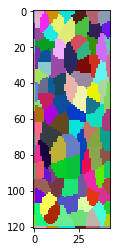

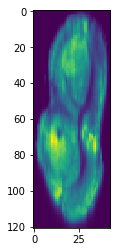

In [5]:
communities = [[2672,2714,2715,2757,2758,2759,2800,2801,2802,2803,2843,2844,2845,2846,2847,2848,2886,2887,2888,2889,2890,2891,2892,2893,2929,2930,2931,2932,2933,2934,2935,2936,2937,2938,2971,2972,2973,2974,2975,2976,2977,2978,2979,2980,2981,2982,3014,3015,3016,3017,3018,3019,3020,3021,3022,3023,3024,3025,3057,3058,3059,3060,3061,3062,3063,3064,3065,3066,3100,3101,3102,3103,3104,3105,3106,3107,3108,3144,3145,3146,3147,3148,3149,3150,3151,3188,3189,3190,3191,3192,3232,3233,3234,3235,3276,3277,3278,3320,3363],[836,837,878,879,880,921,922,923,924,963,964,965,966,967,1006,1007,1008,1009,1010,1011,1049,1050,1051,1052,1053,1054,1092,1093,1094,1095,1096,1097,1098,1135,1136,1137,1138,1139,1140,1141,1178,1179,1180,1181,1182,1183,1184,1221,1222,1223,1224,1225,1226,1227,1228,1264,1265,1266,1267,1268,1269,1270,1271,1307,1308,1309,1310,1311,1312,1313,1350,1351,1352,1353,1354,1355,1356,1393,1394,1395,1396,1397,1398,1399,1437,1438,1439,1440,1441,1480,1481,1482,1483,1484,1524,1525,1526,1568],[3067,3068,3109,3110,3111,3112,3152,3153,3154,3155,3193,3194,3195,3196,3197,3198,3199,3236,3237,3238,3239,3240,3241,3242,3279,3280,3281,3282,3283,3284,3285,3321,3322,3323,3324,3325,3326,3327,3328,3364,3365,3366,3367,3368,3369,3370,3371,3406,3407,3408,3409,3410,3411,3412,3413,3414,3449,3450,3451,3452,3453,3454,3455,3456,3457,3493,3494,3495,3496,3497,3498,3499,3500,3536,3537,3538,3539,3540,3541,3542,3543,3579,3580,3581,3582,3583,3584,3585,3622,3623,3624,3625,3626,3665,3666,3667],[3026,3027,3028,3029,3030,3031,3069,3070,3071,3072,3073,3074,3075,3113,3114,3115,3116,3117,3118,3119,3156,3157,3158,3159,3160,3161,3162,3163,3200,3201,3202,3203,3204,3205,3206,3207,3243,3244,3245,3246,3247,3248,3249,3250,3286,3287,3288,3289,3290,3291,3292,3293,3329,3330,3331,3332,3333,3334,3335,3336,3372,3373,3374,3375,3376,3377,3378,3379,3415,3416,3417,3418,3419,3420,3421,3422,3458,3459,3460,3461,3462,3463,3464,3465,3501,3502,3503,3504,3505,3506,3544,3545,3546],[2468,2510,2511,2512,2551,2552,2553,2554,2555,2592,2593,2594,2595,2596,2597,2598,2599,2634,2635,2636,2637,2638,2639,2640,2641,2642,2677,2678,2679,2680,2681,2682,2683,2684,2685,2719,2720,2721,2722,2723,2724,2725,2726,2727,2728,2761,2762,2763,2764,2765,2766,2767,2768,2769,2770,2771,2804,2805,2806,2807,2808,2809,2810,2811,2812,2813,2814,2849,2850,2851,2852,2853,2854,2855,2856,2857,2894,2895,2896,2897,2898,2899,2900,2939,2940,2941,2942,2943,2983,2984,2985,2986],[4444,4451,4452,4453,4487,4488,4490,4491,4492,4493,4494,4495,4496,4529,4530,4531,4532,4533,4534,4535,4536,4537,4538,4539,4571,4572,4573,4574,4575,4576,4577,4578,4579,4580,4581,4582,4615,4616,4617,4618,4619,4620,4621,4622,4623,4624,4625,4658,4659,4660,4661,4662,4663,4664,4665,4666,4667,4668,4704,4705,4706,4707,4708,4709,4710,4711,4747,4748,4749,4750,4751,4752,4753,4754,4791,4792,4793,4794,4795,4796,4797,4834,4835,4836,4837,4838,4839,4878,4879],[3507,3508,3547,3548,3549,3550,3551,3588,3589,3590,3591,3592,3593,3594,3631,3632,3633,3634,3635,3636,3637,3674,3675,3676,3677,3678,3679,3680,3717,3718,3719,3720,3721,3722,3723,3760,3761,3762,3763,3764,3765,3766,3803,3804,3805,3806,3807,3808,3809,3846,3847,3848,3849,3850,3851,3852,3889,3890,3891,3892,3893,3894,3895,3932,3933,3934,3935,3936,3937,3938,3975,3976,3977,3978,3979,3980,3981,4018,4019,4020,4021,4022,4023,4061,4062,4063,4064,4065],[1873,1874,1875,1876,1916,1917,1918,1919,1920,1959,1960,1961,1962,1963,1964,2002,2003,2004,2005,2006,2007,2044,2045,2046,2047,2048,2049,2050,2087,2088,2089,2090,2091,2092,2093,2130,2131,2132,2133,2134,2135,2136,2172,2173,2174,2175,2176,2177,2178,2215,2216,2217,2218,2219,2220,2221,2258,2259,2260,2261,2262,2263,2264,2301,2302,2303,2304,2305,2306,2307,2345,2346,2347,2348,2349,2350,2389,2390,2391,2392,2393,2434,2435,2436,2479],[236,278,279,320,321,322,323,362,363,364,365,366,404,405,406,407,408,409,446,447,448,449,450,451,452,489,490,491,492,493,494,495,531,532,533,534,535,536,537,538,574,575,576,577,578,579,580,581,616,617,618,619,620,621,622,623,624,659,660,661,662,663,664,665,666,667,702,703,704,705,706,707,708,709,747,748,749,750,751,791,792,793,834,835],[1523,1566,1567,1609,1610,1611,1652,1653,1654,1655,1695,1696,1697,1698,1699,1738,1739,1740,1741,1742,1781,1782,1783,1784,1785,1786,1823,1824,1825,1826,1827,1828,1829,1830,1866,1867,1868,1869,1870,1871,1872,1909,1910,1911,1912,1913,1914,1915,1952,1953,1954,1955,1956,1957,1958,1996,1997,1998,1999,2000,2001,2039,2040,2041,2042,2043,2082,2083,2084,2085,2086,2126,2127,2128,2129,2169,2170,2171,2213,2214,2257],[2316,2317,2359,2360,2401,2402,2403,2443,2444,2445,2446,2485,2486,2487,2488,2489,2526,2527,2528,2529,2530,2531,2532,2566,2567,2568,2569,2570,2571,2572,2573,2574,2575,2609,2610,2611,2612,2613,2614,2615,2616,2617,2652,2653,2654,2655,2656,2657,2658,2659,2660,2696,2697,2698,2699,2700,2701,2702,2703,2740,2741,2742,2743,2744,2745,2746,2783,2784,2785,2786,2787,2788,2789,2827,2828,2829,2830,2831,2832],[1042,1085,1128,1129,1171,1172,1173,1174,1214,1215,1216,1217,1218,1219,1220,1257,1258,1259,1260,1261,1262,1263,1300,1301,1302,1303,1304,1305,1306,1343,1344,1345,1346,1347,1348,1349,1386,1387,1388,1389,1390,1391,1392,1429,1430,1431,1432,1433,1434,1435,1436,1472,1473,1474,1475,1476,1477,1478,1479,1515,1516,1517,1518,1519,1520,1521,1522,1558,1559,1560,1561,1562,1600,1601,1602,1603,1644,1645],[3586,3587,3627,3628,3629,3630,3668,3669,3670,3671,3672,3673,3708,3709,3710,3711,3712,3713,3714,3715,3716,3751,3752,3753,3754,3755,3756,3757,3758,3759,3794,3795,3796,3797,3798,3799,3800,3801,3802,3838,3839,3840,3841,3842,3843,3844,3845,3881,3882,3883,3884,3885,3886,3887,3888,3925,3926,3927,3928,3929,3930,3931,3968,3969,3970,3971,3972,3973,3974,4012,4013,4014,4015,4016,4017,4059,4060],[1527,1528,1529,1530,1569,1570,1571,1572,1573,1574,1575,1576,1577,1578,1579,1612,1613,1614,1615,1616,1617,1618,1619,1620,1621,1622,1656,1657,1658,1659,1660,1661,1662,1663,1664,1665,1666,1700,1701,1702,1703,1704,1705,1706,1707,1708,1709,1743,1744,1745,1746,1747,1748,1749,1750,1751,1752,1787,1788,1789,1790,1791,1792,1793,1794,1831,1832,1833,1834,1835,1836,1837,1877,1878,1879,1921],[2038,2077,2078,2079,2080,2081,2119,2120,2121,2122,2123,2124,2125,2161,2162,2163,2164,2165,2166,2167,2168,2204,2205,2206,2207,2208,2209,2210,2211,2212,2247,2248,2249,2250,2251,2252,2253,2254,2255,2256,2290,2291,2292,2293,2294,2295,2296,2297,2298,2299,2334,2335,2336,2337,2338,2339,2340,2341,2377,2378,2379,2380,2381,2382,2383,2421,2422,2423,2424,2425,2426,2465,2466,2467,2508,2509],[4702,4703,4745,4746,4788,4789,4790,4831,4832,4833,4874,4875,4876,4877,4917,4918,4919,4920,4921,4959,4960,4961,4962,4963,4964,5002,5003,5004,5005,5006,5007,5008,5044,5045,5046,5047,5048,5049,5050,5051,5052,5086,5087,5088,5089,5090,5091,5092,5093,5094,5095,5128,5129,5130,5131,5132,5133,5134,5135,5136,5137,5138,5168,5169,5170,5171,5172,5173,5174,5175,5176,5177,5178,5179,5180,5181],[4066,4102,4103,4104,4105,4106,4107,4108,4109,4145,4146,4147,4148,4149,4150,4151,4152,4188,4189,4190,4191,4192,4193,4194,4195,4231,4232,4233,4234,4235,4236,4237,4238,4274,4275,4276,4277,4278,4279,4280,4281,4316,4317,4318,4319,4320,4321,4322,4323,4324,4359,4360,4361,4362,4363,4364,4365,4366,4367,4402,4403,4404,4405,4406,4407,4408,4409,4410,4445,4446,4447,4448,4449,4450,4489],[2875,2918,2919,2961,2962,2963,2964,2965,2966,2967,3004,3005,3006,3007,3008,3009,3010,3047,3048,3049,3050,3051,3052,3053,3090,3091,3092,3093,3094,3095,3096,3133,3134,3135,3136,3137,3138,3139,3176,3177,3178,3179,3180,3181,3182,3220,3221,3222,3223,3224,3225,3263,3264,3265,3266,3267,3268,3306,3307,3308,3309,3310,3311,3350,3351,3352,3353,3354,3393,3394,3395,3396,3397],[3341,3342,3343,3344,3345,3346,3347,3385,3386,3387,3388,3389,3390,3428,3429,3430,3431,3432,3433,3471,3472,3473,3474,3475,3476,3514,3515,3516,3517,3518,3519,3557,3558,3559,3560,3561,3562,3601,3602,3603,3604,3605,3606,3644,3645,3646,3647,3648,3649,3687,3688,3689,3690,3691,3692,3730,3731,3732,3733,3734,3735,3773,3774,3775,3776,3777,3778,3816,3817,3818,3819,3859,3860],[4394,4395,4436,4437,4438,4439,4478,4479,4480,4481,4482,4483,4520,4521,4522,4523,4524,4525,4526,4527,4563,4564,4565,4566,4567,4568,4569,4570,4606,4607,4608,4609,4610,4611,4612,4648,4649,4650,4651,4652,4653,4654,4655,4691,4692,4693,4694,4695,4696,4697,4734,4735,4736,4737,4738,4739,4777,4778,4779,4780,4781,4820,4821,4822,4823,4863,4864,4865,4866,4907,4908,4950],[4613,4614,4656,4657,4698,4699,4700,4701,4740,4741,4742,4743,4744,4782,4783,4784,4785,4786,4787,4824,4825,4826,4827,4828,4829,4830,4867,4868,4869,4870,4871,4872,4873,4909,4910,4911,4912,4913,4914,4915,4916,4951,4952,4953,4954,4955,4956,4957,4958,4994,4995,4996,4997,4998,4999,5000,5001,5037,5038,5039,5040,5041,5042,5043,5081,5082,5083,5084,5085,5125,5126,5127],[4840,4841,4842,4843,4880,4881,4882,4883,4884,4885,4886,4887,4888,4889,4922,4923,4924,4925,4926,4927,4928,4929,4930,4931,4965,4966,4967,4968,4969,4970,4971,4972,4973,4974,5009,5010,5011,5012,5013,5014,5015,5016,5017,5053,5054,5055,5056,5057,5058,5059,5096,5097,5098,5099,5100,5101,5102,5139,5140,5141,5142,5143,5144,5145,5182,5183,5184,5185,5186,5187,5188],[243,244,245,285,286,287,288,326,327,328,329,330,331,368,369,370,371,372,373,374,410,411,412,413,414,415,416,417,453,454,455,456,457,458,459,460,496,497,498,499,500,501,502,503,539,540,541,542,543,544,545,546,582,583,584,585,586,587,588,625,626,627,628,629,630,631,672,673,674],[639,640,682,683,684,724,725,726,767,768,769,810,811,812,813,853,854,855,856,895,896,897,898,899,938,939,940,941,942,981,982,983,984,985,986,1024,1025,1026,1027,1028,1029,1067,1068,1069,1070,1071,1072,1110,1111,1112,1113,1114,1115,1154,1155,1156,1157,1158,1197,1198,1199,1200,1201,1241,1242,1243,1244,1285,1286],[1563,1564,1565,1604,1605,1606,1607,1608,1646,1647,1648,1649,1650,1651,1688,1689,1690,1691,1692,1693,1694,1731,1732,1733,1734,1735,1736,1737,1774,1775,1776,1777,1778,1779,1780,1818,1819,1820,1821,1822,1861,1862,1863,1864,1865,1904,1905,1906,1907,1908,1947,1948,1949,1950,1951,1990,1991,1992,1993,1994,1995,2033,2034,2035,2036,2037,2076],[2300,2342,2343,2344,2384,2385,2386,2387,2388,2427,2428,2429,2430,2431,2432,2433,2469,2470,2471,2472,2473,2474,2475,2476,2477,2478,2513,2514,2515,2516,2517,2518,2519,2520,2521,2522,2556,2557,2558,2559,2560,2561,2562,2563,2564,2565,2600,2601,2602,2603,2604,2605,2606,2607,2608,2643,2644,2645,2646,2647,2648,2649,2650,2651,2692,2693,2694],[4055,4056,4057,4058,4097,4098,4099,4100,4101,4137,4139,4140,4141,4142,4143,4144,4179,4180,4181,4182,4183,4184,4185,4186,4187,4223,4224,4225,4226,4227,4228,4229,4230,4266,4267,4268,4269,4270,4271,4272,4273,4310,4311,4312,4313,4314,4315,4353,4354,4355,4356,4357,4358,4396,4397,4398,4399,4400,4401,4440,4441,4442,4443,4484,4485,4486,4528],[3142,3143,3185,3186,3187,3228,3229,3230,3231,3272,3273,3274,3275,3315,3316,3317,3318,3319,3358,3359,3360,3361,3362,3401,3402,3403,3404,3405,3444,3445,3446,3447,3448,3487,3488,3489,3490,3491,3492,3531,3532,3533,3534,3535,3574,3575,3576,3577,3578,3617,3618,3619,3620,3621,3661,3662,3663,3664,3704,3705,3706,3707,3747,3748,3749,3791],[3901,3902,3903,3942,3943,3944,3945,3946,3984,3985,3986,3987,3988,3989,4027,4028,4029,4030,4031,4032,4070,4071,4072,4073,4074,4075,4076,4113,4114,4115,4116,4117,4118,4119,4157,4158,4159,4160,4161,4162,4200,4201,4202,4203,4204,4205,4244,4245,4246,4247,4248,4249,4287,4288,4289,4290,4291,4292,4332,4333,4334,4335,4336,4377,4378,4379],[1804,1805,1806,1847,1848,1849,1890,1891,1892,1933,1934,1935,1975,1976,1977,1978,2018,2019,2020,2021,2061,2062,2063,2064,2104,2105,2106,2107,2146,2147,2148,2149,2150,2189,2190,2191,2192,2193,2232,2233,2234,2235,2236,2275,2276,2277,2278,2279,2318,2319,2320,2321,2322,2361,2362,2363,2364,2365,2404,2405,2406,2407,2408,2447,2490],[2448,2449,2450,2451,2491,2492,2493,2494,2533,2534,2535,2536,2537,2576,2577,2578,2579,2580,2618,2619,2620,2621,2622,2623,2661,2662,2663,2664,2665,2666,2704,2705,2706,2707,2708,2709,2747,2748,2749,2750,2751,2752,2790,2791,2792,2793,2794,2795,2833,2834,2835,2836,2837,2838,2876,2877,2878,2879,2880,2881,2920,2921,2922,2923,2924],[37,38,39,40,41,42,43,80,81,82,83,84,85,86,122,123,124,125,126,127,128,129,165,166,167,168,169,170,171,172,208,209,210,211,212,213,214,215,251,252,253,254,255,256,257,258,294,295,296,297,298,299,300,301,337,338,339,340,341,381,382,424],[1148,1189,1190,1191,1230,1231,1232,1233,1234,1272,1273,1274,1275,1276,1277,1314,1315,1316,1317,1318,1319,1320,1357,1358,1359,1360,1361,1362,1363,1364,1400,1401,1402,1403,1404,1405,1406,1407,1442,1443,1444,1445,1446,1447,1448,1449,1450,1485,1486,1487,1488,1489,1490,1491,1492,1493,1531,1532,1533,1534,1535,1536],[1284,1327,1328,1329,1369,1370,1371,1372,1412,1413,1414,1415,1454,1455,1456,1457,1458,1497,1498,1499,1500,1501,1540,1541,1542,1543,1544,1545,1582,1583,1584,1585,1586,1587,1588,1625,1626,1627,1628,1629,1630,1631,1668,1669,1670,1671,1672,1673,1674,1710,1711,1712,1713,1714,1715,1716,1753,1754,1755,1756,1797,1798],[2907,2908,2950,2951,2992,2993,2994,3034,3035,3036,3037,3077,3078,3079,3080,3120,3121,3122,3123,3124,3164,3165,3166,3167,3208,3209,3210,3211,3251,3252,3253,3254,3294,3295,3296,3297,3337,3338,3339,3340,3380,3381,3382,3423,3424,3425,3466,3467,3509,3510,3552,3553,3595,3596,3638,3681,3724,3767,3810,3853,3896,3939],[701,743,744,745,746,786,787,788,789,790,829,830,831,832,833,872,873,874,875,876,877,915,916,917,918,919,920,957,958,959,960,961,962,1000,1001,1002,1003,1004,1005,1043,1044,1045,1046,1047,1048,1086,1087,1088,1089,1090,1091,1130,1131,1132,1133,1134,1175,1176,1177],[2024,2025,2026,2027,2028,2029,2030,2031,2067,2068,2069,2070,2071,2072,2073,2074,2075,2110,2111,2112,2113,2114,2115,2116,2117,2118,2153,2154,2155,2156,2157,2158,2159,2160,2197,2198,2199,2200,2201,2202,2203,2240,2241,2242,2243,2244,2245,2246,2284,2285,2286,2287,2288,2327,2328,2329,2330,2371,2372],[2873,2874,2915,2916,2917,2958,2959,2960,3000,3001,3002,3003,3042,3043,3044,3045,3046,3085,3086,3087,3088,3089,3127,3128,3129,3130,3131,3132,3170,3171,3172,3173,3174,3175,3212,3213,3214,3215,3216,3217,3218,3219,3255,3256,3257,3258,3259,3260,3261,3262,3298,3299,3300,3301,3302,3303,3304,3305,3348],[694,735,736,737,738,739,775,776,777,778,779,780,781,782,783,784,785,818,819,820,821,822,823,824,825,826,827,828,861,862,863,864,865,866,867,868,869,870,871,906,907,908,909,910,911,912,913,914,950,951,952,953,955,956,993,994,998,999],[2289,2331,2332,2333,2373,2374,2375,2376,2414,2415,2416,2417,2418,2419,2420,2457,2458,2459,2460,2461,2462,2463,2464,2500,2501,2502,2503,2504,2505,2506,2507,2543,2544,2545,2546,2547,2548,2549,2550,2586,2587,2588,2589,2590,2591,2629,2630,2631,2632,2633,2673,2674,2675,2676,2716,2717,2718,2760],[2686,2687,2688,2689,2690,2691,2729,2730,2731,2732,2733,2734,2735,2736,2772,2773,2774,2775,2776,2777,2778,2779,2815,2816,2817,2818,2819,2820,2821,2822,2858,2859,2860,2861,2862,2863,2864,2901,2902,2903,2904,2905,2906,2944,2945,2946,2947,2948,2949,2987,2988,2989,2990,2991,3032,3033,3076],[4637,4679,4680,4681,4721,4722,4723,4724,4725,4763,4764,4765,4766,4767,4768,4806,4807,4808,4809,4810,4811,4850,4851,4852,4853,4854,4855,4893,4894,4895,4896,4897,4898,4937,4938,4939,4940,4941,4980,4981,4982,4983,4984,5024,5025,5026,5027,5067,5068,5069,5070,5111,5112,5154,5155,5197,5198],[760,803,804,845,846,847,887,888,889,890,929,930,931,932,933,971,972,973,974,975,976,1013,1014,1015,1016,1017,1018,1019,1020,1056,1057,1058,1059,1060,1061,1062,1063,1099,1100,1101,1102,1103,1104,1105,1106,1142,1143,1144,1145,1146,1147,1185,1186,1187,1188,1229],[2137,2179,2180,2181,2182,2222,2223,2224,2225,2226,2227,2265,2266,2267,2268,2269,2270,2271,2272,2308,2309,2310,2311,2312,2313,2314,2315,2351,2352,2353,2354,2355,2356,2357,2358,2394,2395,2396,2397,2398,2399,2400,2437,2438,2439,2440,2441,2442,2480,2481,2482,2483,2484,2523,2524,2525],[4645,4646,4647,4688,4689,4690,4731,4732,4733,4774,4775,4776,4817,4818,4819,4860,4861,4862,4903,4904,4905,4906,4946,4947,4948,4949,4989,4990,4991,4992,4993,5032,5033,5034,5035,5036,5075,5076,5077,5078,5079,5080,5118,5119,5120,5121,5122,5123,5124,5161,5162,5163,5164,5165,5166,5167],[1795,1796,1838,1839,1840,1841,1880,1881,1882,1883,1884,1922,1923,1924,1925,1926,1927,1965,1966,1967,1968,1969,1970,2008,2009,2010,2011,2012,2013,2051,2052,2053,2054,2055,2056,2057,2094,2095,2096,2097,2098,2099,2100,2138,2139,2140,2141,2142,2143,2183,2184,2185,2186,2228,2229],[29,30,31,32,33,34,35,36,72,73,74,75,76,77,78,79,115,116,117,118,119,120,121,158,159,160,161,162,163,164,202,203,204,205,206,207,246,247,248,249,250,289,290,291,292,293,333,334,335,336,376,377,378,379],[332,375,380,418,419,420,421,422,423,461,462,463,464,465,466,467,504,505,506,507,508,509,510,547,548,549,550,551,552,553,589,590,591,592,593,594,595,596,597,632,633,634,635,636,637,638,676,677,678,679,680,681,722,723],[3982,3983,4024,4025,4026,4067,4068,4069,4110,4111,4112,4153,4154,4155,4156,4196,4197,4198,4199,4239,4240,4241,4242,4243,4282,4283,4284,4285,4286,4325,4326,4327,4328,4329,4368,4369,4370,4371,4372,4411,4412,4413,4414,4415,4454,4455,4456,4457,4458,4497,4498,4499,4500,4540],[4805,4847,4848,4849,4890,4891,4892,4932,4933,4934,4935,4936,4975,4976,4977,4978,4979,5018,5019,5020,5021,5022,5023,5060,5061,5062,5063,5064,5065,5066,5103,5104,5105,5106,5107,5108,5109,5110,5146,5147,5148,5149,5150,5151,5152,5153,5189,5190,5191,5192,5193,5194,5195,5196],[3383,3384,3426,3427,3468,3469,3470,3511,3512,3513,3554,3555,3556,3597,3598,3599,3600,3639,3640,3641,3642,3643,3682,3683,3684,3685,3686,3725,3726,3727,3728,3729,3768,3769,3770,3771,3772,3811,3812,3813,3814,3815,3854,3855,3856,3857,3858,3897,3898,3899,3900,3940,3941],[1074,1075,1117,1118,1159,1160,1161,1202,1203,1204,1245,1246,1247,1287,1288,1289,1290,1330,1331,1332,1333,1373,1374,1375,1376,1416,1417,1418,1419,1459,1460,1461,1462,1502,1503,1504,1505,1546,1547,1548,1589,1590,1591,1632,1633,1634,1676,1677,1719,1720,1762,1763],[668,669,670,671,710,711,712,713,714,715,716,717,752,753,754,755,756,757,758,759,794,795,796,797,798,799,800,801,802,838,839,840,841,842,843,844,881,882,883,884,885,886,925,926,927,928,968,969,970,1012,1055],[1107,1149,1150,1151,1152,1153,1192,1193,1194,1195,1196,1235,1236,1237,1238,1239,1240,1278,1279,1280,1281,1282,1283,1321,1322,1323,1324,1325,1326,1365,1366,1367,1368,1408,1409,1410,1411,1451,1452,1453,1494,1495,1496,1537,1538,1539,1580,1581,1623,1624,1667],[1675,1717,1718,1757,1758,1759,1760,1761,1799,1800,1801,1802,1803,1842,1843,1844,1845,1846,1885,1886,1887,1888,1889,1928,1929,1930,1931,1932,1971,1972,1973,1974,2014,2015,2016,2017,2058,2059,2060,2101,2102,2103,2144,2145,2187,2188,2230,2231,2273,2274],[4086,4087,4088,4089,4090,4091,4129,4130,4131,4132,4133,4134,4135,4172,4173,4174,4175,4176,4177,4178,4215,4216,4217,4218,4219,4220,4221,4222,4258,4259,4260,4261,4262,4263,4264,4265,4303,4304,4305,4306,4307,4308,4309,4348,4349,4350,4351,4352,4392,4393],[3779,3820,3821,3822,3861,3862,3863,3864,3865,3904,3905,3906,3907,3908,3947,3948,3949,3950,3951,3990,3991,3992,3993,3994,4033,4034,4035,4036,4037,4077,4078,4079,4080,4081,4120,4121,4122,4123,4163,4164,4165,4166,4206,4207,4208,4250,4251,4293,4294],[14,15,16,17,18,19,20,21,22,57,58,59,60,61,62,63,64,65,101,102,103,104,105,106,107,108,144,145,146,147,148,149,150,188,189,190,191,192,232,233,234,235,275,276,277,318,319,361],[23,24,25,26,27,28,66,67,68,69,70,71,109,110,111,112,113,114,151,152,153,154,155,156,157,193,194,195,196,197,198,199,200,201,237,238,239,240,241,242,280,281,282,283,284,324,325,367],[143,186,187,228,229,230,231,269,270,271,272,273,274,312,313,314,315,316,317,354,355,356,357,358,359,360,397,398,399,400,401,402,403,441,442,443,444,445,484,485,486,487,488,528,529,530,572,573],[2695,2737,2738,2739,2780,2781,2782,2823,2824,2825,2826,2865,2866,2867,2868,2869,2870,2871,2872,2909,2910,2911,2912,2913,2914,2952,2953,2954,2955,2956,2957,2995,2996,2997,2998,2999,3038,3039,3040,3041,3081,3082,3083,3084,3125,3126,3168,3169],[4330,4331,4373,4374,4375,4376,4416,4417,4418,4419,4420,4421,4422,4459,4460,4461,4462,4463,4464,4502,4503,4504,4505,4506,4507,4545,4546,4547,4548,4549,4550,4588,4589,4590,4591,4592,4593,4632,4633,4634,4635,4636,4675,4676,4677,4678,4719,4720],[342,343,344,383,384,385,386,387,425,426,427,428,429,430,468,469,470,471,472,473,511,512,513,514,515,516,554,555,556,557,558,559,598,599,600,601,602,641,642,643,644,645,685,686,687,688,729],[396,438,439,440,480,481,482,483,522,523,524,525,526,527,564,565,566,567,568,569,570,571,608,609,610,611,612,613,614,615,651,652,653,654,655,656,657,658,695,696,697,698,699,700,740,741,742],[3658,3659,3660,3699,3700,3701,3702,3703,3742,3743,3744,3745,3746,3785,3786,3787,3788,3789,3828,3829,3830,3831,3832,3871,3872,3873,3874,3875,3914,3915,3916,3917,3918,3957,3958,3959,3960,3961,4000,4001,4002,4003,4004,4043,4044,4045,4046],[4501,4541,4542,4543,4544,4583,4584,4585,4586,4587,4626,4627,4628,4629,4630,4631,4669,4670,4671,4672,4673,4674,4712,4713,4714,4715,4716,4717,4718,4755,4756,4757,4758,4759,4760,4761,4762,4798,4799,4800,4801,4802,4803,4804,4844,4845,4846],[3349,3391,3392,3434,3435,3436,3437,3438,3439,3440,3477,3478,3479,3480,3481,3482,3483,3520,3521,3522,3523,3524,3525,3526,3563,3564,3565,3566,3567,3568,3569,3607,3608,3609,3610,3611,3612,3650,3651,3652,3653,3654,3655,3693,3694,3736],[4295,4337,4338,4380,4381,4382,4423,4424,4425,4426,4465,4466,4467,4468,4469,4470,4471,4508,4509,4510,4511,4512,4513,4514,4515,4551,4552,4553,4554,4555,4556,4557,4558,4594,4595,4596,4597,4598,4599,4600,4601,4638,4639,4640,4682],[3695,3696,3697,3698,3737,3738,3739,3740,3741,3780,3781,3782,3783,3784,3823,3824,3825,3826,3827,3866,3867,3868,3869,3870,3909,3910,3911,3912,3913,3952,3953,3954,3955,3956,3995,3996,3997,3998,3999,4038,4039,4040,4041,4042],[4082,4083,4084,4085,4124,4125,4126,4127,4128,4167,4168,4169,4170,4171,4209,4210,4211,4212,4213,4214,4252,4253,4254,4255,4256,4257,4296,4297,4298,4299,4300,4339,4340,4341,4342,4343,4383,4384,4385,4386,4427,4428,4429,4472],[49,92,134,135,136,177,178,179,219,220,221,222,223,262,263,264,265,266,305,306,307,308,309,348,349,350,351,352,353,391,392,393,394,395,434,435,436,437,477,478,479,520,521],[1293,1294,1295,1296,1297,1298,1299,1336,1337,1338,1339,1340,1341,1342,1379,1380,1381,1382,1383,1384,1385,1423,1424,1425,1426,1427,1428,1466,1467,1468,1469,1470,1471,1510,1511,1512,1513,1514,1555,1556,1557,1599,1642],[7,8,9,10,11,12,13,50,51,52,53,54,55,56,93,94,95,96,97,98,99,100,137,138,139,140,141,142,180,181,182,183,184,185,224,225,226,227,267,268,310,311],[675,718,719,720,721,761,762,763,764,765,766,805,806,807,808,809,848,849,850,851,852,891,892,893,894,934,935,936,937,977,978,979,980,1021,1022,1023,1064,1065,1066,1108,1109],[954,995,996,997,1037,1038,1039,1040,1041,1079,1080,1081,1082,1083,1084,1122,1123,1124,1125,1126,1127,1165,1166,1167,1168,1169,1170,1207,1208,1209,1210,1211,1212,1213,1250,1251,1252,1253,1254,1255,1256],[2323,2324,2366,2367,2368,2369,2409,2410,2411,2412,2413,2452,2453,2454,2455,2456,2495,2496,2497,2498,2499,2538,2539,2540,2541,2542,2581,2582,2583,2584,2585,2624,2625,2626,2627,2628,2667,2668,2669,2670,2671],[2710,2711,2712,2713,2753,2754,2755,2756,2796,2797,2798,2799,2839,2840,2841,2842,2882,2883,2884,2885,2925,2926,2927,2928,2968,2969,2970,3011,3012,3013,3054,3055,3056,3097,3098,3099,3140,3141,3183,3226],[1641,1682,1683,1684,1724,1725,1726,1727,1767,1768,1769,1770,1809,1810,1811,1812,1813,1852,1853,1854,1855,1856,1895,1896,1897,1898,1899,1938,1939,1940,1941,1942,1981,1982,1983,1984,1985],[1422,1463,1464,1465,1506,1507,1508,1509,1549,1550,1551,1552,1553,1554,1592,1593,1594,1595,1596,1597,1598,1635,1636,1637,1638,1639,1640,1678,1679,1680,1681,1721,1722,1723,1766],[3184,3227,3269,3270,3271,3312,3313,3314,3355,3356,3357,3398,3399,3400,3441,3442,3443,3484,3485,3486,3527,3528,3529,3530,3570,3571,3572,3573,3613,3614,3615,3616,3656,3657],[4301,4302,4344,4345,4346,4347,4387,4388,4389,4390,4391,4430,4431,4432,4433,4434,4435,4473,4474,4475,4476,4477,4516,4517,4518,4519,4559,4560,4561,4562,4602,4603,4604,4605],[727,728,730,731,770,771,772,773,774,814,815,816,817,857,858,859,860,900,901,902,903,943,944,945,946,987,988,989,1030,1031,1032,1073,1116],[904,905,947,948,949,990,991,992,1033,1034,1035,1036,1076,1077,1078,1119,1120,1121,1162,1163,1164,1205,1206,1248,1249,1291,1292,1334,1335,1377,1378,1420,1421],[4641,4642,4643,4644,4683,4684,4685,4686,4687,4726,4727,4728,4729,4730,4769,4770,4771,4772,4773,4812,4813,4814,4815,4816,4856,4857,4858,4859,4899,4900,4901,4902],[1643,1685,1686,1687,1728,1729,1730,1771,1772,1773,1814,1815,1816,1817,1857,1858,1859,1860,1900,1901,1902,1903,1943,1944,1945,1946,1986,1987,1988,1989,2032],[4942,4943,4944,4945,4985,4986,4987,4988,5028,5029,5030,5031,5071,5072,5073,5074,5113,5114,5115,5116,5117,5156,5157,5158,5159,5160,5199,5200,5201,5202,5203],[474,475,476,517,518,519,560,561,562,563,603,604,605,606,607,646,647,648,649,650,689,690,691,692,693,732,733,734],[3790,3833,3834,3835,3876,3877,3878,3919,3920,3921,3922,3962,3963,3964,3965,4005,4006,4007,4008,4047,4048,4049,4050,4051,4092,4093,4094,4136],[130,131,132,173,174,175,176,216,217,218,259,260,261,302,303,304,345,346,347,388,389,390,431,432,433],[1764,1765,1807,1808,1850,1851,1893,1894,1936,1937,1979,1980,2022,2023,2065,2066,2108,2109,2151,2152,2194],[3750,3792,3793,3836,3837,3879,3880,3923,3924,3966,3967,4009,4010,4011,4052,4053,4054,4095,4096,4138],[1,2,3,4,5,6,44,45,46,47,48,87,88,89,90,91,133],[2195,2196,2237,2238,2239,2280,2281,2282,2283,2325,2326],[2370]]
image = np.zeros((x,y,3))
for community in communities:
    color = np.random.randint(1, 255, 3)
    for pixel in community:
        image[pixel//y-1,pixel%y,:] = color
image = image.astype(int)
image
plt.imshow(image)
plt.show()
plt.imshow(data['img'][np.argmax(data['img'][:,20,20]),:,:])
plt.show()

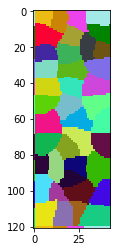

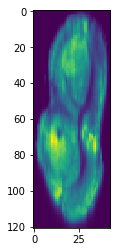

In [8]:
communities = [[3429,3430,3431,3472,3473,3474,3475,3514,3515,3516,3517,3518,3519,3556,3557,3558,3559,3560,3561,3562,3563,3564,3599,3600,3601,3602,3603,3604,3605,3606,3607,3608,3609,3610,3611,3612,3642,3643,3644,3645,3646,3647,3648,3649,3650,3651,3652,3653,3654,3655,3685,3686,3687,3688,3689,3690,3691,3692,3693,3694,3695,3696,3697,3698,3728,3729,3730,3731,3732,3733,3734,3735,3736,3737,3738,3739,3740,3741,3770,3771,3772,3773,3774,3775,3776,3777,3778,3779,3780,3781,3782,3783,3784,3813,3814,3815,3816,3817,3818,3819,3820,3821,3822,3823,3824,3825,3826,3827,3856,3857,3858,3859,3860,3861,3862,3863,3864,3865,3866,3867,3868,3869,3870,3899,3900,3901,3902,3903,3904,3905,3906,3907,3908,3909,3910,3911,3912,3913,3943,3944,3945,3946,3947,3948,3949,3950,3951,3952,3953,3954,3955,3956,3986,3987,3988,3989,3990,3991,3992,3993,3994,3995,3996,3997,3998,3999,4029,4030,4031,4032,4033,4034,4035,4036,4037,4038,4039,4040,4041,4042,4072,4073,4074,4075,4076,4077,4078,4079,4080,4081,4082,4083,4084,4085,4116,4117,4118,4119,4120,4121,4122,4160,4161,4162,4163,4164,4204,4205,4206,4247,4248,4249],[4675,4717,4718,4719,4720,4721,4722,4723,4724,4725,4759,4760,4761,4762,4763,4764,4765,4766,4767,4768,4769,4770,4771,4772,4773,4802,4803,4804,4805,4806,4807,4808,4809,4810,4811,4812,4813,4814,4815,4816,4844,4845,4846,4847,4848,4849,4850,4851,4852,4853,4854,4855,4856,4857,4858,4859,4887,4888,4889,4890,4891,4892,4893,4894,4895,4896,4897,4898,4899,4900,4901,4902,4929,4930,4931,4932,4933,4934,4935,4936,4937,4938,4939,4940,4941,4942,4943,4944,4945,4972,4973,4974,4975,4976,4977,4978,4979,4980,4981,4982,4983,4984,4985,4986,4987,4988,5014,5015,5016,5017,5018,5019,5020,5021,5022,5023,5024,5025,5026,5027,5028,5029,5030,5031,5057,5058,5059,5060,5061,5062,5063,5064,5065,5066,5067,5068,5069,5070,5071,5072,5073,5074,5100,5101,5102,5103,5104,5105,5106,5107,5108,5109,5110,5111,5112,5113,5114,5115,5116,5117,5143,5144,5145,5146,5147,5148,5149,5150,5151,5152,5153,5154,5155,5156,5157,5158,5159,5160,5185,5186,5187,5188,5189,5190,5191,5192,5193,5194,5195,5196,5197,5198,5199,5200,5201,5202,5203],[2061,2062,2063,2064,2097,2098,2099,2100,2101,2102,2103,2104,2105,2106,2107,2134,2135,2136,2137,2138,2139,2140,2141,2142,2143,2144,2145,2146,2147,2148,2149,2150,2177,2178,2179,2180,2181,2182,2183,2184,2185,2186,2187,2188,2189,2190,2191,2192,2193,2220,2221,2222,2223,2224,2225,2226,2227,2228,2229,2230,2231,2232,2233,2234,2235,2236,2263,2264,2265,2266,2267,2268,2269,2270,2271,2272,2273,2274,2275,2276,2277,2278,2279,2306,2307,2308,2309,2310,2311,2312,2313,2314,2315,2316,2317,2318,2319,2320,2321,2322,2350,2351,2352,2353,2354,2355,2356,2357,2358,2359,2360,2361,2362,2363,2364,2365,2393,2394,2395,2396,2397,2398,2399,2400,2401,2402,2403,2404,2405,2437,2438,2439,2440,2441,2442,2443,2444,2445,2480,2481,2482,2483,2484,2485,2486,2487,2524,2525,2526,2527,2528,2529,2567,2568,2569,2570,2571,2610,2611,2612,2613,2654,2655,2656],[1578,1579,1621,1622,1623,1624,1663,1664,1665,1666,1667,1668,1669,1705,1706,1707,1708,1709,1710,1711,1712,1713,1714,1715,1748,1749,1750,1751,1752,1753,1754,1755,1756,1757,1758,1759,1760,1761,1762,1763,1791,1792,1793,1794,1795,1796,1797,1798,1799,1800,1801,1802,1803,1804,1805,1806,1833,1834,1835,1836,1837,1838,1839,1840,1841,1842,1843,1844,1845,1846,1847,1848,1849,1876,1877,1878,1879,1880,1881,1882,1883,1884,1885,1886,1887,1888,1889,1890,1891,1892,1919,1920,1921,1922,1923,1924,1925,1926,1927,1928,1929,1930,1931,1932,1933,1934,1935,1962,1963,1964,1965,1966,1967,1968,1969,1970,1971,1972,1973,1974,1975,1976,1977,1978,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020,2021,2048,2049,2050,2051,2052,2053,2054,2055,2056,2057,2058,2059,2060,2091,2092,2093,2094,2095,2096],[2418,2419,2459,2460,2461,2462,2463,2501,2502,2503,2504,2505,2506,2507,2538,2539,2540,2541,2542,2543,2544,2545,2546,2547,2548,2549,2550,2581,2582,2583,2584,2585,2586,2587,2588,2589,2590,2591,2592,2593,2594,2624,2625,2626,2627,2628,2629,2630,2631,2632,2633,2634,2635,2636,2637,2667,2668,2669,2670,2671,2672,2673,2674,2675,2676,2677,2678,2679,2680,2710,2711,2712,2713,2714,2715,2716,2717,2718,2719,2720,2721,2722,2723,2753,2754,2755,2756,2757,2758,2759,2760,2761,2762,2763,2764,2765,2766,2767,2796,2797,2798,2799,2800,2801,2802,2803,2804,2805,2806,2807,2808,2809,2810,2839,2840,2841,2842,2843,2844,2845,2846,2847,2848,2849,2850,2851,2852,2853,2882,2883,2884,2885,2886,2887,2888,2889,2890,2891,2892,2893,2894,2895,2896,2925,2926,2927,2928,2929,2930,2931,2932,2933,2934,2935,2936,2937,2938,2939,2968,2982],[2854,2855,2856,2857,2858,2859,2860,2861,2862,2897,2898,2899,2900,2901,2902,2903,2904,2905,2906,2907,2908,2940,2941,2942,2943,2944,2945,2946,2947,2948,2949,2950,2951,2952,2953,2954,2955,2983,2984,2985,2986,2987,2988,2989,2990,2991,2992,2993,2994,2995,2996,2997,2998,3029,3030,3031,3032,3033,3034,3035,3036,3037,3038,3039,3040,3041,3073,3074,3075,3076,3077,3078,3079,3080,3081,3082,3083,3084,3117,3118,3119,3120,3121,3122,3123,3124,3125,3126,3127,3161,3162,3163,3164,3165,3166,3167,3168,3169,3170,3205,3206,3207,3208,3209,3210,3211,3212,3213,3249,3250,3251,3252,3253,3254,3255,3256,3293,3294,3295,3296,3297,3298,3299,3300,3336,3337,3338,3339,3340,3341,3342,3343,3380,3381,3382,3383,3384,3385,3386,3387,3423,3424,3425,3426,3427,3428,3466,3467,3468,3469,3470,3471,3509,3510,3511,3512,3513],[4114,4115,4155,4156,4157,4158,4159,4196,4197,4198,4199,4200,4201,4202,4203,4236,4237,4238,4239,4240,4241,4242,4243,4244,4245,4246,4274,4275,4276,4277,4278,4279,4280,4281,4282,4283,4284,4285,4286,4287,4288,4289,4290,4291,4316,4317,4318,4319,4320,4321,4322,4323,4324,4325,4326,4327,4328,4329,4330,4331,4332,4333,4360,4361,4362,4363,4364,4365,4366,4367,4368,4369,4370,4371,4372,4373,4374,4375,4376,4403,4404,4405,4406,4407,4408,4409,4410,4411,4412,4413,4414,4415,4416,4417,4418,4446,4447,4448,4449,4450,4451,4452,4453,4454,4455,4456,4457,4458,4459,4460,4461,4490,4491,4492,4493,4494,4495,4496,4497,4498,4499,4500,4501,4502,4503,4534,4535,4536,4537,4538,4539,4540,4541,4542,4543,4544,4545,4546,4578,4579,4580,4581,4582,4583,4584,4585,4586,4587,4588,4628,4629,4630,4631,4674],[1200,1201,1202,1203,1204,1237,1238,1239,1240,1241,1242,1243,1244,1245,1246,1247,1277,1278,1279,1280,1281,1282,1283,1284,1285,1286,1287,1288,1289,1290,1318,1319,1320,1321,1322,1323,1324,1325,1326,1327,1328,1329,1330,1331,1332,1333,1361,1362,1363,1364,1365,1366,1367,1368,1369,1370,1371,1372,1373,1374,1375,1376,1405,1406,1407,1408,1409,1410,1411,1412,1413,1414,1415,1416,1417,1418,1419,1449,1450,1451,1452,1453,1454,1455,1456,1457,1458,1459,1460,1461,1462,1492,1493,1494,1495,1496,1497,1498,1499,1500,1501,1502,1503,1504,1505,1536,1537,1538,1539,1540,1541,1542,1543,1544,1545,1546,1547,1548,1580,1581,1582,1583,1584,1585,1586,1587,1588,1589,1590,1591,1625,1626,1627,1628,1629,1630,1631,1632,1633,1634,1670,1671,1672,1673,1674,1675,1676,1677,1716,1717,1718,1719,1720],[2969,2970,2971,2972,2973,2974,2975,2976,2977,2978,2979,2980,2981,3011,3012,3013,3014,3015,3016,3017,3018,3019,3020,3021,3022,3023,3024,3025,3054,3055,3056,3057,3058,3059,3060,3061,3062,3063,3064,3065,3066,3067,3068,3097,3098,3099,3100,3101,3102,3103,3104,3105,3106,3107,3108,3109,3110,3140,3141,3142,3143,3144,3145,3146,3147,3148,3149,3150,3151,3152,3153,3183,3184,3185,3186,3187,3188,3189,3190,3191,3192,3193,3194,3195,3226,3227,3228,3229,3230,3231,3232,3233,3234,3235,3236,3237,3238,3269,3270,3271,3272,3273,3274,3275,3276,3277,3278,3279,3280,3312,3313,3314,3315,3316,3317,3318,3319,3320,3321,3322,3355,3356,3357,3358,3359,3360,3361,3362,3363,3364,3398,3399,3400,3401,3402,3403,3404,3405,3406,3441,3442,3443,3444,3445,3446,3447,3448,3486,3487,3488,3489],[4570,4608,4609,4610,4611,4612,4613,4645,4646,4647,4648,4649,4650,4651,4652,4653,4654,4655,4656,4688,4689,4690,4691,4692,4693,4694,4695,4696,4697,4698,4699,4731,4732,4733,4734,4735,4736,4737,4738,4739,4740,4741,4742,4774,4775,4776,4777,4778,4779,4780,4781,4782,4783,4784,4785,4817,4818,4819,4820,4821,4822,4823,4824,4825,4826,4827,4860,4861,4862,4863,4864,4865,4866,4867,4868,4869,4870,4903,4904,4905,4906,4907,4908,4909,4910,4911,4912,4913,4946,4947,4948,4949,4950,4951,4952,4953,4954,4955,4956,4989,4990,4991,4992,4993,4994,4995,4996,4997,4998,5032,5033,5034,5035,5036,5037,5038,5039,5040,5041,5075,5076,5077,5078,5079,5080,5081,5082,5083,5084,5118,5119,5120,5121,5122,5123,5124,5125,5126,5127,5161,5162,5163,5164,5165,5166,5167,5168,5169,5170],[4123,4124,4125,4126,4127,4128,4165,4166,4167,4168,4169,4170,4171,4207,4208,4209,4210,4211,4212,4213,4214,4250,4251,4252,4253,4254,4255,4256,4257,4292,4293,4294,4295,4296,4297,4298,4299,4300,4334,4335,4336,4337,4338,4339,4340,4341,4342,4343,4377,4378,4379,4380,4381,4382,4383,4384,4385,4386,4419,4420,4421,4422,4423,4424,4425,4426,4427,4428,4429,4462,4463,4464,4465,4466,4467,4468,4469,4470,4471,4472,4504,4505,4506,4507,4508,4509,4510,4511,4512,4513,4514,4515,4547,4548,4549,4550,4551,4552,4553,4554,4555,4556,4557,4558,4589,4590,4591,4592,4593,4594,4595,4596,4597,4598,4599,4600,4601,4632,4633,4634,4635,4636,4637,4638,4639,4640,4641,4642,4643,4644,4676,4677,4678,4679,4680,4681,4682,4683,4684,4685,4686,4687,4726,4727,4728,4729,4730],[345,346,347,388,389,390,391,392,393,431,432,433,434,435,436,437,438,474,475,476,477,478,479,480,481,482,483,517,518,519,520,521,522,523,524,525,526,527,528,560,561,562,563,564,565,566,567,568,569,570,571,572,573,603,604,605,606,607,608,609,610,611,612,613,614,615,616,617,618,646,647,648,649,650,651,652,653,654,655,656,657,658,659,660,689,690,691,692,693,694,695,696,697,698,699,700,701,702,703,732,733,734,735,736,737,738,739,740,741,742,743,744,745,775,776,777,778,779,780,781,782,783,784,785,786,787,818,819,820,821,822,823,824,825,826,827,828,829,830,861,862,863,870,871,872,915],[2999,3000,3001,3002,3003,3004,3005,3006,3007,3008,3009,3010,3042,3043,3044,3045,3046,3047,3048,3049,3050,3051,3052,3053,3085,3086,3087,3088,3089,3090,3091,3092,3093,3094,3095,3096,3128,3129,3130,3131,3132,3133,3134,3135,3136,3137,3138,3139,3171,3172,3173,3174,3175,3176,3177,3178,3179,3180,3181,3182,3214,3215,3216,3217,3218,3219,3220,3221,3222,3223,3224,3225,3257,3258,3259,3260,3261,3262,3263,3264,3265,3266,3267,3268,3301,3302,3303,3304,3305,3306,3307,3308,3309,3310,3311,3344,3345,3346,3347,3348,3349,3350,3351,3352,3353,3354,3388,3389,3390,3391,3392,3393,3394,3395,3396,3397,3432,3433,3434,3435,3436,3437,3438,3439,3440,3476,3477,3478,3479,3480,3481,3482,3483,3520,3521,3522,3523,3524,3525,3526,3565,3566,3567,3568,3569],[28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,201,202,203,204,205,206,207,208,209,210,211,212,213,214,215,244,245,246,247,248,249,250,251,252,253,254,255,256,257,258,287,288,289,290,291,292,293,294,295,296,297,298,299,300,301,330,331,332,333,334,335,336,337,338,339,340,341,342,343,344,374,375,376,377,378,379,380,381,382,383,384,385,386,387,424,425,426,427,428],[2037,2038,2079,2080,2081,2082,2083,2084,2122,2123,2124,2125,2126,2127,2128,2129,2130,2165,2166,2167,2168,2169,2170,2171,2172,2173,2174,2175,2176,2208,2209,2210,2211,2212,2213,2214,2215,2216,2217,2218,2219,2250,2251,2252,2253,2254,2255,2256,2257,2258,2259,2260,2261,2262,2293,2294,2295,2296,2297,2298,2299,2300,2301,2302,2303,2304,2305,2335,2336,2337,2338,2339,2340,2341,2342,2343,2344,2345,2346,2347,2348,2349,2377,2378,2379,2380,2381,2382,2383,2384,2385,2386,2387,2388,2389,2390,2420,2421,2422,2423,2424,2425,2426,2427,2428,2429,2430,2431,2432,2464,2465,2466,2467,2468,2469,2470,2471,2472,2473,2508,2509,2510,2511,2512,2513,2514,2515,2551,2552,2553,2554,2555,2556,2595,2596,2597,2598,2638,2639,2640],[1272,1273,1274,1311,1312,1313,1314,1315,1316,1317,1347,1348,1349,1350,1351,1352,1353,1354,1355,1356,1357,1358,1359,1360,1390,1391,1392,1393,1394,1395,1396,1397,1398,1399,1400,1401,1402,1403,1404,1433,1434,1435,1436,1437,1438,1439,1440,1441,1442,1443,1444,1445,1446,1447,1448,1476,1477,1478,1479,1480,1481,1482,1483,1484,1485,1486,1487,1488,1489,1490,1491,1518,1519,1520,1521,1522,1523,1524,1525,1526,1527,1528,1529,1530,1531,1532,1533,1534,1535,1561,1562,1563,1564,1565,1566,1567,1568,1569,1570,1571,1572,1573,1574,1575,1576,1577,1604,1605,1606,1607,1608,1609,1610,1611,1612,1613,1614,1615,1616,1617,1618,1619,1620,1647,1648,1649,1650,1655,1656,1657,1658,1659,1660,1661,1662,1702,1703,1704],[4571,4614,4615,4616,4617,4618,4619,4620,4657,4658,4659,4660,4661,4662,4663,4664,4700,4701,4702,4703,4704,4705,4706,4707,4743,4744,4745,4746,4747,4748,4749,4750,4751,4786,4787,4788,4789,4790,4791,4792,4793,4794,4828,4829,4830,4831,4832,4833,4834,4835,4836,4837,4871,4872,4873,4874,4875,4876,4877,4878,4879,4880,4914,4915,4916,4917,4918,4919,4920,4921,4922,4923,4957,4958,4959,4960,4961,4962,4963,4964,4965,4966,4999,5000,5001,5002,5003,5004,5005,5006,5007,5008,5009,5042,5043,5044,5045,5046,5047,5048,5049,5050,5051,5052,5085,5086,5087,5088,5089,5090,5091,5092,5093,5094,5095,5128,5129,5130,5131,5132,5133,5134,5135,5136,5137,5138,5171,5172,5173,5174,5175,5176,5177,5178,5179,5180,5181],[2391,2392,2433,2434,2435,2436,2474,2475,2476,2477,2478,2479,2516,2517,2518,2519,2520,2521,2522,2523,2557,2558,2559,2560,2561,2562,2563,2564,2565,2566,2599,2600,2601,2602,2603,2604,2605,2606,2607,2608,2609,2641,2642,2643,2644,2645,2646,2647,2648,2649,2650,2651,2652,2653,2681,2682,2683,2684,2685,2686,2687,2688,2689,2690,2691,2692,2693,2694,2695,2696,2697,2698,2724,2725,2726,2727,2728,2729,2730,2731,2732,2733,2734,2735,2736,2737,2738,2739,2740,2741,2768,2769,2770,2771,2772,2773,2774,2775,2776,2777,2778,2779,2780,2781,2782,2783,2784,2811,2812,2813,2814,2815,2816,2817,2818,2819,2820,2821,2822,2823,2824,2825,2826,2827,2863,2864,2865,2866,2867,2868,2869,2909,2910,2911,2912],[1646,1678,1679,1680,1681,1682,1683,1684,1685,1686,1687,1688,1689,1690,1721,1722,1723,1724,1725,1726,1727,1728,1729,1730,1731,1732,1733,1764,1765,1766,1767,1768,1769,1770,1771,1772,1773,1774,1775,1776,1777,1807,1808,1809,1810,1811,1812,1813,1814,1815,1816,1817,1818,1819,1820,1850,1851,1852,1853,1854,1855,1856,1857,1858,1859,1860,1861,1862,1863,1893,1894,1895,1896,1897,1898,1899,1900,1901,1902,1903,1904,1905,1906,1936,1937,1938,1939,1940,1941,1942,1943,1944,1945,1946,1947,1948,1949,1979,1980,1981,1982,1983,1984,1985,1986,1987,1988,1989,1990,1991,1992,1993,2022,2023,2024,2025,2026,2027,2028,2029,2030,2031,2032,2033,2034,2035,2036,2072,2073,2074,2075,2076,2077,2078],[2406,2407,2408,2446,2447,2448,2449,2450,2451,2488,2489,2490,2491,2492,2493,2494,2530,2531,2532,2533,2534,2535,2536,2537,2572,2573,2574,2575,2576,2577,2578,2579,2580,2614,2615,2616,2617,2618,2619,2620,2621,2622,2623,2657,2658,2659,2660,2661,2662,2663,2664,2665,2666,2699,2700,2701,2702,2703,2704,2705,2706,2707,2708,2709,2742,2743,2744,2745,2746,2747,2748,2749,2750,2751,2752,2785,2786,2787,2788,2789,2790,2791,2792,2793,2794,2795,2828,2829,2830,2831,2832,2833,2834,2835,2836,2837,2838,2870,2871,2872,2873,2874,2875,2876,2877,2878,2879,2880,2881,2913,2914,2915,2916,2917,2918,2919,2920,2921,2922,2923,2924,2956,2957,2958,2959,2960,2961,2962,2963,2964,2965,2966,2967],[3957,3958,3959,3960,3961,3962,3963,4000,4001,4002,4003,4004,4005,4006,4007,4043,4044,4045,4046,4047,4048,4049,4050,4051,4086,4087,4088,4089,4090,4091,4092,4093,4094,4095,4129,4130,4131,4132,4133,4134,4135,4136,4137,4138,4172,4173,4174,4175,4176,4177,4178,4179,4180,4215,4216,4217,4218,4219,4220,4221,4222,4223,4258,4259,4260,4261,4262,4263,4264,4265,4266,4301,4302,4303,4304,4305,4306,4307,4308,4344,4345,4346,4347,4348,4349,4350,4351,4387,4388,4389,4390,4391,4392,4393,4394,4430,4431,4432,4433,4434,4435,4436,4437,4473,4474,4475,4476,4477,4478,4479,4480,4516,4517,4518,4519,4520,4521,4522,4523,4559,4560,4561,4562,4563,4564,4565,4566,4602,4603,4604,4605,4606,4607],[831,873,874,875,876,877,878,879,916,917,918,919,920,921,922,923,924,925,926,927,928,958,959,960,961,962,963,964,965,966,967,968,969,970,971,1002,1003,1004,1005,1006,1007,1008,1009,1010,1011,1012,1013,1014,1045,1046,1047,1048,1049,1050,1051,1052,1053,1054,1055,1056,1057,1088,1089,1090,1091,1092,1093,1094,1095,1096,1097,1098,1099,1100,1132,1133,1134,1135,1136,1137,1138,1139,1140,1141,1142,1143,1144,1175,1176,1177,1178,1179,1180,1181,1182,1183,1184,1185,1186,1187,1218,1219,1220,1221,1222,1223,1224,1225,1226,1227,1228,1229,1230,1261,1262,1263,1264,1265,1266,1267,1268,1269,1270,1271,1304,1305,1306,1307,1308,1309,1310],[3365,3366,3407,3408,3409,3410,3449,3450,3451,3452,3453,3454,3491,3492,3493,3494,3495,3496,3497,3535,3536,3537,3538,3539,3540,3541,3578,3579,3580,3581,3582,3583,3584,3621,3622,3623,3624,3625,3626,3627,3628,3664,3665,3666,3667,3668,3669,3670,3671,3707,3708,3709,3710,3711,3712,3713,3714,3750,3751,3752,3753,3754,3755,3756,3757,3793,3794,3795,3796,3797,3798,3799,3800,3836,3837,3838,3839,3840,3841,3842,3843,3878,3879,3880,3881,3882,3883,3884,3885,3886,3921,3922,3923,3924,3925,3926,3927,3928,3929,3964,3965,3966,3967,3968,3969,3970,3971,3972,4008,4009,4010,4011,4012,4013,4014,4015,4052,4053,4054,4055,4056,4057,4096,4097,4098,4099,4140,4141,4142],[1252,1253,1254,1255,1256,1257,1258,1259,1260,1291,1292,1293,1294,1295,1296,1297,1298,1299,1300,1301,1302,1303,1334,1335,1336,1337,1338,1339,1340,1341,1342,1343,1344,1345,1346,1377,1378,1379,1380,1381,1382,1383,1384,1385,1386,1387,1388,1389,1420,1421,1422,1423,1424,1425,1426,1427,1428,1429,1430,1431,1432,1463,1464,1465,1466,1467,1468,1469,1470,1471,1472,1473,1474,1475,1506,1507,1508,1509,1510,1511,1512,1513,1514,1515,1516,1517,1549,1550,1551,1552,1553,1554,1555,1556,1557,1558,1559,1560,1592,1593,1594,1595,1596,1597,1598,1599,1600,1601,1602,1603,1635,1636,1637,1638,1639,1640,1641,1642,1643,1644,1645],[2065,2066,2067,2068,2069,2070,2071,2108,2109,2110,2111,2112,2113,2114,2115,2116,2117,2118,2119,2120,2121,2151,2152,2153,2154,2155,2156,2157,2158,2159,2160,2161,2162,2163,2164,2194,2195,2196,2197,2198,2199,2200,2201,2202,2203,2204,2205,2206,2207,2237,2238,2239,2240,2241,2242,2243,2244,2245,2246,2247,2248,2249,2280,2281,2282,2283,2284,2285,2286,2287,2288,2289,2290,2291,2292,2323,2324,2325,2326,2327,2328,2329,2330,2331,2332,2333,2334,2366,2367,2368,2369,2370,2371,2372,2373,2374,2375,2376,2409,2410,2411,2412,2413,2414,2415,2416,2417,2452,2453,2454,2455,2456,2457,2458,2495,2496,2497,2498,2499,2500],[3026,3027,3028,3069,3070,3071,3072,3111,3112,3113,3114,3115,3116,3154,3155,3156,3157,3158,3159,3160,3196,3197,3198,3199,3200,3201,3202,3203,3204,3239,3240,3241,3242,3243,3244,3245,3246,3247,3248,3281,3282,3283,3284,3285,3286,3287,3288,3289,3290,3291,3292,3323,3324,3325,3326,3327,3328,3329,3330,3331,3332,3333,3334,3335,3367,3368,3369,3370,3371,3372,3373,3374,3375,3376,3377,3378,3379,3411,3412,3413,3414,3415,3416,3417,3418,3419,3420,3421,3422,3455,3456,3457,3458,3459,3460,3461,3462,3463,3464,3465,3498,3499,3500,3501,3502,3503,3504,3505,3506,3507,3508,3542,3543,3544,3545,3546,3547,3548,3585,3586],[1651,1652,1653,1654,1691,1692,1693,1694,1695,1696,1697,1698,1699,1700,1701,1734,1735,1736,1737,1738,1739,1740,1741,1742,1743,1744,1745,1746,1747,1778,1779,1780,1781,1782,1783,1784,1785,1786,1787,1788,1789,1790,1821,1822,1823,1824,1825,1826,1827,1828,1829,1830,1831,1832,1864,1865,1866,1867,1868,1869,1870,1871,1872,1873,1874,1875,1907,1908,1909,1910,1911,1912,1913,1914,1915,1916,1917,1918,1950,1951,1952,1953,1954,1955,1956,1957,1958,1959,1960,1961,1994,1995,1996,1997,1998,1999,2000,2001,2002,2003,2004,2039,2040,2041,2042,2043,2044,2045,2046,2047,2085,2086,2087,2088,2089,2090,2131,2132,2133],[417,418,419,420,421,422,423,429,430,460,461,462,463,464,465,466,467,468,469,470,471,472,473,503,504,505,506,507,508,509,510,511,512,513,514,515,516,547,548,549,550,551,552,553,554,555,556,557,558,559,590,591,592,593,594,595,596,597,598,599,600,601,602,633,634,635,636,637,638,639,640,641,642,643,644,645,677,678,679,680,681,682,683,684,685,686,687,688,722,723,724,725,726,727,728,729,730,731,766,767,768,769,770,771,772,773,774,812,813,814,815,816,817,857,858,859,860],[3549,3550,3551,3552,3553,3554,3555,3587,3588,3589,3590,3591,3592,3593,3594,3595,3596,3597,3598,3629,3630,3631,3632,3633,3634,3635,3636,3637,3638,3639,3640,3641,3672,3673,3674,3675,3676,3677,3678,3679,3680,3681,3682,3683,3684,3715,3716,3717,3718,3719,3720,3721,3722,3723,3724,3725,3726,3727,3758,3759,3760,3761,3762,3763,3764,3765,3766,3767,3768,3769,3801,3802,3803,3804,3805,3806,3807,3808,3809,3810,3811,3812,3844,3845,3846,3847,3848,3849,3850,3851,3852,3853,3854,3855,3892,3893,3894,3895,3896,3897,3898,3937,3938,3939,3940,3941,3942,3982,3983,3984,3985,4027,4028],[11,12,13,14,15,16,17,18,54,55,56,57,58,59,60,61,97,98,99,100,101,102,103,104,140,141,142,143,144,145,146,147,148,183,184,185,186,187,188,189,190,191,226,227,228,229,230,231,232,233,234,268,269,270,271,272,273,274,275,276,277,311,312,313,314,315,316,317,318,319,354,355,356,357,358,359,360,361,362,397,398,399,400,401,402,403,404,405,439,440,441,442,443,444,445,446,447,448,484,485,486,487,488,489,490,529,530,531,532,533,574,575],[19,20,21,22,23,24,25,26,27,62,63,64,65,66,67,68,69,70,71,105,106,107,108,109,110,111,112,113,114,149,150,151,152,153,154,155,156,157,192,193,194,195,196,197,198,199,200,235,236,237,238,239,240,241,242,243,278,279,280,281,282,283,284,285,286,320,321,322,323,324,325,326,327,328,329,363,364,365,366,367,368,369,370,371,372,373,407,408,409,410,411,412,413,414,415,416,453,454,455,456,457,458,459,498,499,500,501,502,543,544,545,546],[587,588,589,630,631,632,672,673,674,675,676,715,716,717,718,719,720,721,757,758,759,760,761,762,763,764,765,800,801,802,803,804,805,806,807,808,843,844,845,846,847,848,849,850,851,886,887,888,889,890,891,892,893,929,930,931,932,933,934,935,936,972,973,974,975,976,977,978,979,1015,1016,1017,1018,1019,1020,1021,1058,1059,1060,1061,1062,1063,1064,1101,1102,1103,1104,1105,1106,1107,1145,1146,1147,1148,1149,1150,1188,1189,1190,1191,1192,1193,1194,1231,1232,1233,1234,1235,1236,1275,1276],[864,865,866,867,868,869,904,905,906,907,908,909,910,911,912,913,914,947,948,949,950,951,952,953,954,955,956,957,990,991,992,993,994,995,996,997,998,999,1000,1001,1033,1034,1035,1036,1037,1038,1039,1040,1041,1042,1043,1044,1076,1077,1078,1079,1080,1081,1082,1083,1084,1085,1086,1087,1119,1120,1121,1122,1123,1124,1125,1126,1127,1128,1129,1130,1131,1162,1163,1164,1165,1166,1167,1168,1169,1170,1171,1172,1173,1174,1205,1206,1207,1208,1209,1210,1211,1212,1213,1214,1215,1216,1217,1248,1249,1250,1251],[406,449,450,451,452,491,492,493,494,495,496,497,534,535,536,537,538,539,540,541,542,576,577,578,579,580,581,582,583,584,585,586,619,620,621,622,623,624,625,626,627,628,629,661,662,663,664,665,666,667,668,669,670,671,704,705,706,707,708,709,710,711,712,713,714,746,747,748,749,750,751,752,753,754,755,756,788,789,790,791,792,793,794,795,796,797,798,799,832,833,834,835,836,837,838,839,840,841,842,880,881,882,883,884,885],[3887,3888,3889,3890,3891,3930,3931,3932,3933,3934,3935,3936,3973,3974,3975,3976,3977,3978,3979,3980,3981,4016,4017,4018,4019,4020,4021,4022,4023,4024,4025,4026,4058,4059,4060,4061,4062,4063,4064,4065,4066,4067,4068,4069,4070,4071,4100,4101,4102,4103,4104,4105,4106,4107,4108,4109,4110,4111,4112,4113,4143,4144,4145,4146,4147,4148,4149,4150,4151,4152,4153,4154,4185,4186,4187,4188,4189,4190,4191,4192,4193,4194,4195,4229,4230,4231,4232,4233,4234,4235,4273],[1,2,3,4,5,6,7,8,9,10,44,45,46,47,48,49,50,51,52,53,87,88,89,90,91,92,93,94,95,96,130,131,132,133,134,135,136,137,138,139,173,174,175,176,177,178,179,180,181,182,216,217,218,219,220,221,222,223,224,225,259,260,261,262,263,264,265,266,267,302,303,304,305,306,307,308,309,310,348,349,350,351,352,353,394,395,396],[809,810,811,852,853,854,855,856,894,895,896,897,898,899,900,901,902,903,937,938,939,940,941,942,943,944,945,946,980,981,982,983,984,985,986,987,988,989,1022,1023,1024,1025,1026,1027,1028,1029,1030,1031,1032,1065,1066,1067,1068,1069,1070,1071,1072,1073,1074,1075,1108,1109,1110,1111,1112,1113,1114,1115,1116,1117,1118,1151,1152,1153,1154,1155,1156,1157,1158,1159,1160,1161,1195,1196,1197,1198,1199],[3484,3485,3490,3527,3528,3529,3530,3531,3532,3533,3534,3570,3571,3572,3573,3574,3575,3576,3577,3613,3614,3615,3616,3617,3618,3619,3620,3656,3657,3658,3659,3660,3661,3662,3663,3699,3700,3701,3702,3703,3704,3705,3706,3742,3743,3744,3745,3746,3747,3748,3749,3785,3786,3787,3788,3789,3790,3791,3792,3828,3829,3830,3831,3832,3833,3834,3835,3871,3872,3873,3874,3875,3876,3877,3914,3915,3916,3917,3918,3919,3920],[4621,4622,4623,4624,4625,4626,4627,4665,4666,4667,4668,4669,4670,4671,4672,4673,4708,4709,4710,4711,4712,4713,4714,4715,4716,4752,4753,4754,4755,4756,4757,4758,4795,4796,4797,4798,4799,4800,4801,4838,4839,4840,4841,4842,4843,4881,4882,4883,4884,4885,4886,4924,4925,4926,4927,4928,4967,4968,4969,4970,4971,5010,5011,5012,5013,5053,5054,5055,5056,5096,5097,5098,5099,5139,5140,5141,5142,5182,5183,5184],[4139,4181,4182,4183,4184,4224,4225,4226,4227,4228,4267,4268,4269,4270,4271,4272,4309,4310,4311,4312,4313,4314,4315,4352,4353,4354,4355,4356,4357,4358,4359,4395,4396,4397,4398,4399,4400,4401,4402,4438,4439,4440,4441,4442,4443,4444,4445,4481,4482,4483,4484,4485,4486,4487,4488,4489,4524,4525,4526,4527,4528,4529,4530,4531,4532,4533,4567,4568,4569,4572,4573,4574,4575,4576,4577]]
image = np.zeros((x,y,3))
for community in communities:
    color = np.random.randint(1, 255, 3)
    for pixel in community:
        image[pixel//y-1,pixel%y,:] = color
image = image.astype(int)
image
plt.imshow(image)
plt.show()
plt.imshow(data['img'][np.argmax(data['img'][:,20,20]),:,:])
plt.show()

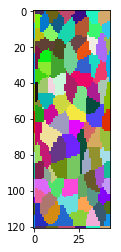

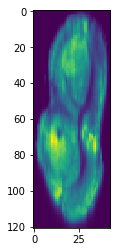

In [20]:
communities = [[2672,2714,2715,2757,2758,2759,2800,2801,2802,2803,2843,2844,2845,2846,2847,2848,2886,2887,2888,2889,2890,2891,2892,2893,2929,2930,2931,2932,2933,2934,2935,2936,2937,2938,2971,2972,2973,2974,2975,2976,2977,2978,2979,2980,2981,2982,3014,3015,3016,3017,3018,3019,3020,3021,3022,3023,3024,3025,3057,3058,3059,3060,3061,3062,3063,3064,3065,3066,3100,3101,3102,3103,3104,3105,3106,3107,3108,3144,3145,3146,3147,3148,3149,3150,3151,3188,3189,3190,3191,3192,3232,3233,3234,3235,3276,3277,3278,3320,3363],[836,837,878,879,880,921,922,923,924,963,964,965,966,967,1006,1007,1008,1009,1010,1011,1049,1050,1051,1052,1053,1054,1092,1093,1094,1095,1096,1097,1098,1135,1136,1137,1138,1139,1140,1141,1178,1179,1180,1181,1182,1183,1184,1221,1222,1223,1224,1225,1226,1227,1228,1264,1265,1266,1267,1268,1269,1270,1271,1307,1308,1309,1310,1311,1312,1313,1350,1351,1352,1353,1354,1355,1356,1393,1394,1395,1396,1397,1398,1399,1437,1438,1439,1440,1441,1480,1481,1482,1483,1484,1524,1525,1526,1568],[3067,3068,3109,3110,3111,3112,3152,3153,3154,3155,3193,3194,3195,3196,3197,3198,3199,3236,3237,3238,3239,3240,3241,3242,3279,3280,3281,3282,3283,3284,3285,3321,3322,3323,3324,3325,3326,3327,3328,3364,3365,3366,3367,3368,3369,3370,3371,3406,3407,3408,3409,3410,3411,3412,3413,3414,3449,3450,3451,3452,3453,3454,3455,3456,3457,3493,3494,3495,3496,3497,3498,3499,3500,3536,3537,3538,3539,3540,3541,3542,3543,3579,3580,3581,3582,3583,3584,3585,3622,3623,3624,3625,3626,3665,3666,3667],[3026,3027,3028,3029,3030,3031,3069,3070,3071,3072,3073,3074,3075,3113,3114,3115,3116,3117,3118,3119,3156,3157,3158,3159,3160,3161,3162,3163,3200,3201,3202,3203,3204,3205,3206,3207,3243,3244,3245,3246,3247,3248,3249,3250,3286,3287,3288,3289,3290,3291,3292,3293,3329,3330,3331,3332,3333,3334,3335,3336,3372,3373,3374,3375,3376,3377,3378,3379,3415,3416,3417,3418,3419,3420,3421,3422,3458,3459,3460,3461,3462,3463,3464,3465,3501,3502,3503,3504,3505,3506,3544,3545,3546],[2468,2510,2511,2512,2551,2552,2553,2554,2555,2592,2593,2594,2595,2596,2597,2598,2599,2634,2635,2636,2637,2638,2639,2640,2641,2642,2677,2678,2679,2680,2681,2682,2683,2684,2685,2719,2720,2721,2722,2723,2724,2725,2726,2727,2728,2761,2762,2763,2764,2765,2766,2767,2768,2769,2770,2771,2804,2805,2806,2807,2808,2809,2810,2811,2812,2813,2814,2849,2850,2851,2852,2853,2854,2855,2856,2857,2894,2895,2896,2897,2898,2899,2900,2939,2940,2941,2942,2943,2983,2984,2985,2986],[4444,4451,4452,4453,4487,4488,4490,4491,4492,4493,4494,4495,4496,4529,4530,4531,4532,4533,4534,4535,4536,4537,4538,4539,4571,4572,4573,4574,4575,4576,4577,4578,4579,4580,4581,4582,4615,4616,4617,4618,4619,4620,4621,4622,4623,4624,4625,4658,4659,4660,4661,4662,4663,4664,4665,4666,4667,4668,4704,4705,4706,4707,4708,4709,4710,4711,4747,4748,4749,4750,4751,4752,4753,4754,4791,4792,4793,4794,4795,4796,4797,4834,4835,4836,4837,4838,4839,4878,4879],[3507,3508,3547,3548,3549,3550,3551,3588,3589,3590,3591,3592,3593,3594,3631,3632,3633,3634,3635,3636,3637,3674,3675,3676,3677,3678,3679,3680,3717,3718,3719,3720,3721,3722,3723,3760,3761,3762,3763,3764,3765,3766,3803,3804,3805,3806,3807,3808,3809,3846,3847,3848,3849,3850,3851,3852,3889,3890,3891,3892,3893,3894,3895,3932,3933,3934,3935,3936,3937,3938,3975,3976,3977,3978,3979,3980,3981,4018,4019,4020,4021,4022,4023,4061,4062,4063,4064,4065],[1873,1874,1875,1876,1916,1917,1918,1919,1920,1959,1960,1961,1962,1963,1964,2002,2003,2004,2005,2006,2007,2044,2045,2046,2047,2048,2049,2050,2087,2088,2089,2090,2091,2092,2093,2130,2131,2132,2133,2134,2135,2136,2172,2173,2174,2175,2176,2177,2178,2215,2216,2217,2218,2219,2220,2221,2258,2259,2260,2261,2262,2263,2264,2301,2302,2303,2304,2305,2306,2307,2345,2346,2347,2348,2349,2350,2389,2390,2391,2392,2393,2434,2435,2436,2479],[236,278,279,320,321,322,323,362,363,364,365,366,404,405,406,407,408,409,446,447,448,449,450,451,452,489,490,491,492,493,494,495,531,532,533,534,535,536,537,538,574,575,576,577,578,579,580,581,616,617,618,619,620,621,622,623,624,659,660,661,662,663,664,665,666,667,702,703,704,705,706,707,708,709,747,748,749,750,751,791,792,793,834,835],[1523,1566,1567,1609,1610,1611,1652,1653,1654,1655,1695,1696,1697,1698,1699,1738,1739,1740,1741,1742,1781,1782,1783,1784,1785,1786,1823,1824,1825,1826,1827,1828,1829,1830,1866,1867,1868,1869,1870,1871,1872,1909,1910,1911,1912,1913,1914,1915,1952,1953,1954,1955,1956,1957,1958,1996,1997,1998,1999,2000,2001,2039,2040,2041,2042,2043,2082,2083,2084,2085,2086,2126,2127,2128,2129,2169,2170,2171,2213,2214,2257],[2316,2317,2359,2360,2401,2402,2403,2443,2444,2445,2446,2485,2486,2487,2488,2489,2526,2527,2528,2529,2530,2531,2532,2566,2567,2568,2569,2570,2571,2572,2573,2574,2575,2609,2610,2611,2612,2613,2614,2615,2616,2617,2652,2653,2654,2655,2656,2657,2658,2659,2660,2696,2697,2698,2699,2700,2701,2702,2703,2740,2741,2742,2743,2744,2745,2746,2783,2784,2785,2786,2787,2788,2789,2827,2828,2829,2830,2831,2832],[1042,1085,1128,1129,1171,1172,1173,1174,1214,1215,1216,1217,1218,1219,1220,1257,1258,1259,1260,1261,1262,1263,1300,1301,1302,1303,1304,1305,1306,1343,1344,1345,1346,1347,1348,1349,1386,1387,1388,1389,1390,1391,1392,1429,1430,1431,1432,1433,1434,1435,1436,1472,1473,1474,1475,1476,1477,1478,1479,1515,1516,1517,1518,1519,1520,1521,1522,1558,1559,1560,1561,1562,1600,1601,1602,1603,1644,1645],[3586,3587,3627,3628,3629,3630,3668,3669,3670,3671,3672,3673,3708,3709,3710,3711,3712,3713,3714,3715,3716,3751,3752,3753,3754,3755,3756,3757,3758,3759,3794,3795,3796,3797,3798,3799,3800,3801,3802,3838,3839,3840,3841,3842,3843,3844,3845,3881,3882,3883,3884,3885,3886,3887,3888,3925,3926,3927,3928,3929,3930,3931,3968,3969,3970,3971,3972,3973,3974,4012,4013,4014,4015,4016,4017,4059,4060],[1527,1528,1529,1530,1569,1570,1571,1572,1573,1574,1575,1576,1577,1578,1579,1612,1613,1614,1615,1616,1617,1618,1619,1620,1621,1622,1656,1657,1658,1659,1660,1661,1662,1663,1664,1665,1666,1700,1701,1702,1703,1704,1705,1706,1707,1708,1709,1743,1744,1745,1746,1747,1748,1749,1750,1751,1752,1787,1788,1789,1790,1791,1792,1793,1794,1831,1832,1833,1834,1835,1836,1837,1877,1878,1879,1921],[2038,2077,2078,2079,2080,2081,2119,2120,2121,2122,2123,2124,2125,2161,2162,2163,2164,2165,2166,2167,2168,2204,2205,2206,2207,2208,2209,2210,2211,2212,2247,2248,2249,2250,2251,2252,2253,2254,2255,2256,2290,2291,2292,2293,2294,2295,2296,2297,2298,2299,2334,2335,2336,2337,2338,2339,2340,2341,2377,2378,2379,2380,2381,2382,2383,2421,2422,2423,2424,2425,2426,2465,2466,2467,2508,2509],[4702,4703,4745,4746,4788,4789,4790,4831,4832,4833,4874,4875,4876,4877,4917,4918,4919,4920,4921,4959,4960,4961,4962,4963,4964,5002,5003,5004,5005,5006,5007,5008,5044,5045,5046,5047,5048,5049,5050,5051,5052,5086,5087,5088,5089,5090,5091,5092,5093,5094,5095,5128,5129,5130,5131,5132,5133,5134,5135,5136,5137,5138,5168,5169,5170,5171,5172,5173,5174,5175,5176,5177,5178,5179,5180,5181],[4066,4102,4103,4104,4105,4106,4107,4108,4109,4145,4146,4147,4148,4149,4150,4151,4152,4188,4189,4190,4191,4192,4193,4194,4195,4231,4232,4233,4234,4235,4236,4237,4238,4274,4275,4276,4277,4278,4279,4280,4281,4316,4317,4318,4319,4320,4321,4322,4323,4324,4359,4360,4361,4362,4363,4364,4365,4366,4367,4402,4403,4404,4405,4406,4407,4408,4409,4410,4445,4446,4447,4448,4449,4450,4489],[2875,2918,2919,2961,2962,2963,2964,2965,2966,2967,3004,3005,3006,3007,3008,3009,3010,3047,3048,3049,3050,3051,3052,3053,3090,3091,3092,3093,3094,3095,3096,3133,3134,3135,3136,3137,3138,3139,3176,3177,3178,3179,3180,3181,3182,3220,3221,3222,3223,3224,3225,3263,3264,3265,3266,3267,3268,3306,3307,3308,3309,3310,3311,3350,3351,3352,3353,3354,3393,3394,3395,3396,3397],[3341,3342,3343,3344,3345,3346,3347,3385,3386,3387,3388,3389,3390,3428,3429,3430,3431,3432,3433,3471,3472,3473,3474,3475,3476,3514,3515,3516,3517,3518,3519,3557,3558,3559,3560,3561,3562,3601,3602,3603,3604,3605,3606,3644,3645,3646,3647,3648,3649,3687,3688,3689,3690,3691,3692,3730,3731,3732,3733,3734,3735,3773,3774,3775,3776,3777,3778,3816,3817,3818,3819,3859,3860],[4394,4395,4436,4437,4438,4439,4478,4479,4480,4481,4482,4483,4520,4521,4522,4523,4524,4525,4526,4527,4563,4564,4565,4566,4567,4568,4569,4570,4606,4607,4608,4609,4610,4611,4612,4648,4649,4650,4651,4652,4653,4654,4655,4691,4692,4693,4694,4695,4696,4697,4734,4735,4736,4737,4738,4739,4777,4778,4779,4780,4781,4820,4821,4822,4823,4863,4864,4865,4866,4907,4908,4950],[4613,4614,4656,4657,4698,4699,4700,4701,4740,4741,4742,4743,4744,4782,4783,4784,4785,4786,4787,4824,4825,4826,4827,4828,4829,4830,4867,4868,4869,4870,4871,4872,4873,4909,4910,4911,4912,4913,4914,4915,4916,4951,4952,4953,4954,4955,4956,4957,4958,4994,4995,4996,4997,4998,4999,5000,5001,5037,5038,5039,5040,5041,5042,5043,5081,5082,5083,5084,5085,5125,5126,5127],[4840,4841,4842,4843,4880,4881,4882,4883,4884,4885,4886,4887,4888,4889,4922,4923,4924,4925,4926,4927,4928,4929,4930,4931,4965,4966,4967,4968,4969,4970,4971,4972,4973,4974,5009,5010,5011,5012,5013,5014,5015,5016,5017,5053,5054,5055,5056,5057,5058,5059,5096,5097,5098,5099,5100,5101,5102,5139,5140,5141,5142,5143,5144,5145,5182,5183,5184,5185,5186,5187,5188],[243,244,245,285,286,287,288,326,327,328,329,330,331,368,369,370,371,372,373,374,410,411,412,413,414,415,416,417,453,454,455,456,457,458,459,460,496,497,498,499,500,501,502,503,539,540,541,542,543,544,545,546,582,583,584,585,586,587,588,625,626,627,628,629,630,631,672,673,674],[639,640,682,683,684,724,725,726,767,768,769,810,811,812,813,853,854,855,856,895,896,897,898,899,938,939,940,941,942,981,982,983,984,985,986,1024,1025,1026,1027,1028,1029,1067,1068,1069,1070,1071,1072,1110,1111,1112,1113,1114,1115,1154,1155,1156,1157,1158,1197,1198,1199,1200,1201,1241,1242,1243,1244,1285,1286],[1563,1564,1565,1604,1605,1606,1607,1608,1646,1647,1648,1649,1650,1651,1688,1689,1690,1691,1692,1693,1694,1731,1732,1733,1734,1735,1736,1737,1774,1775,1776,1777,1778,1779,1780,1818,1819,1820,1821,1822,1861,1862,1863,1864,1865,1904,1905,1906,1907,1908,1947,1948,1949,1950,1951,1990,1991,1992,1993,1994,1995,2033,2034,2035,2036,2037,2076],[2300,2342,2343,2344,2384,2385,2386,2387,2388,2427,2428,2429,2430,2431,2432,2433,2469,2470,2471,2472,2473,2474,2475,2476,2477,2478,2513,2514,2515,2516,2517,2518,2519,2520,2521,2522,2556,2557,2558,2559,2560,2561,2562,2563,2564,2565,2600,2601,2602,2603,2604,2605,2606,2607,2608,2643,2644,2645,2646,2647,2648,2649,2650,2651,2692,2693,2694],[4055,4056,4057,4058,4097,4098,4099,4100,4101,4137,4139,4140,4141,4142,4143,4144,4179,4180,4181,4182,4183,4184,4185,4186,4187,4223,4224,4225,4226,4227,4228,4229,4230,4266,4267,4268,4269,4270,4271,4272,4273,4310,4311,4312,4313,4314,4315,4353,4354,4355,4356,4357,4358,4396,4397,4398,4399,4400,4401,4440,4441,4442,4443,4484,4485,4486,4528],[3142,3143,3185,3186,3187,3228,3229,3230,3231,3272,3273,3274,3275,3315,3316,3317,3318,3319,3358,3359,3360,3361,3362,3401,3402,3403,3404,3405,3444,3445,3446,3447,3448,3487,3488,3489,3490,3491,3492,3531,3532,3533,3534,3535,3574,3575,3576,3577,3578,3617,3618,3619,3620,3621,3661,3662,3663,3664,3704,3705,3706,3707,3747,3748,3749,3791],[3901,3902,3903,3942,3943,3944,3945,3946,3984,3985,3986,3987,3988,3989,4027,4028,4029,4030,4031,4032,4070,4071,4072,4073,4074,4075,4076,4113,4114,4115,4116,4117,4118,4119,4157,4158,4159,4160,4161,4162,4200,4201,4202,4203,4204,4205,4244,4245,4246,4247,4248,4249,4287,4288,4289,4290,4291,4292,4332,4333,4334,4335,4336,4377,4378,4379],[1804,1805,1806,1847,1848,1849,1890,1891,1892,1933,1934,1935,1975,1976,1977,1978,2018,2019,2020,2021,2061,2062,2063,2064,2104,2105,2106,2107,2146,2147,2148,2149,2150,2189,2190,2191,2192,2193,2232,2233,2234,2235,2236,2275,2276,2277,2278,2279,2318,2319,2320,2321,2322,2361,2362,2363,2364,2365,2404,2405,2406,2407,2408,2447,2490],[2448,2449,2450,2451,2491,2492,2493,2494,2533,2534,2535,2536,2537,2576,2577,2578,2579,2580,2618,2619,2620,2621,2622,2623,2661,2662,2663,2664,2665,2666,2704,2705,2706,2707,2708,2709,2747,2748,2749,2750,2751,2752,2790,2791,2792,2793,2794,2795,2833,2834,2835,2836,2837,2838,2876,2877,2878,2879,2880,2881,2920,2921,2922,2923,2924],[37,38,39,40,41,42,43,80,81,82,83,84,85,86,122,123,124,125,126,127,128,129,165,166,167,168,169,170,171,172,208,209,210,211,212,213,214,215,251,252,253,254,255,256,257,258,294,295,296,297,298,299,300,301,337,338,339,340,341,381,382,424],[1148,1189,1190,1191,1230,1231,1232,1233,1234,1272,1273,1274,1275,1276,1277,1314,1315,1316,1317,1318,1319,1320,1357,1358,1359,1360,1361,1362,1363,1364,1400,1401,1402,1403,1404,1405,1406,1407,1442,1443,1444,1445,1446,1447,1448,1449,1450,1485,1486,1487,1488,1489,1490,1491,1492,1493,1531,1532,1533,1534,1535,1536],[1284,1327,1328,1329,1369,1370,1371,1372,1412,1413,1414,1415,1454,1455,1456,1457,1458,1497,1498,1499,1500,1501,1540,1541,1542,1543,1544,1545,1582,1583,1584,1585,1586,1587,1588,1625,1626,1627,1628,1629,1630,1631,1668,1669,1670,1671,1672,1673,1674,1710,1711,1712,1713,1714,1715,1716,1753,1754,1755,1756,1797,1798],[2907,2908,2950,2951,2992,2993,2994,3034,3035,3036,3037,3077,3078,3079,3080,3120,3121,3122,3123,3124,3164,3165,3166,3167,3208,3209,3210,3211,3251,3252,3253,3254,3294,3295,3296,3297,3337,3338,3339,3340,3380,3381,3382,3423,3424,3425,3466,3467,3509,3510,3552,3553,3595,3596,3638,3681,3724,3767,3810,3853,3896,3939],[701,743,744,745,746,786,787,788,789,790,829,830,831,832,833,872,873,874,875,876,877,915,916,917,918,919,920,957,958,959,960,961,962,1000,1001,1002,1003,1004,1005,1043,1044,1045,1046,1047,1048,1086,1087,1088,1089,1090,1091,1130,1131,1132,1133,1134,1175,1176,1177],[2024,2025,2026,2027,2028,2029,2030,2031,2067,2068,2069,2070,2071,2072,2073,2074,2075,2110,2111,2112,2113,2114,2115,2116,2117,2118,2153,2154,2155,2156,2157,2158,2159,2160,2197,2198,2199,2200,2201,2202,2203,2240,2241,2242,2243,2244,2245,2246,2284,2285,2286,2287,2288,2327,2328,2329,2330,2371,2372],[2873,2874,2915,2916,2917,2958,2959,2960,3000,3001,3002,3003,3042,3043,3044,3045,3046,3085,3086,3087,3088,3089,3127,3128,3129,3130,3131,3132,3170,3171,3172,3173,3174,3175,3212,3213,3214,3215,3216,3217,3218,3219,3255,3256,3257,3258,3259,3260,3261,3262,3298,3299,3300,3301,3302,3303,3304,3305,3348],[694,735,736,737,738,739,775,776,777,778,779,780,781,782,783,784,785,818,819,820,821,822,823,824,825,826,827,828,861,862,863,864,865,866,867,868,869,870,871,906,907,908,909,910,911,912,913,914,950,951,952,953,955,956,993,994,998,999],[2289,2331,2332,2333,2373,2374,2375,2376,2414,2415,2416,2417,2418,2419,2420,2457,2458,2459,2460,2461,2462,2463,2464,2500,2501,2502,2503,2504,2505,2506,2507,2543,2544,2545,2546,2547,2548,2549,2550,2586,2587,2588,2589,2590,2591,2629,2630,2631,2632,2633,2673,2674,2675,2676,2716,2717,2718,2760],[2686,2687,2688,2689,2690,2691,2729,2730,2731,2732,2733,2734,2735,2736,2772,2773,2774,2775,2776,2777,2778,2779,2815,2816,2817,2818,2819,2820,2821,2822,2858,2859,2860,2861,2862,2863,2864,2901,2902,2903,2904,2905,2906,2944,2945,2946,2947,2948,2949,2987,2988,2989,2990,2991,3032,3033,3076],[4637,4679,4680,4681,4721,4722,4723,4724,4725,4763,4764,4765,4766,4767,4768,4806,4807,4808,4809,4810,4811,4850,4851,4852,4853,4854,4855,4893,4894,4895,4896,4897,4898,4937,4938,4939,4940,4941,4980,4981,4982,4983,4984,5024,5025,5026,5027,5067,5068,5069,5070,5111,5112,5154,5155,5197,5198],[760,803,804,845,846,847,887,888,889,890,929,930,931,932,933,971,972,973,974,975,976,1013,1014,1015,1016,1017,1018,1019,1020,1056,1057,1058,1059,1060,1061,1062,1063,1099,1100,1101,1102,1103,1104,1105,1106,1142,1143,1144,1145,1146,1147,1185,1186,1187,1188,1229],[2137,2179,2180,2181,2182,2222,2223,2224,2225,2226,2227,2265,2266,2267,2268,2269,2270,2271,2272,2308,2309,2310,2311,2312,2313,2314,2315,2351,2352,2353,2354,2355,2356,2357,2358,2394,2395,2396,2397,2398,2399,2400,2437,2438,2439,2440,2441,2442,2480,2481,2482,2483,2484,2523,2524,2525],[4645,4646,4647,4688,4689,4690,4731,4732,4733,4774,4775,4776,4817,4818,4819,4860,4861,4862,4903,4904,4905,4906,4946,4947,4948,4949,4989,4990,4991,4992,4993,5032,5033,5034,5035,5036,5075,5076,5077,5078,5079,5080,5118,5119,5120,5121,5122,5123,5124,5161,5162,5163,5164,5165,5166,5167],[1795,1796,1838,1839,1840,1841,1880,1881,1882,1883,1884,1922,1923,1924,1925,1926,1927,1965,1966,1967,1968,1969,1970,2008,2009,2010,2011,2012,2013,2051,2052,2053,2054,2055,2056,2057,2094,2095,2096,2097,2098,2099,2100,2138,2139,2140,2141,2142,2143,2183,2184,2185,2186,2228,2229],[29,30,31,32,33,34,35,36,72,73,74,75,76,77,78,79,115,116,117,118,119,120,121,158,159,160,161,162,163,164,202,203,204,205,206,207,246,247,248,249,250,289,290,291,292,293,333,334,335,336,376,377,378,379],[332,375,380,418,419,420,421,422,423,461,462,463,464,465,466,467,504,505,506,507,508,509,510,547,548,549,550,551,552,553,589,590,591,592,593,594,595,596,597,632,633,634,635,636,637,638,676,677,678,679,680,681,722,723],[3982,3983,4024,4025,4026,4067,4068,4069,4110,4111,4112,4153,4154,4155,4156,4196,4197,4198,4199,4239,4240,4241,4242,4243,4282,4283,4284,4285,4286,4325,4326,4327,4328,4329,4368,4369,4370,4371,4372,4411,4412,4413,4414,4415,4454,4455,4456,4457,4458,4497,4498,4499,4500,4540],[4805,4847,4848,4849,4890,4891,4892,4932,4933,4934,4935,4936,4975,4976,4977,4978,4979,5018,5019,5020,5021,5022,5023,5060,5061,5062,5063,5064,5065,5066,5103,5104,5105,5106,5107,5108,5109,5110,5146,5147,5148,5149,5150,5151,5152,5153,5189,5190,5191,5192,5193,5194,5195,5196],[3383,3384,3426,3427,3468,3469,3470,3511,3512,3513,3554,3555,3556,3597,3598,3599,3600,3639,3640,3641,3642,3643,3682,3683,3684,3685,3686,3725,3726,3727,3728,3729,3768,3769,3770,3771,3772,3811,3812,3813,3814,3815,3854,3855,3856,3857,3858,3897,3898,3899,3900,3940,3941],[1074,1075,1117,1118,1159,1160,1161,1202,1203,1204,1245,1246,1247,1287,1288,1289,1290,1330,1331,1332,1333,1373,1374,1375,1376,1416,1417,1418,1419,1459,1460,1461,1462,1502,1503,1504,1505,1546,1547,1548,1589,1590,1591,1632,1633,1634,1676,1677,1719,1720,1762,1763],[668,669,670,671,710,711,712,713,714,715,716,717,752,753,754,755,756,757,758,759,794,795,796,797,798,799,800,801,802,838,839,840,841,842,843,844,881,882,883,884,885,886,925,926,927,928,968,969,970,1012,1055],[1107,1149,1150,1151,1152,1153,1192,1193,1194,1195,1196,1235,1236,1237,1238,1239,1240,1278,1279,1280,1281,1282,1283,1321,1322,1323,1324,1325,1326,1365,1366,1367,1368,1408,1409,1410,1411,1451,1452,1453,1494,1495,1496,1537,1538,1539,1580,1581,1623,1624,1667],[1675,1717,1718,1757,1758,1759,1760,1761,1799,1800,1801,1802,1803,1842,1843,1844,1845,1846,1885,1886,1887,1888,1889,1928,1929,1930,1931,1932,1971,1972,1973,1974,2014,2015,2016,2017,2058,2059,2060,2101,2102,2103,2144,2145,2187,2188,2230,2231,2273,2274],[4086,4087,4088,4089,4090,4091,4129,4130,4131,4132,4133,4134,4135,4172,4173,4174,4175,4176,4177,4178,4215,4216,4217,4218,4219,4220,4221,4222,4258,4259,4260,4261,4262,4263,4264,4265,4303,4304,4305,4306,4307,4308,4309,4348,4349,4350,4351,4352,4392,4393],[3779,3820,3821,3822,3861,3862,3863,3864,3865,3904,3905,3906,3907,3908,3947,3948,3949,3950,3951,3990,3991,3992,3993,3994,4033,4034,4035,4036,4037,4077,4078,4079,4080,4081,4120,4121,4122,4123,4163,4164,4165,4166,4206,4207,4208,4250,4251,4293,4294],[14,15,16,17,18,19,20,21,22,57,58,59,60,61,62,63,64,65,101,102,103,104,105,106,107,108,144,145,146,147,148,149,150,188,189,190,191,192,232,233,234,235,275,276,277,318,319,361],[23,24,25,26,27,28,66,67,68,69,70,71,109,110,111,112,113,114,151,152,153,154,155,156,157,193,194,195,196,197,198,199,200,201,237,238,239,240,241,242,280,281,282,283,284,324,325,367],[143,186,187,228,229,230,231,269,270,271,272,273,274,312,313,314,315,316,317,354,355,356,357,358,359,360,397,398,399,400,401,402,403,441,442,443,444,445,484,485,486,487,488,528,529,530,572,573],[2695,2737,2738,2739,2780,2781,2782,2823,2824,2825,2826,2865,2866,2867,2868,2869,2870,2871,2872,2909,2910,2911,2912,2913,2914,2952,2953,2954,2955,2956,2957,2995,2996,2997,2998,2999,3038,3039,3040,3041,3081,3082,3083,3084,3125,3126,3168,3169],[4330,4331,4373,4374,4375,4376,4416,4417,4418,4419,4420,4421,4422,4459,4460,4461,4462,4463,4464,4502,4503,4504,4505,4506,4507,4545,4546,4547,4548,4549,4550,4588,4589,4590,4591,4592,4593,4632,4633,4634,4635,4636,4675,4676,4677,4678,4719,4720],[342,343,344,383,384,385,386,387,425,426,427,428,429,430,468,469,470,471,472,473,511,512,513,514,515,516,554,555,556,557,558,559,598,599,600,601,602,641,642,643,644,645,685,686,687,688,729],[396,438,439,440,480,481,482,483,522,523,524,525,526,527,564,565,566,567,568,569,570,571,608,609,610,611,612,613,614,615,651,652,653,654,655,656,657,658,695,696,697,698,699,700,740,741,742],[3658,3659,3660,3699,3700,3701,3702,3703,3742,3743,3744,3745,3746,3785,3786,3787,3788,3789,3828,3829,3830,3831,3832,3871,3872,3873,3874,3875,3914,3915,3916,3917,3918,3957,3958,3959,3960,3961,4000,4001,4002,4003,4004,4043,4044,4045,4046],[4501,4541,4542,4543,4544,4583,4584,4585,4586,4587,4626,4627,4628,4629,4630,4631,4669,4670,4671,4672,4673,4674,4712,4713,4714,4715,4716,4717,4718,4755,4756,4757,4758,4759,4760,4761,4762,4798,4799,4800,4801,4802,4803,4804,4844,4845,4846],[3349,3391,3392,3434,3435,3436,3437,3438,3439,3440,3477,3478,3479,3480,3481,3482,3483,3520,3521,3522,3523,3524,3525,3526,3563,3564,3565,3566,3567,3568,3569,3607,3608,3609,3610,3611,3612,3650,3651,3652,3653,3654,3655,3693,3694,3736],[4295,4337,4338,4380,4381,4382,4423,4424,4425,4426,4465,4466,4467,4468,4469,4470,4471,4508,4509,4510,4511,4512,4513,4514,4515,4551,4552,4553,4554,4555,4556,4557,4558,4594,4595,4596,4597,4598,4599,4600,4601,4638,4639,4640,4682],[3695,3696,3697,3698,3737,3738,3739,3740,3741,3780,3781,3782,3783,3784,3823,3824,3825,3826,3827,3866,3867,3868,3869,3870,3909,3910,3911,3912,3913,3952,3953,3954,3955,3956,3995,3996,3997,3998,3999,4038,4039,4040,4041,4042],[4082,4083,4084,4085,4124,4125,4126,4127,4128,4167,4168,4169,4170,4171,4209,4210,4211,4212,4213,4214,4252,4253,4254,4255,4256,4257,4296,4297,4298,4299,4300,4339,4340,4341,4342,4343,4383,4384,4385,4386,4427,4428,4429,4472],[49,92,134,135,136,177,178,179,219,220,221,222,223,262,263,264,265,266,305,306,307,308,309,348,349,350,351,352,353,391,392,393,394,395,434,435,436,437,477,478,479,520,521],[1293,1294,1295,1296,1297,1298,1299,1336,1337,1338,1339,1340,1341,1342,1379,1380,1381,1382,1383,1384,1385,1423,1424,1425,1426,1427,1428,1466,1467,1468,1469,1470,1471,1510,1511,1512,1513,1514,1555,1556,1557,1599,1642],[7,8,9,10,11,12,13,50,51,52,53,54,55,56,93,94,95,96,97,98,99,100,137,138,139,140,141,142,180,181,182,183,184,185,224,225,226,227,267,268,310,311],[675,718,719,720,721,761,762,763,764,765,766,805,806,807,808,809,848,849,850,851,852,891,892,893,894,934,935,936,937,977,978,979,980,1021,1022,1023,1064,1065,1066,1108,1109],[954,995,996,997,1037,1038,1039,1040,1041,1079,1080,1081,1082,1083,1084,1122,1123,1124,1125,1126,1127,1165,1166,1167,1168,1169,1170,1207,1208,1209,1210,1211,1212,1213,1250,1251,1252,1253,1254,1255,1256],[2323,2324,2366,2367,2368,2369,2409,2410,2411,2412,2413,2452,2453,2454,2455,2456,2495,2496,2497,2498,2499,2538,2539,2540,2541,2542,2581,2582,2583,2584,2585,2624,2625,2626,2627,2628,2667,2668,2669,2670,2671],[2710,2711,2712,2713,2753,2754,2755,2756,2796,2797,2798,2799,2839,2840,2841,2842,2882,2883,2884,2885,2925,2926,2927,2928,2968,2969,2970,3011,3012,3013,3054,3055,3056,3097,3098,3099,3140,3141,3183,3226],[1641,1682,1683,1684,1724,1725,1726,1727,1767,1768,1769,1770,1809,1810,1811,1812,1813,1852,1853,1854,1855,1856,1895,1896,1897,1898,1899,1938,1939,1940,1941,1942,1981,1982,1983,1984,1985],[1422,1463,1464,1465,1506,1507,1508,1509,1549,1550,1551,1552,1553,1554,1592,1593,1594,1595,1596,1597,1598,1635,1636,1637,1638,1639,1640,1678,1679,1680,1681,1721,1722,1723,1766],[3184,3227,3269,3270,3271,3312,3313,3314,3355,3356,3357,3398,3399,3400,3441,3442,3443,3484,3485,3486,3527,3528,3529,3530,3570,3571,3572,3573,3613,3614,3615,3616,3656,3657],[4301,4302,4344,4345,4346,4347,4387,4388,4389,4390,4391,4430,4431,4432,4433,4434,4435,4473,4474,4475,4476,4477,4516,4517,4518,4519,4559,4560,4561,4562,4602,4603,4604,4605],[727,728,730,731,770,771,772,773,774,814,815,816,817,857,858,859,860,900,901,902,903,943,944,945,946,987,988,989,1030,1031,1032,1073,1116],[904,905,947,948,949,990,991,992,1033,1034,1035,1036,1076,1077,1078,1119,1120,1121,1162,1163,1164,1205,1206,1248,1249,1291,1292,1334,1335,1377,1378,1420,1421],[4641,4642,4643,4644,4683,4684,4685,4686,4687,4726,4727,4728,4729,4730,4769,4770,4771,4772,4773,4812,4813,4814,4815,4816,4856,4857,4858,4859,4899,4900,4901,4902],[1643,1685,1686,1687,1728,1729,1730,1771,1772,1773,1814,1815,1816,1817,1857,1858,1859,1860,1900,1901,1902,1903,1943,1944,1945,1946,1986,1987,1988,1989,2032],[4942,4943,4944,4945,4985,4986,4987,4988,5028,5029,5030,5031,5071,5072,5073,5074,5113,5114,5115,5116,5117,5156,5157,5158,5159,5160,5199,5200,5201,5202,5203],[474,475,476,517,518,519,560,561,562,563,603,604,605,606,607,646,647,648,649,650,689,690,691,692,693,732,733,734],[3790,3833,3834,3835,3876,3877,3878,3919,3920,3921,3922,3962,3963,3964,3965,4005,4006,4007,4008,4047,4048,4049,4050,4051,4092,4093,4094,4136],[130,131,132,173,174,175,176,216,217,218,259,260,261,302,303,304,345,346,347,388,389,390,431,432,433],[1764,1765,1807,1808,1850,1851,1893,1894,1936,1937,1979,1980,2022,2023,2065,2066,2108,2109,2151,2152,2194],[3750,3792,3793,3836,3837,3879,3880,3923,3924,3966,3967,4009,4010,4011,4052,4053,4054,4095,4096,4138],[1,2,3,4,5,6,44,45,46,47,48,87,88,89,90,91,133],[2195,2196,2237,2238,2239,2280,2281,2282,2283,2325,2326],[2370]]
image = np.zeros((x,y,3))
for community in communities:
    color = np.random.randint(1, 255, 3)
    for pixel in community:
        image[pixel//y-1,pixel%y,:] = color
image = image.astype(int)
image
plt.imshow(image)
plt.show()
plt.imshow(data['img'][np.argmax(data['img'][:,20,20]),:,:])
plt.show()

In [66]:
communities = [[588,589,625,626,627,628,629,630,631,632,668,669,670,671,672,673,674,675,709,710,711,712,713,714,715,716,717,718,751,752,753,754,755,756,757,758,759,760,761,794,795,796,797,798,799,800,801,802,803,804,836,837,838,839,840,841,842,843,844,845,846,847,877,878,879,880,881,882,883,884,885,886,887,888,889,890,920,921,922,923,924,925,926,927,928,929,930,931,932,933,963,964,965,966,967,968,969,970,971,972,973,974,975,976,1006,1007,1008,1009,1010,1011,1012,1013,1014,1015,1016,1017,1018,1019,1020,1049,1050,1051,1052,1053,1054,1055,1056,1057,1058,1059,1060,1061,1062,1063,1092,1093,1094,1095,1096,1097,1098,1099,1100,1101,1102,1103,1104,1105,1106,1135,1136,1137,1138,1139,1140,1141,1142,1143,1144,1145,1146,1147,1148,1149,1178,1179,1180,1181,1182,1183,1184,1185,1186,1187,1188,1189,1190,1191,1192,1221,1222,1223,1224,1225,1226,1227,1228,1229,1230,1231,1232,1233,1234,1235,1264,1265,1266,1267,1268,1269,1270,1271,1272,1273,1274,1275,1276,1277,1278,1279,1307,1308,1309,1310,1311,1312,1313,1314,1315,1316,1317,1318,1319,1320,1321,1322,1350,1351,1352,1353,1354,1355,1356,1357,1358,1359,1360,1361,1362,1363,1364,1365,1394,1395,1396,1397,1398,1399,1400,1401,1402,1403,1404,1405,1406,1407,1408,1437,1438,1439,1440,1441,1442,1443,1444,1445,1446,1447,1448,1449,1450,1451,1480,1481,1482,1483,1484,1485,1486,1487,1488,1489,1490,1491,1492,1493,1494,1523,1524,1525,1526,1527,1528,1529,1530,1531,1532,1533,1534,1535,1536,1537,1568,1569,1570,1571,1572,1573,1574,1575,1576,1577,1578,1579,1580,1615,1616,1617,1618,1619,1620,1621,1622,1623,1658,1659,1660,1661,1662,1663,1664,1665,1666,1701,1702,1703,1704,1708,1709,1744,1745,1746,1747],[2416,2457,2458,2459,2500,2501,2502,2503,2504,2505,2506,2507,2508,2509,2510,2542,2543,2544,2545,2546,2547,2548,2549,2550,2551,2552,2553,2585,2586,2587,2588,2589,2590,2591,2592,2593,2594,2595,2596,2628,2629,2630,2631,2632,2633,2634,2635,2636,2637,2638,2639,2671,2672,2673,2674,2675,2676,2677,2678,2679,2680,2681,2682,2714,2715,2716,2717,2718,2719,2720,2721,2722,2723,2724,2725,2755,2756,2757,2758,2759,2760,2761,2762,2763,2764,2765,2766,2767,2768,2798,2799,2800,2801,2802,2803,2804,2805,2806,2807,2808,2809,2810,2811,2841,2842,2843,2844,2845,2846,2847,2848,2849,2850,2851,2852,2853,2884,2885,2886,2887,2888,2889,2890,2891,2892,2893,2894,2895,2896,2927,2928,2929,2930,2931,2932,2933,2934,2935,2936,2937,2938,2939,2970,2971,2972,2973,2974,2975,2976,2977,2978,2979,2980,2981,2982,3013,3014,3015,3016,3017,3018,3019,3020,3021,3022,3023,3024,3025,3056,3057,3058,3059,3060,3061,3062,3063,3064,3065,3066,3099,3100,3101,3102,3103,3104,3105,3106,3107,3108,3109,3142,3143,3144,3145,3146,3147,3148,3149,3150,3151,3152,3185,3186,3187,3188,3189,3190,3191,3192,3228,3229,3230,3231,3232,3233,3234,3235,3271,3272,3273,3274,3275,3276,3277,3278,3314,3315,3316,3317,3318,3319,3320,3321,3357,3358,3359,3360,3361,3362,3363,3364,3400,3401,3402,3403,3404,3405,3406,3407,3443,3444,3445,3446,3447,3448,3449,3450,3486,3487,3488,3489,3490,3491,3492,3493,3530,3531,3532,3533,3534,3535,3536,3573,3574,3575,3576,3577,3578,3579,3617,3618,3619,3620,3621,3622,3660,3661,3662,3663,3664,3665,3704,3705,3706,3707,3708,3748,3749,3750,3751,3752,3791,3792,3793,3794,3795,3834,3835,3836,3837,3838,3877,3878,3879,3880,3881,3920,3921,3922,3923,3924,3963,3964,3965,3966,3967,4007,4008,4009,4010,4050,4051,4052,4053,4093,4094,4095,4096,4137,4138,4139,4180,4223],[3067,3068,3069,3070,3110,3111,3112,3113,3114,3115,3116,3117,3153,3154,3155,3156,3157,3158,3159,3160,3161,3162,3163,3164,3193,3194,3195,3196,3197,3198,3199,3200,3201,3202,3203,3204,3205,3206,3207,3236,3237,3238,3239,3240,3241,3242,3243,3244,3245,3246,3247,3248,3249,3250,3279,3280,3281,3282,3283,3284,3285,3286,3287,3288,3289,3290,3291,3292,3293,3322,3323,3324,3325,3326,3327,3328,3329,3330,3331,3332,3333,3334,3335,3336,3337,3365,3366,3367,3368,3369,3370,3371,3372,3373,3374,3375,3376,3377,3378,3379,3380,3408,3409,3410,3411,3412,3413,3414,3415,3416,3417,3418,3419,3420,3421,3422,3423,3451,3452,3453,3454,3455,3456,3457,3458,3459,3460,3461,3462,3463,3464,3465,3466,3494,3495,3496,3497,3498,3499,3500,3501,3502,3503,3504,3505,3506,3507,3508,3509,3537,3538,3539,3540,3541,3542,3543,3544,3545,3546,3547,3548,3549,3550,3551,3552,3580,3581,3582,3583,3584,3585,3586,3587,3588,3589,3590,3591,3592,3593,3594,3595,3623,3624,3625,3626,3627,3628,3629,3630,3631,3632,3633,3634,3635,3636,3637,3638,3666,3667,3668,3669,3670,3671,3672,3673,3674,3675,3676,3677,3678,3679,3680,3681,3709,3710,3711,3712,3713,3714,3715,3716,3717,3718,3719,3720,3721,3722,3723,3724,3753,3754,3755,3756,3757,3758,3759,3760,3761,3762,3763,3764,3765,3766,3767,3796,3797,3798,3799,3800,3801,3802,3803,3804,3805,3806,3807,3808,3809,3810,3839,3840,3841,3842,3843,3844,3845,3846,3847,3848,3849,3850,3851,3852,3853,3882,3883,3884,3885,3886,3887,3888,3889,3890,3891,3892,3893,3894,3895,3896,3925,3926,3927,3928,3929,3932,3933,3934,3935,3936,3937,3938,3939,3968,3969,3970,3971,3972,3975,3976,3977,3978,3979,3980,3981,4011,4012,4013,4014,4015,4018,4019,4020,4021,4022,4023,4054,4055,4056,4057,4058,4063,4064,4065,4066],[1237,1238,1239,1240,1241,1242,1243,1244,1280,1281,1282,1283,1284,1285,1286,1287,1323,1324,1325,1326,1327,1328,1329,1330,1366,1367,1368,1369,1370,1371,1372,1373,1409,1410,1411,1412,1413,1414,1415,1416,1452,1453,1454,1455,1456,1457,1458,1459,1495,1496,1497,1498,1499,1500,1501,1502,1538,1539,1540,1541,1542,1543,1544,1545,1581,1582,1583,1584,1585,1586,1587,1588,1624,1625,1626,1627,1628,1629,1630,1631,1667,1668,1669,1670,1671,1672,1673,1674,1710,1711,1712,1713,1714,1715,1716,1717,1753,1754,1755,1756,1757,1758,1759,1760,1796,1797,1798,1799,1800,1801,1802,1803,1839,1840,1841,1842,1843,1844,1845,1846,1882,1883,1884,1885,1886,1887,1888,1889,1925,1926,1927,1928,1929,1930,1931,1932,1968,1969,1970,1971,1972,1973,1974,1975,2011,2012,2013,2014,2015,2016,2017,2018,2054,2055,2056,2057,2058,2059,2060,2061,2097,2098,2099,2100,2101,2102,2103,2140,2141,2142,2143,2144,2145,2146,2183,2184,2185,2186,2187,2188,2189,2226,2227,2228,2229,2230,2231,2232,2269,2270,2271,2272,2273,2274,2275,2311,2312,2313,2314,2315,2316,2317,2318,2354,2355,2356,2357,2358,2359,2360,2361,2397,2398,2399,2400,2401,2402,2403,2438,2439,2440,2441,2442,2443,2444,2445,2446,2481,2482,2483,2484,2485,2486,2487,2488,2489,2523,2524,2525,2526,2527,2528,2529,2530,2531,2532,2566,2567,2568,2569,2570,2571,2572,2573,2574,2575,2609,2610,2611,2612,2613,2614,2615,2616,2617,2652,2653,2654,2655,2656,2657,2658,2659,2660,2695,2696,2697,2698,2699,2700,2701,2702,2703,2738,2739,2740,2741,2742,2743,2744,2745,2746,2783,2784,2785,2786,2787,2788,2789,2826,2827,2828,2829,2830,2831,2832,2870,2871,2872,2873,2874,2875,2914,2915,2916,2917,2918,2957,2958,2959,2960],[3930,3931,3973,3974,3982,4016,4017,4024,4025,4026,4027,4059,4060,4061,4062,4067,4068,4069,4070,4102,4103,4104,4105,4106,4107,4108,4109,4110,4111,4112,4113,4145,4146,4147,4148,4149,4150,4151,4152,4153,4154,4155,4156,4188,4189,4190,4191,4192,4193,4194,4195,4196,4197,4198,4199,4231,4232,4233,4234,4235,4236,4237,4238,4239,4240,4241,4242,4274,4275,4276,4277,4278,4279,4280,4281,4282,4283,4284,4285,4317,4318,4319,4320,4321,4322,4323,4324,4325,4326,4327,4328,4329,4360,4361,4362,4363,4364,4365,4366,4367,4368,4369,4370,4371,4372,4402,4403,4404,4405,4406,4407,4408,4409,4410,4411,4412,4413,4414,4415,4445,4446,4447,4448,4449,4450,4451,4452,4453,4454,4455,4456,4457,4458,4488,4489,4490,4491,4492,4493,4494,4495,4496,4497,4498,4499,4500,4531,4532,4533,4534,4535,4536,4537,4538,4539,4540,4541,4542,4543,4574,4575,4576,4577,4578,4579,4580,4581,4582,4583,4584,4585,4586,4618,4619,4620,4621,4622,4623,4624,4625,4626,4627,4628,4629,4661,4662,4663,4664,4665,4666,4667,4668,4669,4670,4671,4672,4673,4674,4704,4705,4706,4707,4708,4709,4710,4711,4712,4713,4714,4715,4716,4717,4718,4747,4748,4749,4750,4751,4752,4753,4754,4755,4756,4757,4758,4759,4760,4790,4791,4792,4793,4794,4795,4796,4797,4798,4799,4800,4801,4802,4803,4833,4834,4835,4836,4837,4838,4839,4840,4841,4842,4843,4844,4845,4846,4877,4878,4879,4880,4881,4882,4883,4884,4885,4886,4887,4888,4920,4921,4922,4923,4924,4925,4926,4927,4928,4929,4930,4965,4966,4967,4968,4969,4970,4971,4972,4973,5009,5010,5011,5012],[1610,1611,1612,1653,1654,1655,1687,1688,1696,1697,1698,1730,1731,1738,1739,1740,1741,1773,1774,1775,1776,1781,1782,1783,1784,1816,1817,1818,1819,1820,1823,1824,1825,1826,1827,1859,1860,1861,1862,1863,1864,1865,1866,1867,1868,1869,1870,1902,1903,1904,1905,1906,1907,1908,1909,1910,1911,1912,1913,1945,1946,1947,1948,1949,1950,1951,1952,1953,1954,1955,1956,1988,1989,1990,1991,1992,1993,1994,1995,1996,1997,1998,1999,2031,2032,2033,2034,2035,2036,2037,2038,2039,2040,2041,2042,2075,2076,2077,2078,2079,2080,2081,2082,2083,2084,2085,2118,2119,2120,2121,2122,2123,2124,2125,2126,2127,2128,2161,2162,2163,2164,2165,2166,2167,2168,2169,2170,2171,2204,2205,2206,2207,2208,2209,2210,2211,2212,2213,2214,2247,2248,2249,2250,2251,2252,2253,2254,2255,2256,2257,2290,2291,2292,2293,2294,2295,2296,2297,2298,2299,2300,2331,2332,2333,2334,2335,2336,2337,2338,2339,2340,2341,2342,2343,2374,2375,2376,2377,2378,2379,2380,2381,2382,2383,2384,2417,2418,2419,2420,2421,2422,2423,2424,2425,2426,2427,2460,2461,2462,2463,2464,2465,2466,2467,2468,2469,2470],[1506,1507,1508,1509,1510,1511,1549,1550,1551,1552,1553,1554,1555,1592,1593,1594,1595,1596,1597,1598,1635,1636,1637,1638,1639,1640,1641,1678,1679,1680,1681,1682,1683,1684,1685,1686,1721,1722,1723,1724,1725,1726,1727,1728,1729,1764,1765,1766,1767,1768,1769,1770,1771,1772,1807,1808,1809,1810,1811,1812,1813,1814,1815,1850,1851,1852,1853,1854,1855,1856,1857,1858,1893,1894,1895,1896,1897,1898,1899,1900,1901,1936,1937,1938,1939,1940,1941,1942,1943,1944,1979,1980,1981,1982,1983,1984,1985,1986,1987,2022,2023,2024,2025,2026,2027,2028,2029,2030,2065,2066,2067,2068,2069,2070,2071,2072,2073,2074,2108,2109,2110,2111,2112,2113,2114,2115,2116,2117,2151,2152,2153,2154,2155,2156,2157,2158,2159,2160,2194,2195,2196,2197,2198,2199,2200,2201,2202,2203,2237,2238,2239,2240,2241,2242,2243,2244,2245,2246,2280,2281,2282,2283,2284,2285,2286,2287,2288,2289,2323,2324,2325,2326,2327,2328,2329,2330,2366,2367,2368,2369,2370,2371,2372,2373,2409,2410,2411,2412,2413,2414,2415,2452,2453,2454,2455,2456,2498,2499],[4266,4309,4352,4353,4395,4396,4433,4434,4435,4436,4437,4438,4439,4440,4476,4477,4478,4479,4480,4481,4482,4483,4516,4517,4518,4519,4520,4521,4522,4523,4524,4525,4526,4559,4560,4561,4562,4563,4564,4565,4566,4567,4568,4569,4602,4603,4604,4605,4606,4607,4608,4609,4610,4611,4612,4645,4646,4647,4648,4649,4650,4651,4652,4653,4654,4655,4688,4689,4690,4691,4692,4693,4694,4695,4696,4697,4698,4731,4732,4733,4734,4735,4736,4737,4738,4739,4740,4741,4774,4775,4776,4777,4778,4779,4780,4781,4782,4783,4784,4817,4818,4819,4820,4821,4822,4823,4824,4825,4826,4827,4860,4861,4862,4863,4864,4865,4866,4867,4868,4869,4870,4903,4904,4905,4906,4907,4908,4909,4910,4911,4912,4913,4946,4947,4948,4949,4950,4951,4952,4953,4954,4955,4956,4989,4990,4991,4992,4993,4994,4995,4996,4997,4998,4999,5032,5033,5034,5035,5036,5037,5038,5039,5040,5041,5042,5075,5076,5077,5078,5079,5080,5081,5082,5083,5084,5085,5118,5119,5120,5121,5122,5123,5124,5125,5126,5127,5128,5161,5162,5163,5164,5165,5166,5167,5168,5169,5170,5171],[25,26,27,28,68,69,70,71,108,109,110,111,112,113,114,150,151,152,153,154,155,156,157,192,193,194,195,196,197,198,199,200,201,202,234,235,236,237,238,239,240,241,242,243,244,245,277,278,279,280,281,282,283,284,285,286,287,288,319,320,321,322,323,324,325,326,327,328,329,330,331,362,363,364,365,366,367,368,369,370,371,372,373,374,403,404,405,406,407,408,409,410,411,412,413,414,415,416,417,446,447,448,449,450,451,452,453,454,455,456,457,458,459,460,489,490,491,492,493,494,495,496,497,498,499,500,501,502,503,530,531,532,533,534,535,536,537,538,539,540,541,542,543,544,545,546,573,574,575,576,577,578,579,580,581,582,583,584,585,586,587,616,617,618,619,620,621,622,623,624,659,660,661,662,663,664,665,666,667,704,705,706,707,708,747,748,749,750,790,791,792,793,834,835],[701,702,703,744,745,746,785,786,787,788,789,828,829,830,831,832,833,871,872,873,874,875,876,914,915,916,917,918,919,956,957,958,959,960,961,962,999,1000,1001,1002,1003,1004,1005,1042,1043,1044,1045,1046,1047,1048,1085,1086,1087,1088,1089,1090,1091,1128,1129,1130,1131,1132,1133,1134,1170,1171,1172,1173,1174,1175,1176,1177,1213,1214,1215,1216,1217,1218,1219,1220,1256,1257,1258,1259,1260,1261,1262,1263,1299,1300,1301,1302,1303,1304,1305,1306,1342,1343,1344,1345,1346,1347,1348,1349,1385,1386,1387,1388,1389,1390,1391,1392,1393,1428,1429,1430,1431,1432,1433,1434,1435,1436,1471,1472,1473,1474,1475,1476,1477,1478,1479,1514,1515,1516,1517,1518,1519,1520,1521,1522,1557,1558,1559,1560,1561,1562,1563,1564,1565,1566,1567,1600,1601,1602,1603,1604,1605,1606,1607,1608,1609,1643,1644,1645,1646,1647,1648,1649,1650,1651,1652,1689,1690,1691,1692,1693,1694,1695,1732,1733,1734,1735,1736,1737,1777,1778,1779,1780,1821,1822],[1613,1614,1656,1657,1699,1700,1705,1706,1707,1742,1743,1748,1749,1750,1751,1752,1785,1786,1787,1788,1789,1790,1791,1792,1793,1794,1795,1828,1829,1830,1831,1832,1833,1834,1835,1836,1837,1838,1871,1872,1873,1874,1875,1876,1877,1878,1879,1880,1881,1914,1915,1916,1917,1918,1919,1920,1921,1922,1923,1924,1957,1958,1959,1960,1961,1962,1963,1964,1965,1966,1967,2000,2001,2002,2003,2004,2005,2006,2007,2008,2009,2010,2043,2044,2045,2046,2047,2048,2049,2050,2051,2052,2053,2086,2087,2088,2089,2090,2091,2092,2093,2094,2095,2096,2131,2132,2133,2134,2135,2136,2137,2138,2139,2175,2176,2177,2178,2179,2180,2181,2182,2218,2219,2220,2221,2222,2223,2224,2225,2262,2263,2264,2265,2266,2267,2268,2305,2306,2307,2308,2309,2310,2348,2349,2350,2351,2352,2353,2391,2392,2393,2394,2395,2396,2434,2435,2436,2437,2477,2478,2479,2480,2520,2521,2522,2563,2564,2565,2606,2607,2608,2649,2650,2651,2692,2693,2694,2735,2736,2737,2778,2779,2821,2822,2864,2865,2907],[3427,3428,3429,3430,3431,3432,3470,3471,3472,3473,3474,3475,3513,3514,3515,3516,3517,3518,3556,3557,3558,3559,3560,3561,3599,3600,3601,3602,3603,3604,3642,3643,3644,3645,3646,3647,3685,3686,3687,3688,3689,3690,3728,3729,3730,3731,3732,3733,3771,3772,3773,3774,3775,3776,3813,3814,3815,3816,3817,3818,3819,3856,3857,3858,3859,3860,3861,3862,3899,3900,3901,3902,3903,3904,3905,3942,3943,3944,3945,3946,3947,3948,3985,3986,3987,3988,3989,3990,3991,4028,4029,4030,4031,4032,4033,4034,4071,4072,4073,4074,4075,4076,4077,4114,4115,4116,4117,4118,4119,4120,4121,4157,4158,4159,4160,4161,4162,4163,4164,4200,4201,4202,4203,4204,4205,4206,4207,4243,4244,4245,4246,4247,4248,4249,4250,4286,4287,4288,4289,4290,4291,4292,4293,4330,4331,4332,4333,4334,4335,4336,4373,4374,4375,4376,4377,4378,4416,4417,4418,4419,4420,4421,4459,4460,4461,4462,4463,4501,4502,4503,4504,4505,4506,4544,4545,4546,4547,4548,4587,4588,4589,4590,4630,4631,4632,4633,4675],[2404,2447,2490,2491,2492,2493,2494,2533,2534,2535,2536,2537,2576,2577,2578,2579,2580,2618,2619,2620,2621,2622,2623,2661,2662,2663,2664,2665,2666,2704,2705,2706,2707,2708,2709,2747,2748,2749,2750,2751,2752,2790,2791,2792,2793,2794,2795,2833,2834,2835,2836,2837,2838,2876,2877,2878,2879,2880,2881,2919,2920,2921,2922,2923,2924,2962,2963,2964,2965,2966,2967,3005,3006,3007,3008,3009,3010,3048,3049,3050,3051,3052,3053,3091,3092,3093,3094,3095,3096,3134,3135,3136,3137,3138,3139,3177,3178,3179,3180,3181,3182,3220,3221,3222,3223,3224,3225,3263,3264,3265,3266,3267,3268,3306,3307,3308,3309,3310,3311,3350,3351,3352,3353,3354,3393,3394,3395,3396,3397,3436,3437,3438,3439,3440,3479,3480,3481,3482,3483,3522,3523,3524,3525,3526,3565,3566,3567,3568,3569,3608,3609,3610,3611,3612,3651,3652,3653,3654,3655,3695,3696,3697,3698,3738,3739,3740,3741,3781,3782,3783,3784,3824,3825,3826,3827,3867,3868,3869,3870,3910,3911,3953,3954,3996,4039],[7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,136,137,138,139,140,141,142,143,144,145,146,147,148,149,179,180,181,182,183,184,185,186,187,188,189,190,191,222,223,224,225,226,227,228,229,230,231,232,233,265,266,267,268,269,270,271,272,273,274,275,276,308,309,310,311,312,313,314,315,316,317,318,351,352,353,354,355,356,357,358,359,360,361,394,395,396,397,398,399,400,401,402,437,438,439,440,441,442,443,444,445,480,481,482,483,484,485,486,487,488,523,524,525,526,527,528,529,566,567,568,569,570,571,572,610,611,612,613,614,615,653,654,655,656,657,658,699,700,742,743],[2780,2781,2782,2823,2824,2825,2866,2867,2868,2869,2908,2909,2910,2911,2912,2913,2950,2951,2952,2953,2954,2955,2956,2961,2993,2994,2995,2996,2997,2998,2999,3000,3001,3002,3003,3004,3036,3037,3038,3039,3040,3041,3042,3043,3044,3045,3046,3047,3079,3080,3081,3082,3083,3084,3085,3086,3087,3088,3089,3090,3122,3123,3124,3125,3126,3127,3128,3129,3130,3131,3132,3133,3165,3166,3167,3168,3169,3170,3171,3172,3173,3174,3175,3176,3208,3209,3210,3211,3212,3213,3214,3215,3216,3217,3218,3219,3251,3252,3253,3254,3255,3256,3257,3258,3259,3260,3261,3262,3294,3295,3296,3297,3298,3299,3300,3301,3302,3303,3304,3305,3338,3339,3340,3341,3342,3343,3344,3345,3346,3347,3348,3349,3381,3382,3383,3384,3385,3386,3387,3388,3389,3390,3391,3392,3424,3425,3426,3467,3468,3469,3510,3511,3512,3553,3554,3555,3596,3597,3598,3639,3640,3641,3682,3683,3684,3725,3726,3727,3768,3769,3770,3811,3812,3854,3855,3897,3898,3940,3941,3983,3984],[289,291,292,293,332,334,335,336,375,376,377,378,379,380,381,418,419,420,421,422,423,424,461,462,463,464,465,466,467,504,505,506,507,508,509,510,547,548,549,550,551,552,553,554,590,591,592,593,594,595,596,597,633,634,635,636,637,638,639,640,676,677,678,679,680,681,682,683,719,720,721,722,723,724,725,726,762,763,764,765,766,767,768,769,770,805,806,807,808,809,810,811,812,813,848,849,850,851,852,853,854,855,856,891,892,893,894,895,896,897,898,899,900,934,935,936,937,938,939,940,941,942,943,977,978,979,980,981,982,983,984,985,986,1021,1022,1023,1024,1025,1026,1027,1028,1029,1064,1065,1066,1067,1068,1069,1070,1071,1072,1107,1108,1109,1110,1111,1112,1113,1114,1115,1150,1151,1152,1153,1154,1155,1156,1157,1158,1193,1194,1195,1196,1197,1198,1199,1200,1201,1236],[2129,2130,2172,2173,2174,2215,2216,2217,2258,2259,2260,2261,2301,2302,2303,2304,2344,2345,2346,2347,2385,2386,2387,2388,2389,2390,2428,2429,2430,2431,2432,2433,2471,2472,2473,2474,2475,2476,2511,2512,2513,2514,2515,2516,2517,2518,2519,2554,2555,2556,2557,2558,2559,2560,2561,2562,2597,2598,2599,2600,2601,2602,2603,2604,2605,2640,2641,2642,2643,2644,2645,2646,2647,2648,2683,2684,2685,2686,2687,2688,2689,2690,2691,2726,2727,2728,2729,2730,2731,2732,2733,2734,2769,2770,2771,2772,2773,2774,2775,2776,2777,2812,2813,2814,2815,2816,2817,2818,2819,2820,2854,2855,2856,2857,2858,2859,2860,2861,2862,2863,2897,2898,2899,2900,2901,2902,2903,2904,2905,2906,2940,2941,2942,2943,2944,2945,2946,2947,2948,2949,2983,2984,2985,2986,2987,2988,2989,2990,2991,2992,3026,3027,3028,3029,3030,3031,3032,3033,3034,3035,3071,3072,3073,3074,3075,3076,3077,3078,3118,3119,3120,3121],[4165,4166,4208,4209,4251,4252,4294,4295,4337,4338,4379,4380,4381,4422,4423,4424,4464,4465,4466,4467,4507,4508,4509,4510,4549,4550,4551,4552,4553,4591,4592,4593,4594,4595,4596,4634,4635,4636,4637,4638,4639,4676,4677,4678,4679,4680,4681,4682,4719,4720,4721,4722,4723,4724,4725,4761,4762,4763,4764,4765,4766,4767,4768,4804,4805,4806,4807,4808,4809,4810,4847,4848,4849,4850,4851,4852,4853,4889,4890,4891,4892,4893,4894,4895,4896,4931,4932,4933,4934,4935,4936,4937,4938,4939,4974,4975,4976,4977,4978,4979,4980,4981,4982,5013,5014,5015,5016,5017,5018,5019,5020,5021,5022,5023,5024,5025,5056,5057,5058,5059,5060,5061,5062,5063,5064,5065,5066,5067,5068,5099,5100,5101,5102,5103,5104,5105,5106,5107,5108,5109,5110,5111,5142,5143,5144,5145,5146,5147,5148,5149,5150,5151,5152,5153,5154,5185,5186,5187,5188,5189,5190,5191,5192,5193,5194,5195,5196,5197],[696,697,698,739,740,741,779,780,781,782,783,784,818,819,820,821,822,823,824,825,826,827,861,862,863,864,865,866,867,868,869,870,904,905,906,907,908,909,910,911,912,913,947,948,949,950,951,952,953,954,955,990,991,992,993,994,995,996,997,998,1033,1034,1035,1036,1037,1038,1039,1040,1041,1076,1077,1078,1079,1080,1081,1082,1083,1084,1119,1120,1121,1122,1123,1124,1125,1126,1127,1162,1163,1164,1165,1166,1167,1168,1169,1205,1206,1207,1208,1209,1210,1211,1212,1248,1249,1250,1251,1252,1253,1254,1255,1291,1292,1293,1294,1295,1296,1297,1298,1334,1335,1336,1337,1338,1339,1340,1341,1377,1378,1379,1380,1381,1382,1383,1384,1420,1421,1422,1423,1424,1425,1426,1427,1463,1464,1465,1466,1467,1468,1469,1470,1512,1513,1556,1599,1642],[3912,3913,3955,3956,3997,3998,3999,4040,4041,4042,4081,4082,4083,4084,4085,4124,4125,4126,4127,4128,4167,4168,4169,4170,4171,4210,4211,4212,4213,4214,4253,4254,4255,4256,4257,4296,4297,4298,4299,4300,4339,4340,4341,4342,4343,4382,4383,4384,4385,4386,4425,4426,4427,4428,4429,4468,4469,4470,4471,4472,4511,4512,4513,4514,4515,4554,4555,4556,4557,4558,4597,4598,4599,4600,4601,4640,4641,4642,4643,4644,4683,4684,4685,4686,4687,4726,4727,4728,4729,4730,4769,4770,4771,4772,4773,4811,4812,4813,4814,4815,4816,4854,4855,4856,4857,4858,4859,4897,4898,4899,4900,4901,4902,4940,4941,4942,4943,4944,4945,4983,4984,4985,4986,4987,4988,5026,5027,5028,5029,5030,5031,5069,5070,5071,5072,5073,5074,5112,5113,5114,5115,5116,5117,5155,5156,5157,5158,5159,5160,5198,5199,5200,5201,5202,5203],[3399,3442,3484,3485,3527,3528,3529,3570,3571,3572,3613,3614,3615,3616,3656,3657,3658,3659,3699,3700,3701,3702,3703,3742,3743,3744,3745,3746,3747,3785,3786,3787,3788,3789,3790,3828,3829,3830,3831,3832,3833,3871,3872,3873,3874,3875,3876,3914,3915,3916,3917,3918,3919,3957,3958,3959,3960,3961,3962,4000,4001,4002,4003,4004,4005,4006,4043,4044,4045,4046,4047,4048,4049,4086,4087,4088,4089,4090,4091,4092,4129,4130,4131,4132,4133,4134,4135,4136,4172,4173,4174,4175,4176,4177,4178,4179,4215,4216,4217,4218,4219,4220,4221,4222,4258,4259,4260,4261,4262,4263,4264,4265,4301,4302,4303,4304,4305,4306,4307,4308,4344,4345,4346,4347,4348,4349,4350,4351,4387,4388,4389,4390,4391,4392,4393,4394,4430,4431,4432,4473,4474,4475],[38,39,40,41,42,43,81,82,83,84,85,86,124,125,126,127,128,129,167,168,169,170,171,172,210,211,212,213,214,215,253,254,255,256,257,258,296,297,298,299,300,301,339,340,341,342,343,344,382,383,384,385,386,387,425,426,427,428,429,430,468,469,470,471,472,473,511,512,513,514,515,516,555,556,557,558,559,598,599,600,601,602,641,642,643,644,645,684,685,686,687,688,727,728,729,730,731,771,772,773,774,814,815,816,817,857,858,859,860,901,902,903,944,945,946,987,988,989,1030,1031,1032,1073,1074,1075,1118],[1,2,3,4,5,6,44,45,46,47,48,49,87,88,89,90,91,92,130,131,132,133,134,135,173,174,175,176,177,178,216,217,218,219,220,221,259,260,261,262,263,264,302,303,304,305,306,307,345,346,347,348,349,350,388,389,390,391,392,393,431,432,433,434,435,436,474,475,476,477,478,479,517,518,519,520,521,522,560,561,562,563,564,565,603,604,605,606,607,608,609,646,647,648,649,650,651,652,689,690,691,692,693,694,695,732,733,734,735,736,737,738,775,776,777,778],[4570,4613,4614,4615,4616,4617,4656,4657,4658,4659,4660,4699,4700,4701,4702,4703,4742,4743,4744,4745,4746,4785,4786,4787,4788,4789,4828,4829,4830,4831,4832,4871,4872,4873,4874,4875,4876,4914,4915,4916,4917,4918,4919,4957,4958,4959,4960,4961,4962,4963,4964,5000,5001,5002,5003,5004,5005,5006,5007,5008,5043,5044,5045,5046,5047,5048,5049,5050,5051,5052,5053,5054,5055,5086,5087,5088,5089,5090,5091,5092,5093,5094,5095,5096,5097,5098,5129,5130,5131,5132,5133,5134,5135,5136,5137,5138,5139,5140,5141,5172,5173,5174,5175,5176,5177,5178,5179,5180,5181,5182,5183,5184],[1116,1117,1159,1160,1161,1202,1203,1204,1245,1246,1247,1288,1289,1290,1331,1332,1333,1374,1375,1376,1417,1418,1419,1460,1461,1462,1503,1504,1505,1546,1547,1548,1589,1590,1591,1632,1633,1634,1675,1676,1677,1718,1719,1720,1761,1762,1763,1804,1805,1806,1847,1848,1849,1890,1891,1892,1933,1934,1935,1976,1977,1978,2019,2020,2021,2062,2063,2064,2104,2105,2106,2107,2147,2148,2149,2150,2190,2191,2192,2193,2233,2234,2235,2236,2276,2277,2278,2279,2319,2320,2321,2322,2362,2363,2364,2365,2405,2406,2407,2408,2448,2449,2450,2451],[4097,4098,4099,4100,4101,4140,4141,4142,4143,4144,4181,4182,4183,4184,4185,4186,4187,4224,4225,4226,4227,4228,4229,4230,4267,4268,4269,4270,4271,4272,4273,4310,4311,4312,4313,4314,4315,4316,4354,4355,4356,4357,4358,4359,4397,4398,4399,4400,4401,4441,4442,4443,4444,4484,4485,4486,4487,4527,4528,4529,4530,4571,4572,4573],[3433,3434,3435,3476,3477,3478,3519,3520,3521,3562,3563,3564,3605,3606,3607,3648,3649,3650,3691,3692,3693,3694,3734,3735,3736,3737,3777,3778,3779,3780,3820,3821,3822,3823,3863,3864,3865,3866,3906,3907,3908,3909,3949,3950,3951,3952,3992,3993,3994,3995,4035,4036,4037,4038,4078,4079,4080,4122,4123],[29,30,31,32,33,34,35,36,37,72,73,74,75,76,77,78,79,80,115,116,117,118,119,120,121,122,123,158,159,160,161,162,163,164,165,166,203,204,205,206,207,208,209,246,247,248,249,250,251,252,290,294,295,333,337,338],[2495,2496,2497,2538,2539,2540,2541,2581,2582,2583,2584,2624,2625,2626,2627,2667,2668,2669,2670,2710,2711,2712,2713,2753,2754,2796,2797,2839,2840,2882,2883,2925,2926,2968,2969,3011,3012,3054,3055,3097,3098,3140,3141,3183,3184,3226,3227,3269,3270,3312,3313,3355,3356,3398,3441]]
image = np.zeros((x,y,3))
for community in communities:
    color = np.random.randint(1, 255, 3)
    for pixel in community:
        image[pixel//y-1,pixel%y,:] = color
image = image.astype(int)
image
plt.imshow(image)
plt.show()
plt.imshow(data['img'][np.argmax(data['img'][:,20,20]),:,:])
plt.show()

IndexError: index 40 is out of bounds for axis 0 with size 40

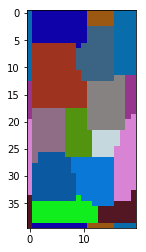

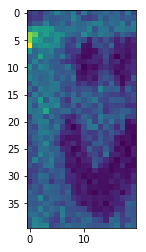

In [64]:
communities = [[141,142,143,144,145,146,147,148,161,162,163,164,165,166,167,168,181,182,183,184,185,186,187,188,201,202,203,204,205,206,207,208,221,222,223,224,225,226,227,228,241,242,243,244,245,246,247,248,249,261,262,263,264,265,266,267,268,269,281,282,283,284,285,286,287,288,289,290,301,302,303,304,305,306,307,308,309,310,321,322,323,324,325,326,327,328,329,330,341,342,343,344,345,346,347,348,349,350,361,362,363,364,365,366,367,368,369,370],[1,2,3,4,5,6,7,8,9,10,21,22,23,24,25,26,27,28,29,30,41,42,43,44,45,46,47,48,49,50,61,62,63,64,65,66,67,68,69,70,81,82,83,84,85,86,87,88,89,90,101,102,103,104,105,106,107,108,109,110,121,122,123,124,125,126,127,128,129,130,149],[419,420,438,439,440,458,459,460,477,478,479,480,497,498,499,500,517,518,519,520,536,537,538,539,540,556,557,558,559,560,576,577,578,579,580,596,597,598,599,600,616,617,618,619,620,636,637,638,639,640,656,657,658,659,660,676,677,678,679,680,696,697,698,716,717,718],[16,17,18,19,20,36,37,38,39,40,56,57,58,59,60,76,77,78,79,80,96,97,98,99,100,116,117,118,119,120,136,137,138,139,140,156,157,158,159,160,176,177,178,179,180,196,197,198,199,200,216,217,218,219,220,236,237,238,239,240,256,257,258,259,260],[276,277,291,292,293,294,295,296,297,311,312,313,314,315,316,317,331,332,333,334,335,336,337,351,352,353,354,355,356,357,371,372,373,374,375,376,377,391,392,393,394,395,396,397,411,412,413,414,415,416,417,431,432,433,434,435,436,437,451,452,453,454,455,456,457],[542,543,544,545,546,562,563,564,565,566,567,581,582,583,584,585,586,587,601,602,603,604,605,606,607,621,622,623,624,625,626,627,628,641,642,643,644,645,646,647,648,661,662,663,664,665,666,667,668,681,682,683,684,685,686,687,688,701,702,703,704,705,706,707,708],[568,569,570,571,572,573,574,575,588,589,590,591,592,593,594,595,608,609,610,611,612,613,614,615,629,630,631,632,633,634,635,649,650,651,652,653,654,655,669,670,671,672,673,674,675,689,690,691,692,693,694,695,710,711,712,713,714,715,732,733,734,735],[91,92,93,94,95,111,112,113,114,115,131,132,133,134,135,150,151,152,153,154,155,169,170,171,172,173,174,175,189,190,191,192,193,194,195,209,210,211,212,213,214,215,229,230,231,232,233,234,235,250,251,252,253,254,255,270,271,272,273,274,275],[381,382,383,384,385,386,401,402,403,404,405,406,421,422,423,424,425,426,441,442,443,444,445,446,461,462,463,464,465,466,481,482,483,484,485,486,501,502,503,504,505,506,521,522,523,524,525,526,541,561],[709,721,722,723,724,725,726,727,728,729,730,731,741,742,743,744,745,746,747,748,749,750,751,752,761,762,763,764,765,766,767,768,769,770,771,772,781,782,783,784,785,786,787,788,789,790,791,792],[387,388,389,390,407,408,409,410,427,428,429,430,447,448,449,450,467,468,469,470,471,487,488,489,490,491,507,508,509,510,511,527,528,529,530,531,547,548,549,550,551],[699,700,719,720,736,737,738,739,740,753,754,755,756,757,758,759,760,773,774,775,776,777,778,779,780,793,794,795,796,797,798,799,800],[472,473,474,475,476,492,493,494,495,496,512,513,514,515,516,532,533,534,535,552,553,554,555],[278,279,280,298,299,300,318,319,320,338,339,340,358,359,360,378,379,380,398,399,400,418],[11,12,13,14,15,31,32,33,34,35,51,52,53,54,55,71,72,73,74,75]]
image = np.zeros((x,y,3))
for community in communities:
    color = np.random.randint(1, 255, 3)
    for pixel in community:
        image[pixel//y-1,pixel%y,:] = color
image = image.astype(int)
plt.imshow(image)
plt.show()
plt.imshow(desi_image[:,:,np.argmin(abs(z_axis - 473))])
plt.show()

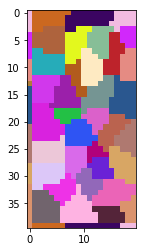

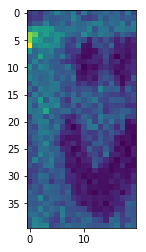

In [65]:
communities = [[7,8,9,10,11,12,13,14,15,16,28,29,30,31,32,33,34,35,47,48,49,50,51,52,53,54,55,67,68,69,70,71,72,73,74,87,88],[276,296,297,298,299,300,316,317,318,319,320,336,337,338,339,340,355,356,357,358,359,360,375,376,377,378,379,380,395,396,397,398,399,400,418,419,420],[361,362,363,381,382,383,384,401,402,403,404,421,422,423,424,425,441,442,443,444,445,446,461,462,463,464,465,466,481,482,483,484,485],[535,536,555,556,557,558,575,576,577,578,579,580,595,596,597,598,599,600,616,617,618,619,620,636,637,638,639,640,658,659],[669,689,708,709,710,727,728,729,730,731,746,747,748,749,750,751,766,767,768,769,770,771,772,786,787,788,789,790,791,792],[654,655,656,657,674,675,676,677,678,679,693,694,695,696,697,698,699,712,713,714,715,716,717,718,732,733,734,735,736],[1,2,3,4,5,6,21,22,23,24,25,26,27,41,42,43,44,45,46,61,62,63,64,65,66,81,82],[681,682,683,701,702,703,704,721,722,723,724,725,741,742,743,744,745,761,762,763,764,765,781,782,783,784,785],[83,84,85,86,101,102,103,104,105,106,121,122,123,124,125,126,141,142,143,144,145,146,163,164,165,166],[161,162,181,182,183,184,185,186,201,202,203,204,205,206,221,222,223,224,225,226,241,242,243,244,245,246],[274,275,293,294,295,311,312,313,314,315,331,332,333,334,335,350,351,352,353,354,370,371,372,373,374,390],[439,440,458,459,460,477,478,479,480,496,497,498,499,500,516,517,518,519,520,537,538,539,540,559,560],[486,501,502,503,504,505,506,521,522,523,524,525,526,541,542,543,544,545,546,561,562,563,564,565,566],[581,582,583,584,585,586,601,602,603,604,605,606,621,622,623,624,625,626,641,642,643,644,645,661,662],[170,171,190,191,192,210,211,212,213,230,231,232,233,250,251,252,253,270,271,272,273,290,291,292],[428,429,430,447,448,449,450,451,467,468,469,470,471,487,488,489,490,491,492,507,508,509,510,511],[89,90,91,107,108,109,110,127,128,129,130,147,148,149,150,167,168,169,187,188,189,207,208],[266,267,286,287,305,306,307,308,325,326,327,328,345,346,347,348,349,364,365,366,367,368,369],[261,262,263,264,265,281,282,283,284,285,301,302,303,304,321,322,323,324,341,342,343,344],[415,416,417,435,436,437,438,454,455,456,457,473,474,475,476,493,494,495,513,514,515,534],[17,18,19,20,36,37,38,39,40,56,57,58,59,60,75,76,77,78,79,80,96],[92,93,94,95,111,112,113,114,131,132,133,134,151,152,153,154,172,173,174,193,194],[115,116,135,136,155,156,157,175,176,177,195,196,214,215,216,234,235,236,254,255,256],[178,179,197,198,199,200,217,218,219,220,237,238,239,240,257,258,259,260,277,278,279],[527,528,529,530,547,548,549,550,567,568,569,570,587,588,589,590,607,608,609,628],[627,646,647,648,663,664,665,666,667,668,684,685,686,687,688,705,706,707,726],[660,680,700,719,720,737,738,739,740,757,758,759,760,778,779,780,798,799,800],[610,611,629,630,631,649,650,651,652,653,670,671,672,673,690,691,692,711],[97,98,99,100,117,118,119,120,137,138,139,140,158,159,160,180],[391,392,393,394,410,411,412,413,414,431,432,433,434,452,453,472],[209,227,228,229,247,248,249,268,269,288,289,309,310,329,330],[572,573,574,591,592,593,594,612,613,614,615,632,633,634,635],[752,753,754,755,756,773,774,775,776,777,793,794,795,796,797],[385,386,387,388,389,405,406,407,408,409,426,427],[512,531,532,533,551,552,553,554,571],[280]]
image = np.zeros((x,y,3))
for community in communities:
    color = np.random.randint(1, 255, 3)
    for pixel in community:
        image[pixel//y-1,pixel%y,:] = color
image = image.astype(int)
plt.imshow(image)
plt.show()
plt.imshow(desi_image[:,:,np.argmin(abs(z_axis - 473))])
plt.show()

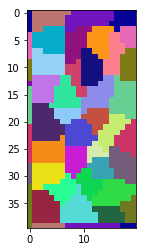

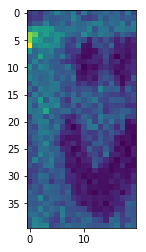

In [68]:
communities = [[7,8,9,10,11,12,13,14,15,16,28,29,30,31,32,33,34,35,47,48,49,50,51,52,53,54,55,67,68,69,70,71,72,73,74,87,88],[276,296,297,298,299,300,316,317,318,319,320,336,337,338,339,340,355,356,357,358,359,360,375,376,377,378,379,380,395,396,397,398,399,400,418,419,420],[361,362,363,381,382,383,384,401,402,403,404,421,422,423,424,425,441,442,443,444,445,446,461,462,463,464,465,466,481,482,483,484,485],[535,536,555,556,557,558,575,576,577,578,579,580,595,596,597,598,599,600,616,617,618,619,620,636,637,638,639,640,658,659],[669,689,708,709,710,727,728,729,730,731,746,747,748,749,750,751,766,767,768,769,770,771,772,786,787,788,789,790,791,792],[654,655,656,657,674,675,676,677,678,679,693,694,695,696,697,698,699,712,713,714,715,716,717,718,732,733,734,735,736],[1,2,3,4,5,6,21,22,23,24,25,26,27,41,42,43,44,45,46,61,62,63,64,65,66,81,82],[681,682,683,701,702,703,704,721,722,723,724,725,741,742,743,744,745,761,762,763,764,765,781,782,783,784,785],[83,84,85,86,101,102,103,104,105,106,121,122,123,124,125,126,141,142,143,144,145,146,163,164,165,166],[161,162,181,182,183,184,185,186,201,202,203,204,205,206,221,222,223,224,225,226,241,242,243,244,245,246],[274,275,293,294,295,311,312,313,314,315,331,332,333,334,335,350,351,352,353,354,370,371,372,373,374,390],[439,440,458,459,460,477,478,479,480,496,497,498,499,500,516,517,518,519,520,537,538,539,540,559,560],[486,501,502,503,504,505,506,521,522,523,524,525,526,541,542,543,544,545,546,561,562,563,564,565,566],[581,582,583,584,585,586,601,602,603,604,605,606,621,622,623,624,625,626,641,642,643,644,645,661,662],[170,171,190,191,192,210,211,212,213,230,231,232,233,250,251,252,253,270,271,272,273,290,291,292],[428,429,430,447,448,449,450,451,467,468,469,470,471,487,488,489,490,491,492,507,508,509,510,511],[89,90,91,107,108,109,110,127,128,129,130,147,148,149,150,167,168,169,187,188,189,207,208],[266,267,286,287,305,306,307,308,325,326,327,328,345,346,347,348,349,364,365,366,367,368,369],[261,262,263,264,265,281,282,283,284,285,301,302,303,304,321,322,323,324,341,342,343,344],[415,416,417,435,436,437,438,454,455,456,457,473,474,475,476,493,494,495,513,514,515,534],[17,18,19,20,36,37,38,39,40,56,57,58,59,60,75,76,77,78,79,80,96],[92,93,94,95,111,112,113,114,131,132,133,134,151,152,153,154,172,173,174,193,194],[115,116,135,136,155,156,157,175,176,177,195,196,214,215,216,234,235,236,254,255,256],[178,179,197,198,199,200,217,218,219,220,237,238,239,240,257,258,259,260,277,278,279],[527,528,529,530,547,548,549,550,567,568,569,570,587,588,589,590,607,608,609,628],[627,646,647,648,663,664,665,666,667,668,684,685,686,687,688,705,706,707,726],[660,680,700,719,720,737,738,739,740,757,758,759,760,778,779,780,798,799,800],[610,611,629,630,631,649,650,651,652,653,670,671,672,673,690,691,692,711],[97,98,99,100,117,118,119,120,137,138,139,140,158,159,160,180],[391,392,393,394,410,411,412,413,414,431,432,433,434,452,453,472],[209,227,228,229,247,248,249,268,269,288,289,309,310,329,330],[572,573,574,591,592,593,594,612,613,614,615,632,633,634,635],[752,753,754,755,756,773,774,775,776,777,793,794,795,796,797],[385,386,387,388,389,405,406,407,408,409,426,427],[512,531,532,533,551,552,553,554,571],[280]]
image = np.zeros((x,y,3))
for community in communities:
    color = np.random.randint(1, 255, 3)
    for pixel in community:
        image[pixel//y-1,pixel%y,:] = color
image = image.astype(int)
plt.imshow(image)
plt.show()
plt.imshow(desi_image[:,:,np.argmin(abs(z_axis - 473))])
plt.show()

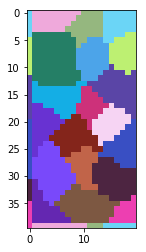

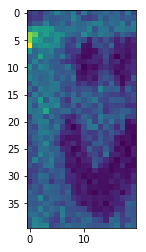

In [75]:
communities = [[101,102,103,104,105,106,107,121,122,123,124,125,126,127,128,141,142,143,144,145,146,147,148,161,162,163,164,165,166,167,168,181,182,183,184,185,186,187,188,201,202,203,204,205,206,207,208,221,222,223,224,225,226,227,228,241,242,243,244,245,246,247,248,249,261,262,263,264,265,266,267,268,269,282,283,284,285,286,287,288],[503,504,522,523,524,525,542,543,544,545,561,562,563,564,565,566,581,582,583,584,585,586,587,601,602,603,604,605,606,607,621,622,623,624,625,626,627,628,642,643,644,645,646,647,648,662,663,664,665,666,667,683,684,685,686,703,704,705,724],[235,254,255,256,257,259,260,273,274,275,276,277,278,279,280,291,292,293,294,295,296,297,298,299,300,312,313,314,315,316,317,318,319,320,333,334,335,336,337,338,339,340,354,355,356,357,358,359,360,376,377,378,379,380,398,399,400,419],[668,669,687,688,689,690,691,692,706,707,708,709,710,711,712,713,714,725,726,727,728,729,730,731,732,733,734,735,736,746,747,748,749,750,751,752,753,754,755,767,768,769,770,771,772,773,774,775,788,789,790,791,792,793,794],[573,574,575,592,593,594,595,596,612,613,614,615,616,617,618,619,632,633,634,635,636,637,638,639,640,652,653,654,655,656,657,658,659,660,673,674,675,676,677,678,679,680,693,694,695,696,697,698,699,700,715,716,717,718],[420,439,440,458,459,460,477,478,479,480,496,497,498,499,500,514,515,516,517,518,519,520,534,535,536,537,538,539,540,553,554,555,556,557,558,559,560,576,577,578,579,580,597,598,599,600,620],[408,409,427,428,429,430,446,447,448,449,450,465,466,467,468,469,470,471,484,485,486,487,488,489,490,491,492,505,506,507,508,509,510,511,512,526,527,528,529,532,533,546,547],[281,289,290,301,302,303,304,305,306,307,308,309,321,322,323,324,325,326,327,328,329,341,342,343,344,345,346,347,348,349,363,364,365,366,367,368,385,386,387,388,406,407],[14,15,16,17,18,19,20,34,35,36,37,38,39,40,54,55,56,57,58,59,60,74,75,76,77,78,79,80,94,95,96,97,98,99,100,114,115,116,117,134,135],[1,2,3,4,5,6,7,8,9,10,21,22,23,24,25,26,27,28,29,41,42,43,44,45,46,47,48,61,62,63,64,65,66,67,81,82,83,84,85,86],[131,132,133,150,151,152,153,154,169,170,171,172,173,174,189,190,191,192,193,194,209,210,211,212,213,214,229,230,231,232,233,234,250,251,252,253,270,271,272],[118,119,120,136,137,138,139,140,155,156,157,158,159,160,175,176,177,178,179,180,195,196,197,198,199,200,215,216,217,218,219,220,236,237,238,239,240,258],[11,12,13,30,31,32,33,49,50,51,52,53,68,69,70,71,72,73,87,88,89,90,91,92,93,108,109,110,111,112,113,129,130,149],[361,362,381,382,383,384,401,402,403,404,405,421,422,423,424,425,426,441,442,443,444,445,461,462,463,464,481,482,483,501,502,521,541],[375,394,395,396,397,413,414,415,416,417,418,432,433,434,435,436,437,438,452,453,454,455,456,457,472,473,474,475,476,493,494,495,513],[530,531,548,549,550,551,552,567,568,569,570,571,572,588,589,590,591,608,609,610,611,629,630,631,649,650,651,670,671,672],[641,661,681,682,701,702,721,722,723,741,742,743,744,745,761,762,763,764,765,766,781,782,783,784,785,786,787],[310,311,330,331,332,350,351,352,353,369,370,371,372,373,374,389,390,391,392,393,410,411,412,431,451],[719,720,737,738,739,740,756,757,758,759,760,776,777,778,779,780,795,796,797,798,799,800]]
image = np.zeros((x,y,3))
for community in communities:
    color = np.random.randint(1, 255, 3)
    for pixel in community:
        image[pixel//y-1,pixel%y,:] = color
image = image.astype(int)
plt.imshow(image)
plt.show()
plt.imshow(desi_image[:,:,np.argmin(abs(z_axis - 473))])
plt.show()

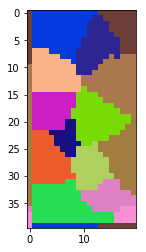

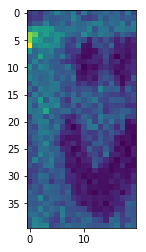

In [78]:
communities = [[1,2,3,4,5,6,7,8,9,10,11,12,21,22,23,24,25,26,27,28,29,30,31,32,41,42,43,44,45,46,47,48,49,50,51,61,62,63,64,65,66,67,68,69,70,81,82,83,84,85,86,87,88,89,90,101,102,103,104,105,106,107,108,109,110,121,122,123,124,125,126,127,128,129,141,142,143,144,145,146,147,148,149,164,165,166,167,168,186,187,188,208],[195,197,198,199,214,215,216,217,218,219,220,233,234,235,236,237,238,239,240,252,253,254,255,256,257,258,259,260,270,271,272,273,274,275,276,277,278,279,280,290,291,292,293,294,295,296,297,298,299,300,311,312,313,314,315,316,317,318,319,320,333,334,335,336,337,338,339,340,354,355,356,357,358,359,360,376,377,378,379,380,397,398,399,400,419],[647,648,661,662,663,664,665,666,667,668,681,682,683,684,685,686,687,688,689,701,702,703,704,705,706,707,708,709,721,722,723,724,725,726,727,728,729,730,741,742,743,744,745,746,747,748,749,750,751,761,762,763,764,765,766,767,768,769,770,771,772,773,774,775,781,782,783,784,785,786,787,788,789,790,791,792,793,794,795],[420,439,440,458,459,460,477,478,479,480,495,496,497,498,499,500,513,514,515,516,517,518,519,520,533,534,535,536,537,538,539,540,554,555,556,557,558,559,560,575,576,577,578,579,580,595,596,597,598,599,600,615,616,617,618,619,620,636,637,638,639,640,657,658,659,660,677,678,679,680,699,700,720],[310,329,330,331,332,349,350,351,352,353,369,370,371,372,373,374,375,388,389,390,391,392,393,394,395,396,408,409,410,411,412,413,414,415,416,417,418,429,430,431,432,433,434,435,436,437,438,449,450,451,452,453,454,455,456,457,469,470,471,472,473,474,475,476,489,490,491,492,493,494,510,511],[161,162,163,181,182,183,184,185,201,202,203,204,205,206,207,221,222,223,224,225,226,227,228,241,242,243,244,245,246,247,248,261,262,263,264,265,266,267,268,269,281,282,283,284,285,286,287,288,289,301,302,303,304,305,306,307,308,309],[461,462,463,481,482,483,484,501,502,503,504,521,522,523,524,525,541,542,543,544,545,546,561,562,563,564,565,566,567,581,582,583,584,585,586,587,601,602,603,604,605,606,607,621,622,623,624,625,626,627,628,641,642,643,644,645,646],[52,53,71,72,73,74,91,92,93,94,111,112,113,114,115,130,131,132,133,134,135,136,150,151,152,153,154,155,156,169,170,171,172,173,174,175,176,189,190,191,192,193,194,196,209,210,211,212,213,229,230,231,232,249,250,251],[13,14,15,16,17,18,19,20,33,34,35,36,37,38,39,40,54,55,56,57,58,59,60,75,76,77,78,79,80,95,96,97,98,99,100,116,117,118,119,120,137,138,139,140,157,158,159,160,177,178,179,180,200],[321,322,323,324,325,326,327,328,341,342,343,344,345,346,347,348,361,362,363,364,365,366,367,368,381,382,383,384,385,386,387,401,402,403,404,405,406,407,421,422,423,424,425,426,441,442,443,444,445,446],[512,529,530,531,532,549,550,551,552,553,568,569,570,571,572,573,574,588,589,590,591,592,593,594,608,609,610,611,612,613,614,629,630,631,632,633,634,635,649,650,651,652,653,669,670,671,672],[654,655,656,673,674,675,676,690,691,692,693,694,695,696,697,698,710,711,712,713,714,715,716,717,718,719,731,732,733,734,735,736,737,738,739,740,752,753,754,755,756],[427,428,447,448,464,465,466,467,468,485,486,487,488,505,506,507,508,509,526,527,528,547,548],[757,758,759,760,776,777,778,779,780,796,797,798,799,800]]
image = np.zeros((x,y,3))
for community in communities:
    color = np.random.randint(1, 255, 3)
    for pixel in community:
        image[pixel//y-1,pixel%y,:] = color
image = image.astype(int)
plt.imshow(image)
plt.show()
plt.imshow(desi_image[:,:,np.argmin(abs(z_axis - 473))])
plt.show()

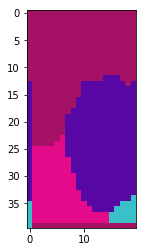

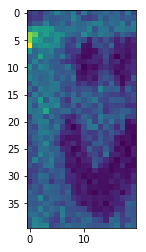

In [79]:
communities = [[1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,202,203,204,205,206,207,208,209,210,211,212,213,214,215,216,217,218,219,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234,235,236,237,238,239,240,241,242,243,244,245,246,247,248,249,250,251,252,253,254,255,256,257,258,259,260,261,262,263,264,265,266,267,268,269,270,271,272,273,277,278,279,281,282,283,284,285,286,287,288,289,298,301,302,303,304,305,306,307,308,309,321,322,323,324,325,326,327,328,329,341,342,343,344,345,346,347,348,361,362,363,364,365,366,367,368,381,382,383,384,385,386,387,401,402,403,404,405,406,421,422,423,424,425,426,441,442,443,444,445,446,461,462,463,464,465,466,481,482,483,484,485,501,502,503,504],[274,275,276,280,290,291,292,293,294,295,296,297,299,300,310,311,312,313,314,315,316,317,318,319,320,330,331,332,333,334,335,336,337,338,339,340,349,350,351,352,353,354,355,356,357,358,359,360,369,370,371,372,373,374,375,376,377,378,379,380,388,389,390,391,392,393,394,395,396,397,398,399,400,407,408,409,410,411,412,413,414,415,416,417,418,419,420,427,428,429,430,431,432,433,434,435,436,437,438,439,440,447,448,449,450,451,452,453,454,455,456,457,458,459,460,467,468,469,470,471,472,473,474,475,476,477,478,479,480,487,488,489,490,491,492,493,494,495,496,497,498,499,500,507,508,509,510,511,512,513,514,515,516,517,518,519,520,527,528,529,530,531,532,533,534,535,536,537,538,539,540,547,548,549,550,551,552,553,554,555,556,557,558,559,560,568,569,570,571,572,573,574,575,576,577,578,579,580,588,589,590,591,592,593,594,595,596,597,598,599,600,608,609,610,611,612,613,614,615,616,617,618,619,620,629,630,631,632,633,634,635,636,637,638,639,640,649,650,651,652,653,654,655,656,657,658,659,660,669,670,671,672,673,674,675,676,677,678,679,680,690,691,692,693,694,695,696,697,698,699,700,710,711,712,713,714,715,716,717,718,731,732,733,734,735,736,752,753,754,755],[486,505,506,521,522,523,524,525,526,541,542,543,544,545,546,561,562,563,564,565,566,567,581,582,583,584,585,586,587,601,602,603,604,605,606,607,621,622,623,624,625,626,627,628,641,642,643,644,645,646,647,648,661,662,663,664,665,666,667,668,681,682,683,684,685,686,687,688,689,701,702,703,704,705,706,707,708,709,721,722,723,724,725,726,727,728,729,730,741,742,743,744,745,746,747,748,749,750,751,761,762,763,764,765,766,767,768,769,770,771,772,773,774,781,782,783,784,785,786,787,788,789,790,791,792,793,794],[719,720,737,738,739,740,756,757,758,759,760,775,776,777,778,779,780,795,796,797,798,799,800]]
image = np.zeros((x,y,3))
for community in communities:
    color = np.random.randint(1, 255, 3)
    for pixel in community:
        image[pixel//y-1,pixel%y,:] = color
image = image.astype(int)
plt.imshow(image)
plt.show()
plt.imshow(desi_image[:,:,np.argmin(abs(z_axis - 473))])
plt.show()

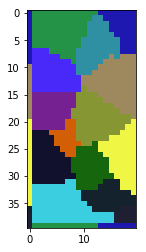

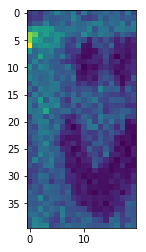

In [83]:
communities = [[1,2,3,4,5,6,7,8,9,10,11,12,21,22,23,24,25,26,27,28,29,30,31,32,41,42,43,44,45,46,47,48,49,50,51,61,62,63,64,65,66,67,68,69,70,81,82,83,84,85,86,87,88,89,90,101,102,103,104,105,106,107,108,109,110,121,122,123,124,125,126,127,128,129,141,142,143,144,145,146,147,148,149,164,165,166,167,168,186,187,188,208],[195,197,198,199,214,215,216,217,218,219,220,233,234,235,236,237,238,239,240,252,253,254,255,256,257,258,259,260,270,271,272,273,274,275,276,277,278,279,280,290,291,292,293,294,295,296,297,298,299,300,311,312,313,314,315,316,317,318,319,320,333,334,335,336,337,338,339,340,354,355,356,357,358,359,360,376,377,378,379,380,397,398,399,400,419],[647,648,661,662,663,664,665,666,667,668,681,682,683,684,685,686,687,688,689,701,702,703,704,705,706,707,708,709,721,722,723,724,725,726,727,728,729,730,741,742,743,744,745,746,747,748,749,750,751,761,762,763,764,765,766,767,768,769,770,771,772,773,774,775,781,782,783,784,785,786,787,788,789,790,791,792,793,794,795],[420,439,440,458,459,460,477,478,479,480,495,496,497,498,499,500,513,514,515,516,517,518,519,520,533,534,535,536,537,538,539,540,554,555,556,557,558,559,560,575,576,577,578,579,580,595,596,597,598,599,600,615,616,617,618,619,620,636,637,638,639,640,657,658,659,660,677,678,679,680,699,700,720],[310,329,330,331,332,349,350,351,352,353,369,370,371,372,373,374,375,388,389,390,391,392,393,394,395,396,408,409,410,411,412,413,414,415,416,417,418,429,430,431,432,433,434,435,436,437,438,449,450,451,452,453,454,455,456,457,469,470,471,472,473,474,475,476,489,490,491,492,493,494,510,511],[161,162,163,181,182,183,184,185,201,202,203,204,205,206,207,221,222,223,224,225,226,227,228,241,242,243,244,245,246,247,248,261,262,263,264,265,266,267,268,269,281,282,283,284,285,286,287,288,289,301,302,303,304,305,306,307,308,309],[461,462,463,481,482,483,484,501,502,503,504,521,522,523,524,525,541,542,543,544,545,546,561,562,563,564,565,566,567,581,582,583,584,585,586,587,601,602,603,604,605,606,607,621,622,623,624,625,626,627,628,641,642,643,644,645,646],[52,53,71,72,73,74,91,92,93,94,111,112,113,114,115,130,131,132,133,134,135,136,150,151,152,153,154,155,156,169,170,171,172,173,174,175,176,189,190,191,192,193,194,196,209,210,211,212,213,229,230,231,232,249,250,251],[13,14,15,16,17,18,19,20,33,34,35,36,37,38,39,40,54,55,56,57,58,59,60,75,76,77,78,79,80,95,96,97,98,99,100,116,117,118,119,120,137,138,139,140,157,158,159,160,177,178,179,180,200],[321,322,323,324,325,326,327,328,341,342,343,344,345,346,347,348,361,362,363,364,365,366,367,368,381,382,383,384,385,386,387,401,402,403,404,405,406,407,421,422,423,424,425,426,441,442,443,444,445,446],[512,529,530,531,532,549,550,551,552,553,568,569,570,571,572,573,574,588,589,590,591,592,593,594,608,609,610,611,612,613,614,629,630,631,632,633,634,635,649,650,651,652,653,669,670,671,672],[654,655,656,673,674,675,676,690,691,692,693,694,695,696,697,698,710,711,712,713,714,715,716,717,718,719,731,732,733,734,735,736,737,738,739,740,752,753,754,755,756],[427,428,447,448,464,465,466,467,468,485,486,487,488,505,506,507,508,509,526,527,528,547,548],[757,758,759,760,776,777,778,779,780,796,797,798,799,800]]
image = np.zeros((x,y,3))
for community in communities:
    color = np.random.randint(1, 255, 3)
    for pixel in community:
        image[pixel//y-1,pixel%y,:] = color
image = image.astype(int)
plt.imshow(image)
plt.show()
plt.imshow(desi_image[:,:,np.argmin(abs(z_axis - 473))])
plt.show()

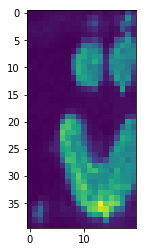

In [90]:
plt.imshow(desi_image[:,:,np.argmin(abs(z_axis - 473.3))])
plt.show()

In [105]:
smiley = desi_image[:,:,np.argmin(abs(z_axis - 473.3))]
point = 30, 10


array([195., 168., 188., ...,  73.,  27.,   0.], dtype=float32)